In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/01301.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/02578.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/06781.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/00929.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/04915.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/07470.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/08216.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/02630.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/03862.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/01883.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/00704.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/03163.png
/kaggle/input/maze-dataset-with-solutions/ImageDataset/hak/mazes/01124.png
/kaggle/input/maze-datase

KeyboardInterrupt: 

# Importing Key Libraries

In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch import nn

import random
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from typing import List
from tqdm import tqdm

torch.__version__

'2.6.0+cu124'

# Creating Dataset

In [2]:
class MazeSolPair(Dataset):
    """
    A custom dataset class returning maze path along with it's solution path
    """
    def __init__(self, root_dir: Path, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Collect all image paths
        maze_paths = sorted(list(root_dir.glob('*/mazes/*.png')))
        sol_paths = sorted(list(root_dir.glob('*/solutions/*.png')))

        assert len(maze_paths) == len(sol_paths), "Mismatch between maze and solution images."
        self.pairs = list(zip(maze_paths, sol_paths))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, index):
        x_path, y_path = self.pairs[index]
        x = Image.open(x_path).convert('RGB')
        y = Image.open(y_path).convert('RGB')

        if self.transform:
            x = self.transform(x)
            y = self.transform(y)

        return x, y

    def show_batch(self, n_explore: int = 5):
        imgs_to_show = random.sample(self.pairs, k=n_explore)
        fig, axs = plt.subplots(n_explore, 2, figsize=(6, n_explore * 3))

        for index, (x_p, y_p) in enumerate(imgs_to_show):
            x = Image.open(x_p).convert('RGB')
            y = Image.open(y_p).convert('RGB')

            axs[index, 0].imshow(x)
            axs[index, 0].set_title('Maze')
            axs[index, 0].axis('off')

            axs[index, 1].imshow(y)
            axs[index, 1].set_title('Solution')
            axs[index, 1].axis('off')

        plt.tight_layout()
        plt.show()


# Defining Augmentations

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize( #tanh activation
            std = [0.5]*3,
            mean = [0.5]*3,
        )
    ]
)

# Instatinating Custom Dataset

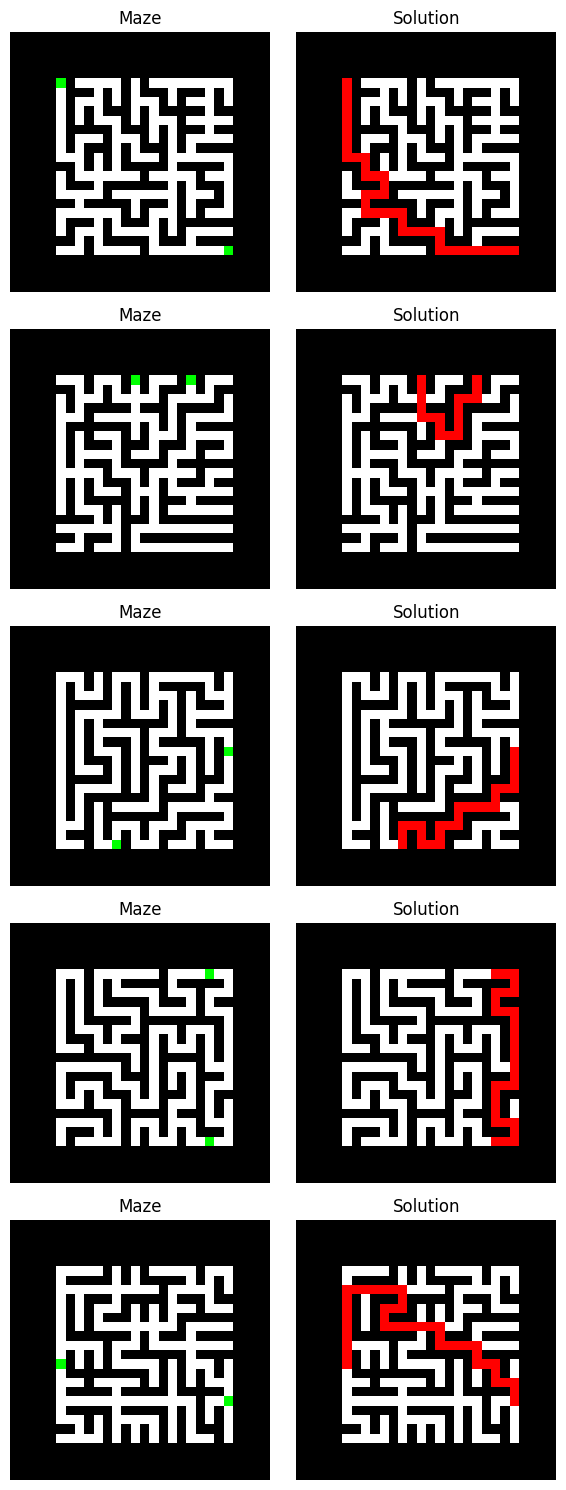

In [4]:
root_dir = Path('/kaggle/input/maze-dataset-with-solutions/ImageDataset')
root_dir.exists()

data = MazeSolPair(
    root_dir = root_dir,
    transform = transform,
)

data.show_batch()

# Creating Dataloader

In [5]:
loader = DataLoader(
    batch_size = 64,
    shuffle = True,
    dataset = data,
    num_workers = 0,
)

# Defining Generator Architecture

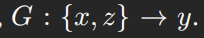 <br>
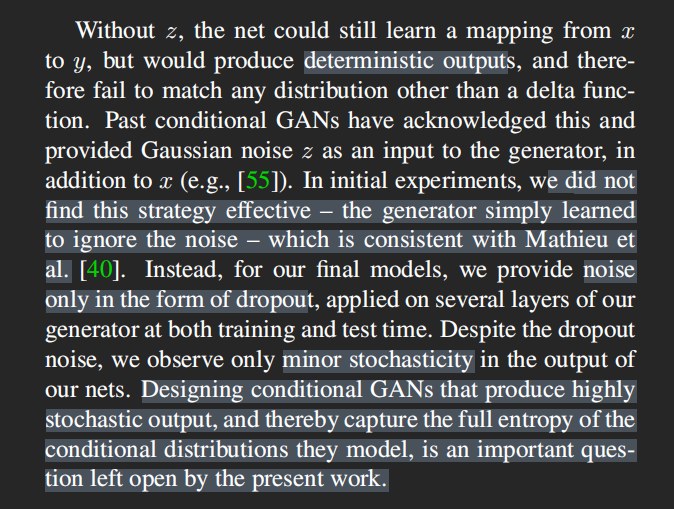<br>
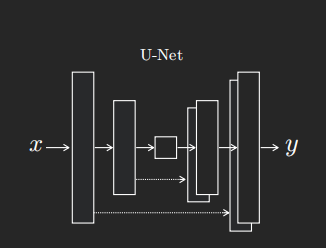 <br>
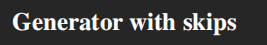

In [8]:
class Encoder(nn.Module):
    def __init__(self, ch_in: int = 3):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(ch_in, 64, kernel_size=3, padding=1), # Maze Image
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)  # 28 → 14
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)  # 14 → 7
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2)  # 7 → 3 (floor(7/2) = 3)
        
    def forward(self, x):
        x1 = self.enc1(x)     # 64 × 28×28
        x2 = self.pool1(x1)   # 64 × 14×14
        x3 = self.enc2(x2)    # 128 × 14×14
        x4 = self.pool2(x3)   # 128 × 7×7
        x5 = self.enc3(x4)    # 256 × 7×7
        x6 = self.pool3(x5)   # 256 × 3×3
        return x1, x3, x5, x6  # for skip connections and bottleneck || Depth first order to be implemented in discriminator

class Decoder(nn.Module):
    def __init__(self, ch_out: int = 3):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, output_padding=1)  # 3×3 → 7×7
        self.dec1 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # 7×7 → 14×14
        self.up2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)  # 7×7 → 14×14
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # 14×14 → 28×28
        self.up3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 14×14 → 28×28
        self.dec3 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, ch_out, kernel_size=1)
        )
        self.tanh = nn.Tanh()
    
    def forward(self, bottleneck, skip3, skip2, skip1):
        x = self.up1(bottleneck)           # 3×3 → 7×7
        x = torch.cat([x, skip3], dim=1)   # concat with 256×7×7
        x = self.dec1(x)
        
        x = self.up2(x)                    # 7×7 → 14×14
        x = torch.cat([x, skip2], dim=1)   # concat with 128×14×14
        x = self.dec2(x)
        
        x = self.up3(x)                    # 14×14 → 28×28
        x = torch.cat([x, skip1], dim=1)   # concat with 64×28×28
        x = self.dec3(x)
        return self.tanh(x)

class Generator(nn.Module):
    def __init__(self, ch_in: int = 3, ch_out: int = 3):
        super().__init__()
        self.encoder = Encoder(ch_in)
        self.decoder = Decoder(ch_out)
    
    def forward(self, x):
        l1, l2, l3, bottleneck = self.encoder(x)
        return self.decoder(bottleneck, l3, l2, l1)

In [9]:
image = torch.randn(64,3,28,28)
Generator()(image).shape

torch.Size([64, 3, 28, 28])

# Defining Discriminator Architecture

## 1. Pix To Pix Architecture

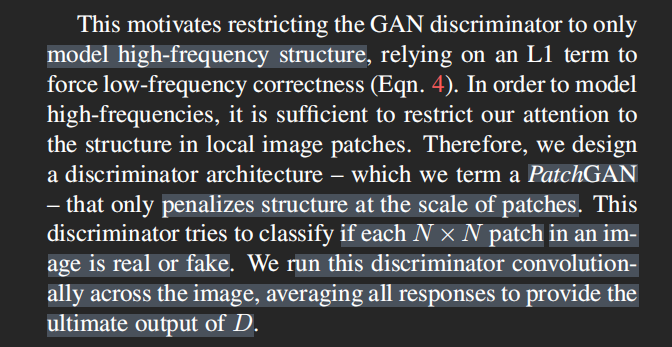

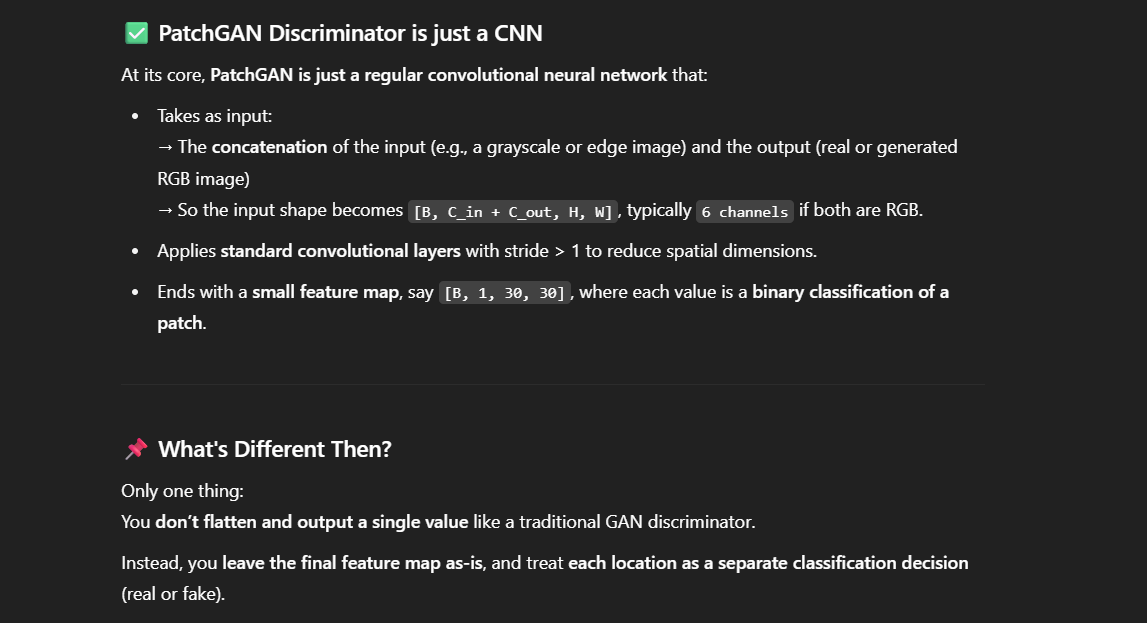

In [89]:
class PatchGan(nn.Module):
    def __init__(self,ch_in : int = 6):
        super().__init__()
        self.conv_1 = nn.Sequential(
            nn.Conv2d(ch_in,1,kernel_size=4,stride=2,padding = 1), # 3 from maze image and 3 from solution image || The discriminator also needs to be conditoned
            nn.LeakyReLU(0.2),
        )
        # self.conv_2 = nn.Sequential(
        #     nn.Conv2d(64,128, kernel_size = 4,stride = 2,padding = 1),
        #     nn.BatchNorm2d(128),
        #     nn.LeakyReLU(0.2),
        # )
        # self.conv_3 = nn.Sequential(
        #     nn.Conv2d(128,1,4,1,1),
        #     nn.LeakyReLU(), # Later paired with BCEWithlogitsloss so no need of nn.Sigmoid for probability
        # ) # Less it reduces the dimension more
    def forward(self,x):
        return self.conv_1(x)

In [90]:
# quick sanity check

pg = PatchGan()
pg(torch.randn(64,6,28,28)).shape

torch.Size([64, 1, 14, 14])

## 2. Modified pix2pix architecture

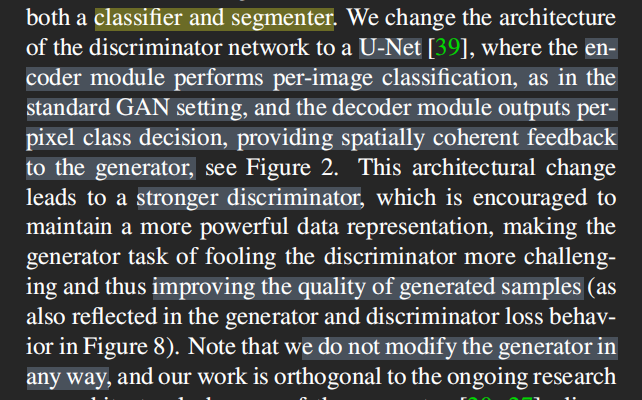
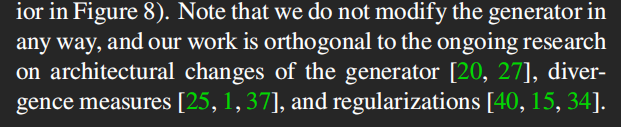

In [29]:
class Encoder(nn.Module):
    def __init__(self, ch_in: int = 3):
        super().__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(ch_in, 64, kernel_size=3, padding=1), # Maze Image
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)  # 28 → 14
        
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)  # 14 → 7
        
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2)  # 7 → 3 (floor(7/2) = 3)
        
    def forward(self, x):
        x1 = self.enc1(x)     # 64 × 28×28
        x2 = self.pool1(x1)   # 64 × 14×14
        x3 = self.enc2(x2)    # 128 × 14×14
        x4 = self.pool2(x3)   # 128 × 7×7
        x5 = self.enc3(x4)    # 256 × 7×7
        x6 = self.pool3(x5)   # 256 × 3×3
        return x1, x3, x5, x6  # for skip connections and bottleneck || Depth first order to be implemented in discriminator

class Decoder(nn.Module):
    def __init__(self, ch_out: int = 3):
        super().__init__()
        self.up1 = nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1, output_padding=1)  # 3×3 → 7×7
        self.dec1 = nn.Sequential(
            nn.Conv2d(256 + 256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # 7×7 → 14×14
        self.up2 = nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1)  # 7×7 → 14×14
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # 14×14 → 28×28
        self.up3 = nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1)  # 14×14 → 28×28
        self.dec3 = nn.Sequential(
            nn.Conv2d(64 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, ch_out, kernel_size=1)
        )
        self.tanh = nn.Tanh()
    
    def forward(self, bottleneck, skip3, skip2, skip1):
        x = self.up1(bottleneck)           # 3×3 → 7×7
        x = torch.cat([x, skip3], dim=1)   # concat with 256×7×7
        x = self.dec1(x)
        
        x = self.up2(x)                    # 7×7 → 14×14
        x = torch.cat([x, skip2], dim=1)   # concat with 128×14×14
        x = self.dec2(x)
        
        x = self.up3(x)                    # 14×14 → 28×28
        x = torch.cat([x, skip1], dim=1)   # concat with 64×28×28
        x = self.dec3(x)
        return self.tanh(x)

# Visualization Code

In [17]:
def denormalize(tensor):
    return (tensor * 0.5) + 0.5

def viz_training(model, loader, n_fixed=3, n_random=3):
    dataset = loader.dataset
    total = n_fixed + n_random
    indices = list(range(n_fixed)) + random.sample(range(n_fixed, len(dataset)), n_random)

    fig, axs = plt.subplots(total, 3, figsize=(9, total * 3))

    model.eval()
    with torch.no_grad():
        for idx, i in enumerate(indices):
            x_img, y_img = dataset[i]

            # Add batch dimension and move to correct device
            x_img_batch = x_img.unsqueeze(0).to(next(model.parameters()).device)

            # Forward pass
            y_pred = model(x_img_batch)[0].cpu()

            # Denormalize for display
            x_disp = denormalize(x_img).permute(1, 2, 0).cpu().numpy()
            y_disp = denormalize(y_img).permute(1, 2, 0).cpu().numpy()
            y_pred_disp = denormalize(y_pred).permute(1, 2, 0).numpy()

            axs[idx, 0].imshow(x_disp)
            axs[idx, 0].set_title(f"Maze #{i}")
            axs[idx, 0].axis("off")

            axs[idx, 1].imshow(y_pred_disp)
            axs[idx, 1].set_title("Predicted")
            axs[idx, 1].axis("off")

            axs[idx, 2].imshow(y_disp)
            axs[idx, 2].set_title("Solution")
            axs[idx, 2].axis("off")

    plt.tight_layout()
    plt.show()


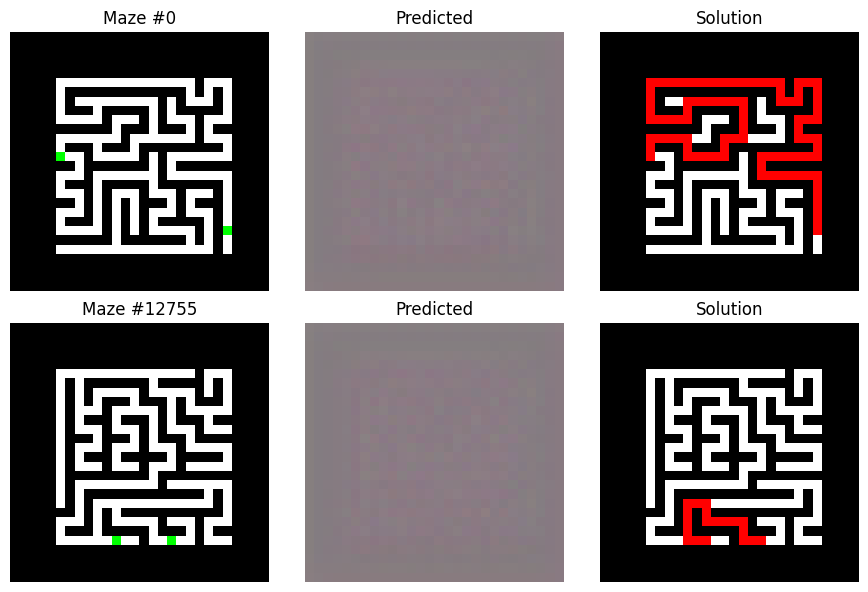

In [20]:
generator = Generator()
viz_training(generator,loader,n_fixed = 1,n_random = 1)

# Training Loop With Logging

## 1. Training Generator (U-Net) with L1 Loss

[Train] Epoch 1/70: 100%|██████████| 782/782 [01:51<00:00,  7.03it/s]


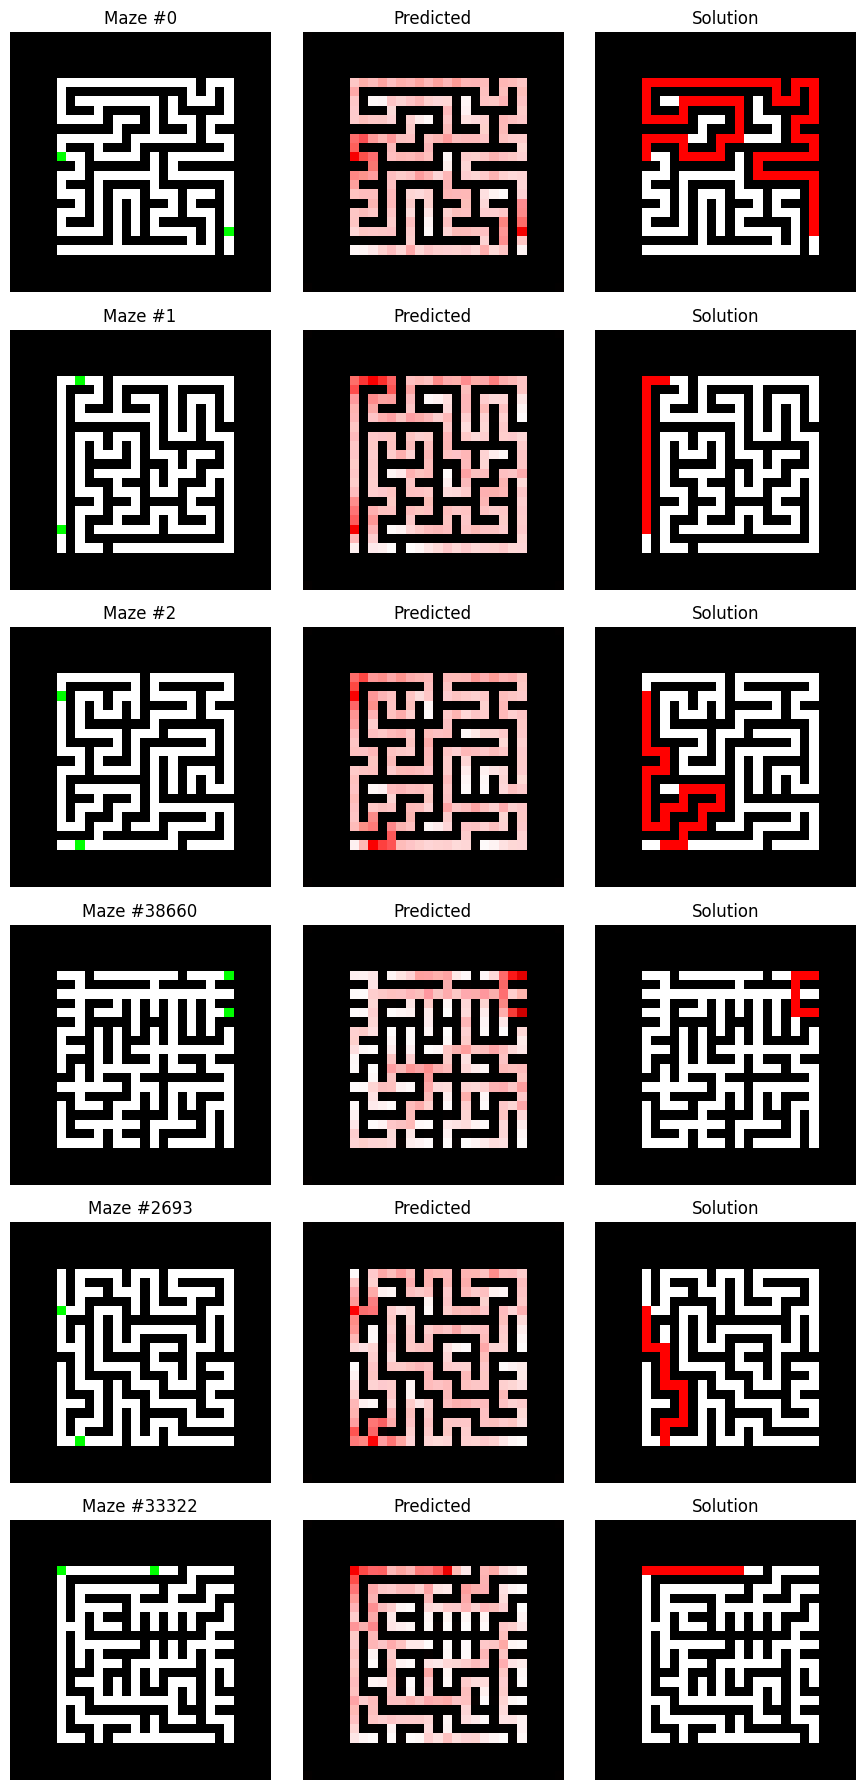

[Train] Epoch 2/70: 100%|██████████| 782/782 [01:49<00:00,  7.14it/s]


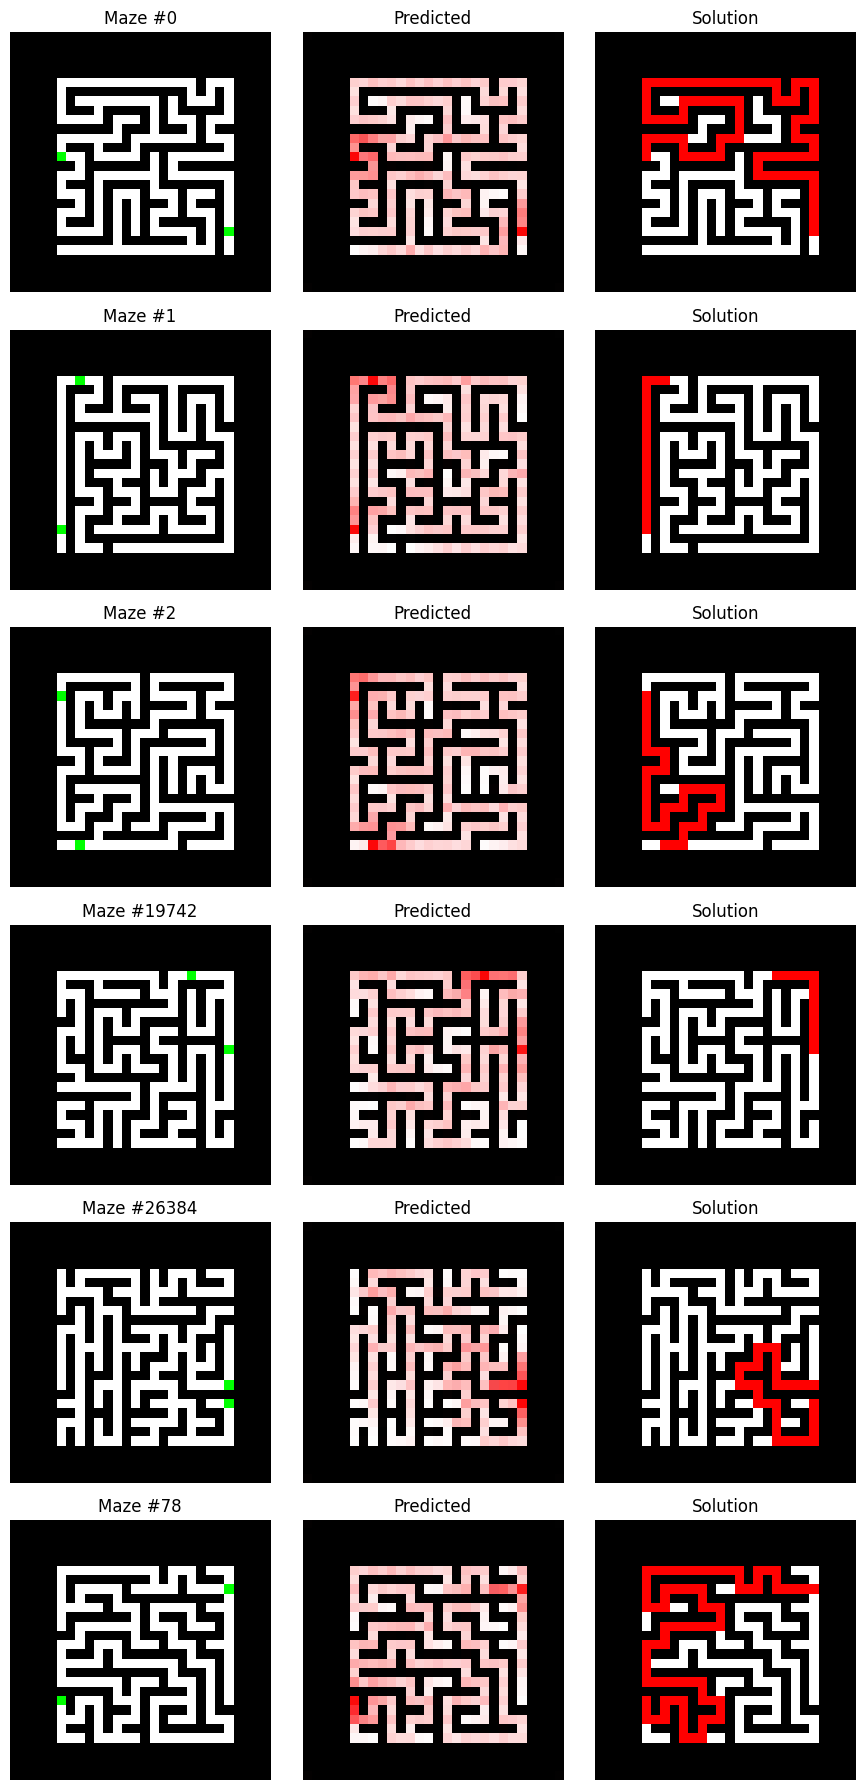

[Train] Epoch 3/70: 100%|██████████| 782/782 [01:51<00:00,  7.04it/s]


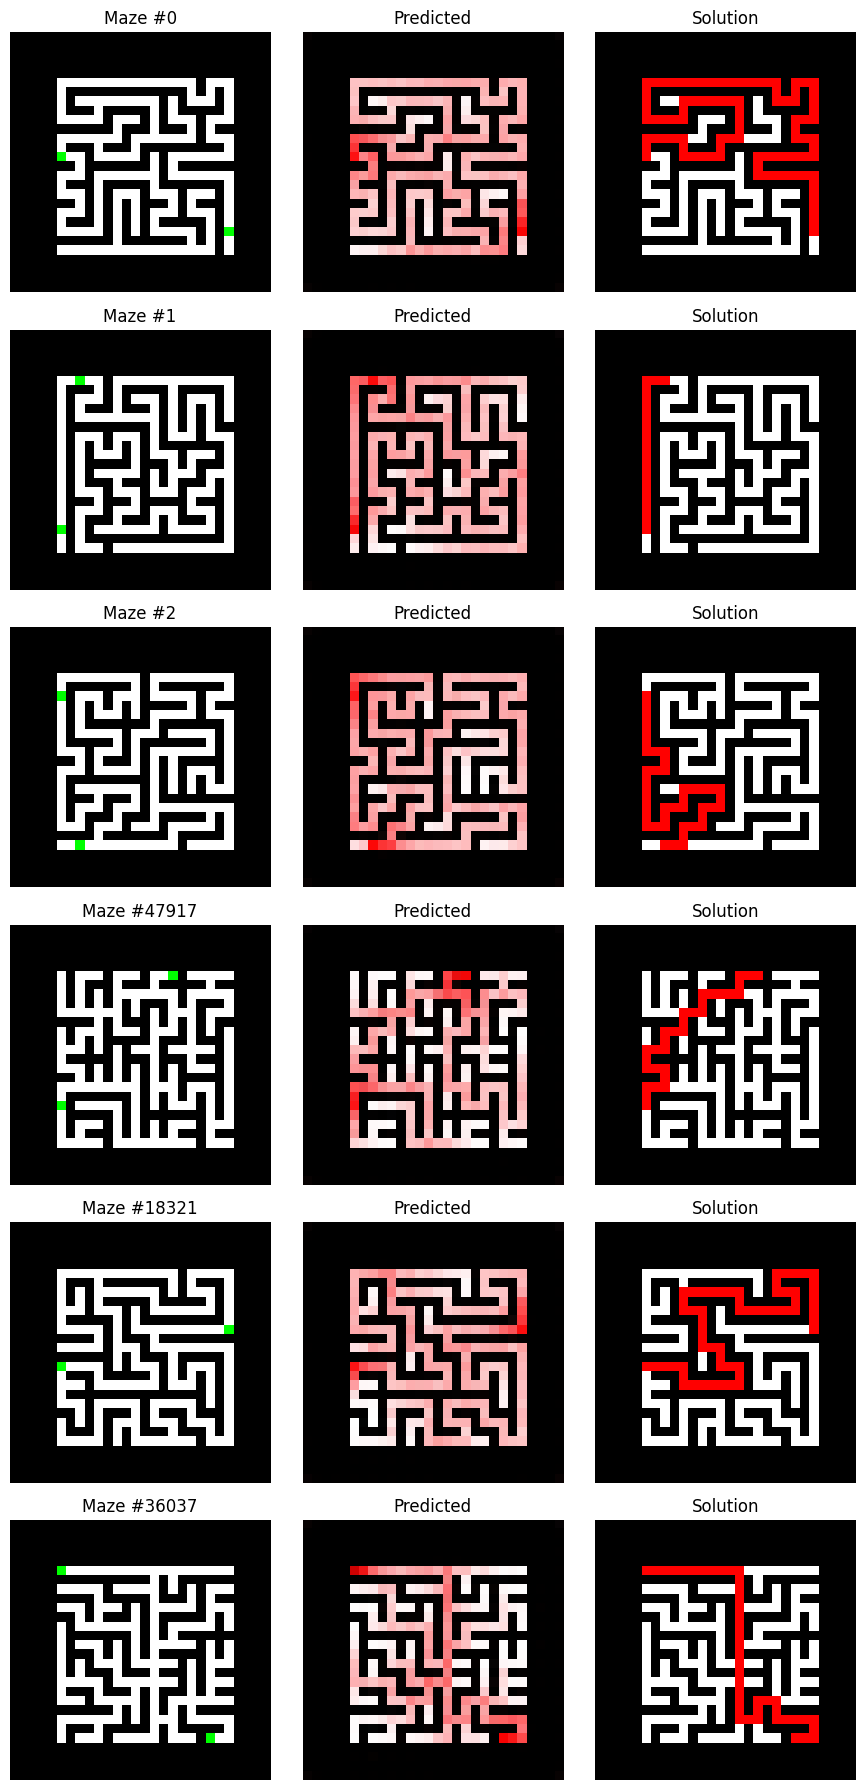

[Train] Epoch 4/70: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]


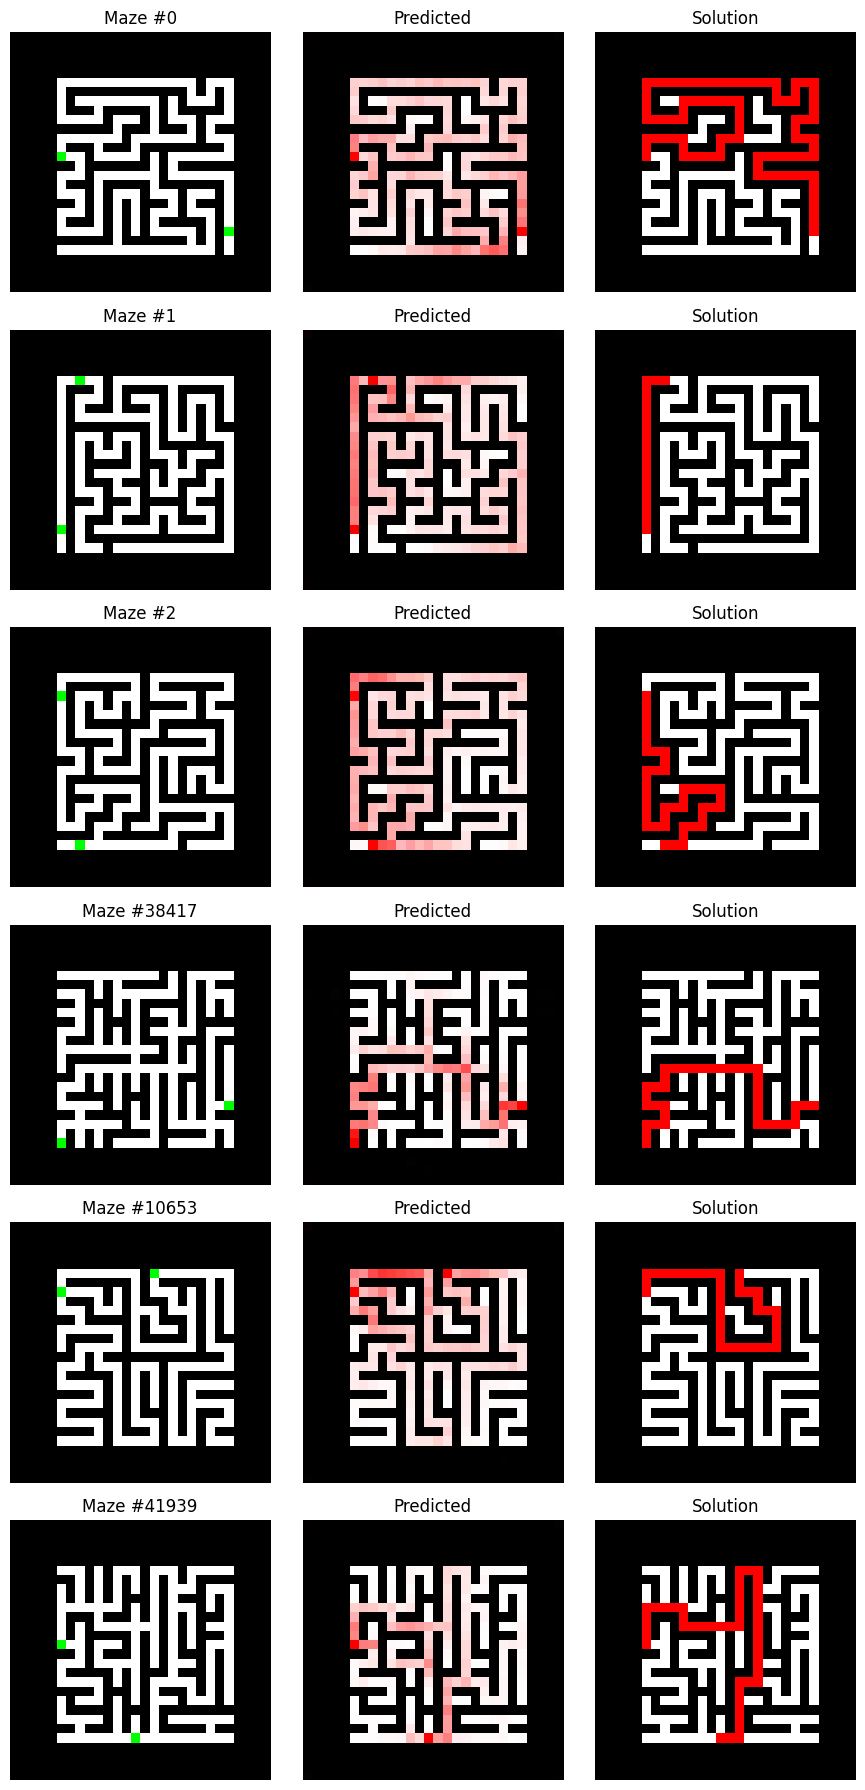

[Train] Epoch 5/70: 100%|██████████| 782/782 [01:48<00:00,  7.21it/s]


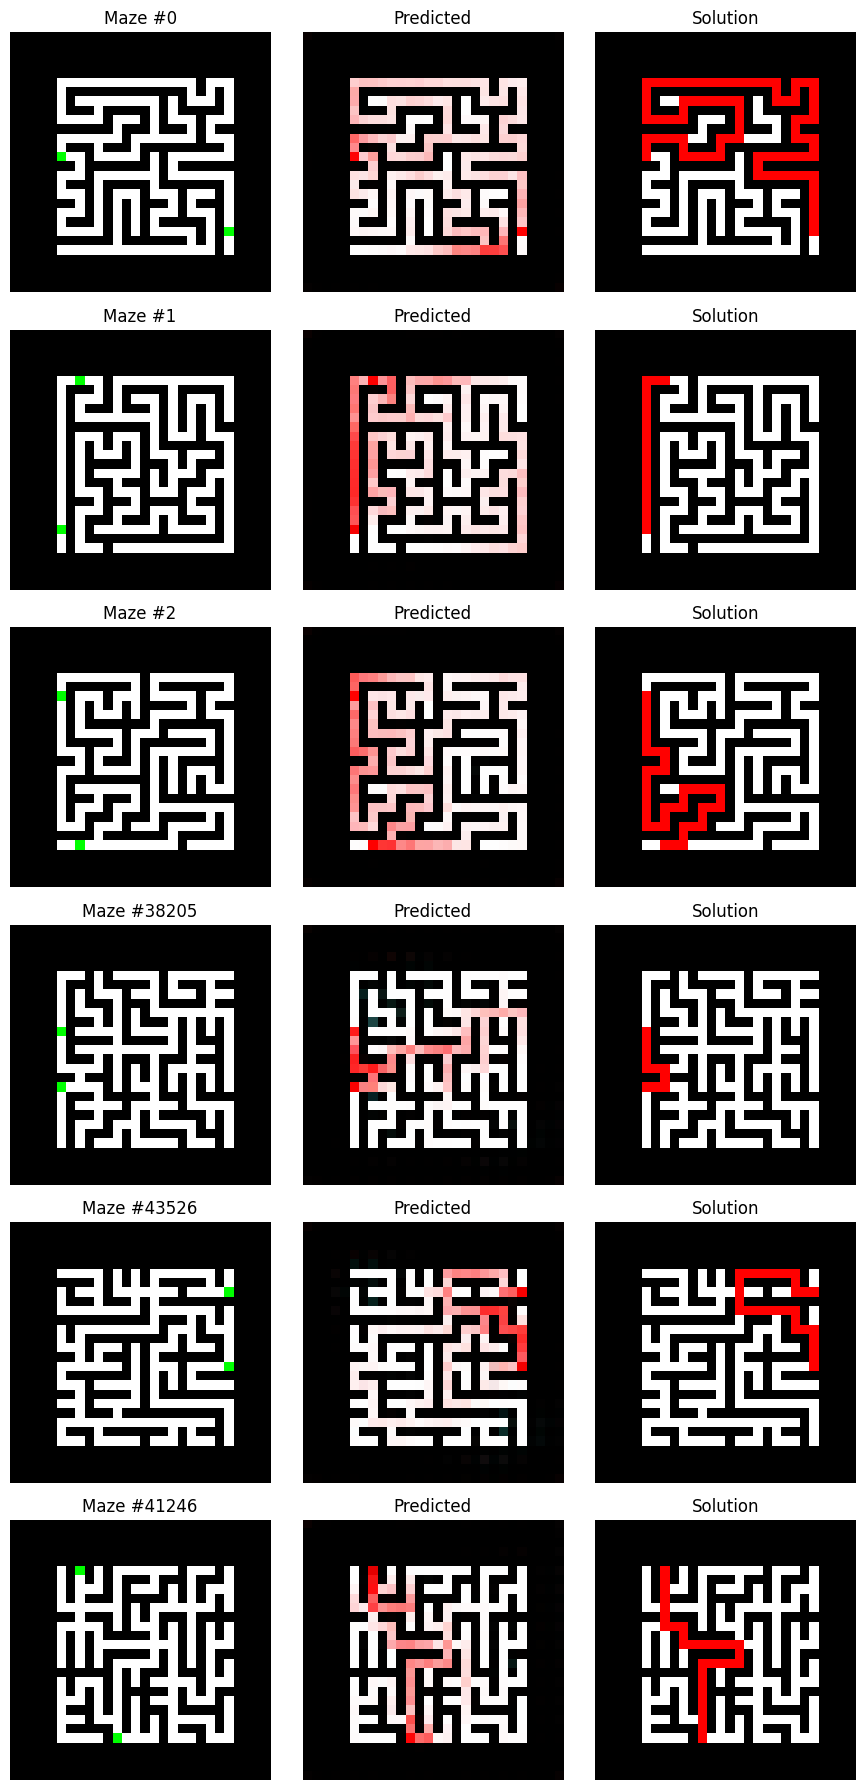

[Train] Epoch 6/70: 100%|██████████| 782/782 [01:48<00:00,  7.18it/s]


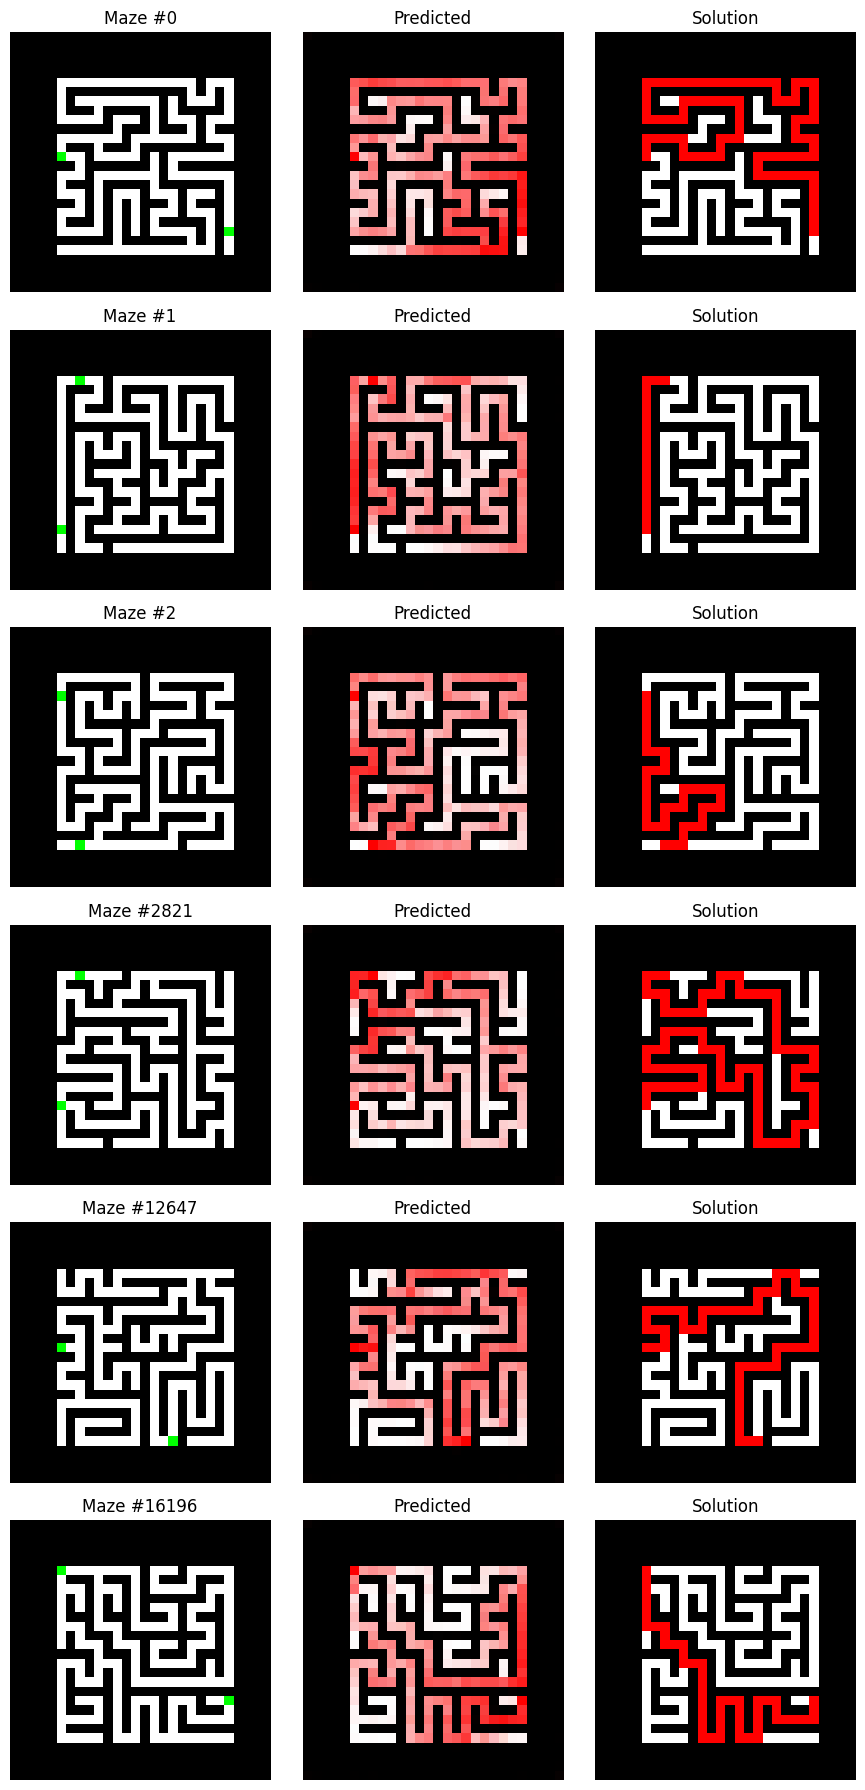

[Train] Epoch 7/70: 100%|██████████| 782/782 [01:47<00:00,  7.25it/s]


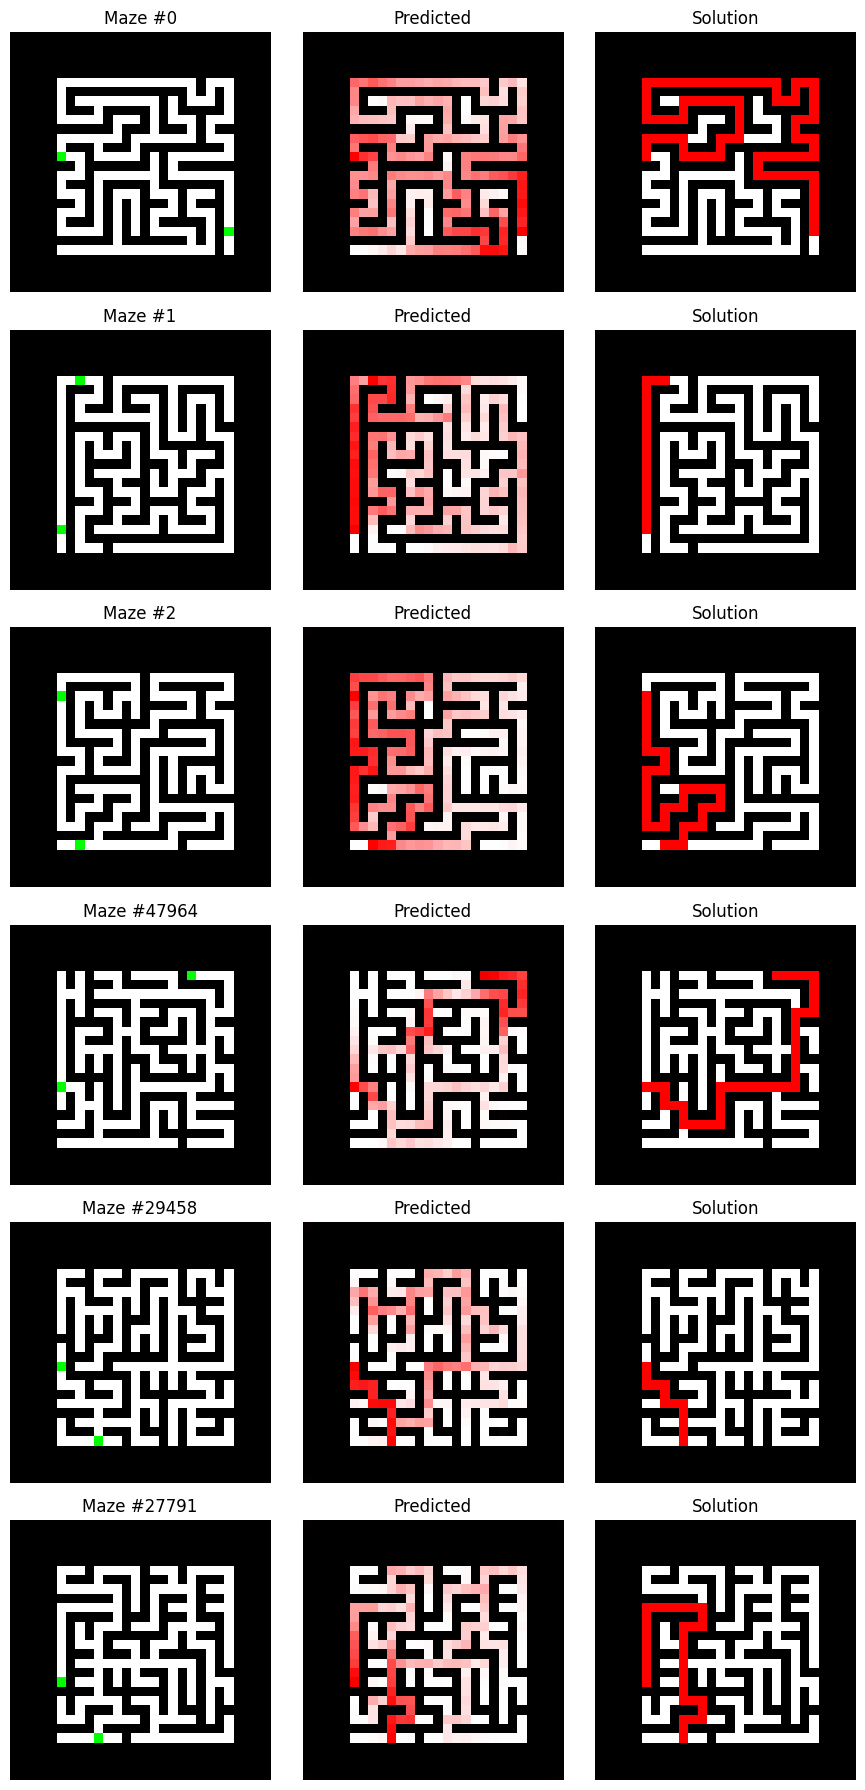

[Train] Epoch 8/70: 100%|██████████| 782/782 [01:47<00:00,  7.24it/s]


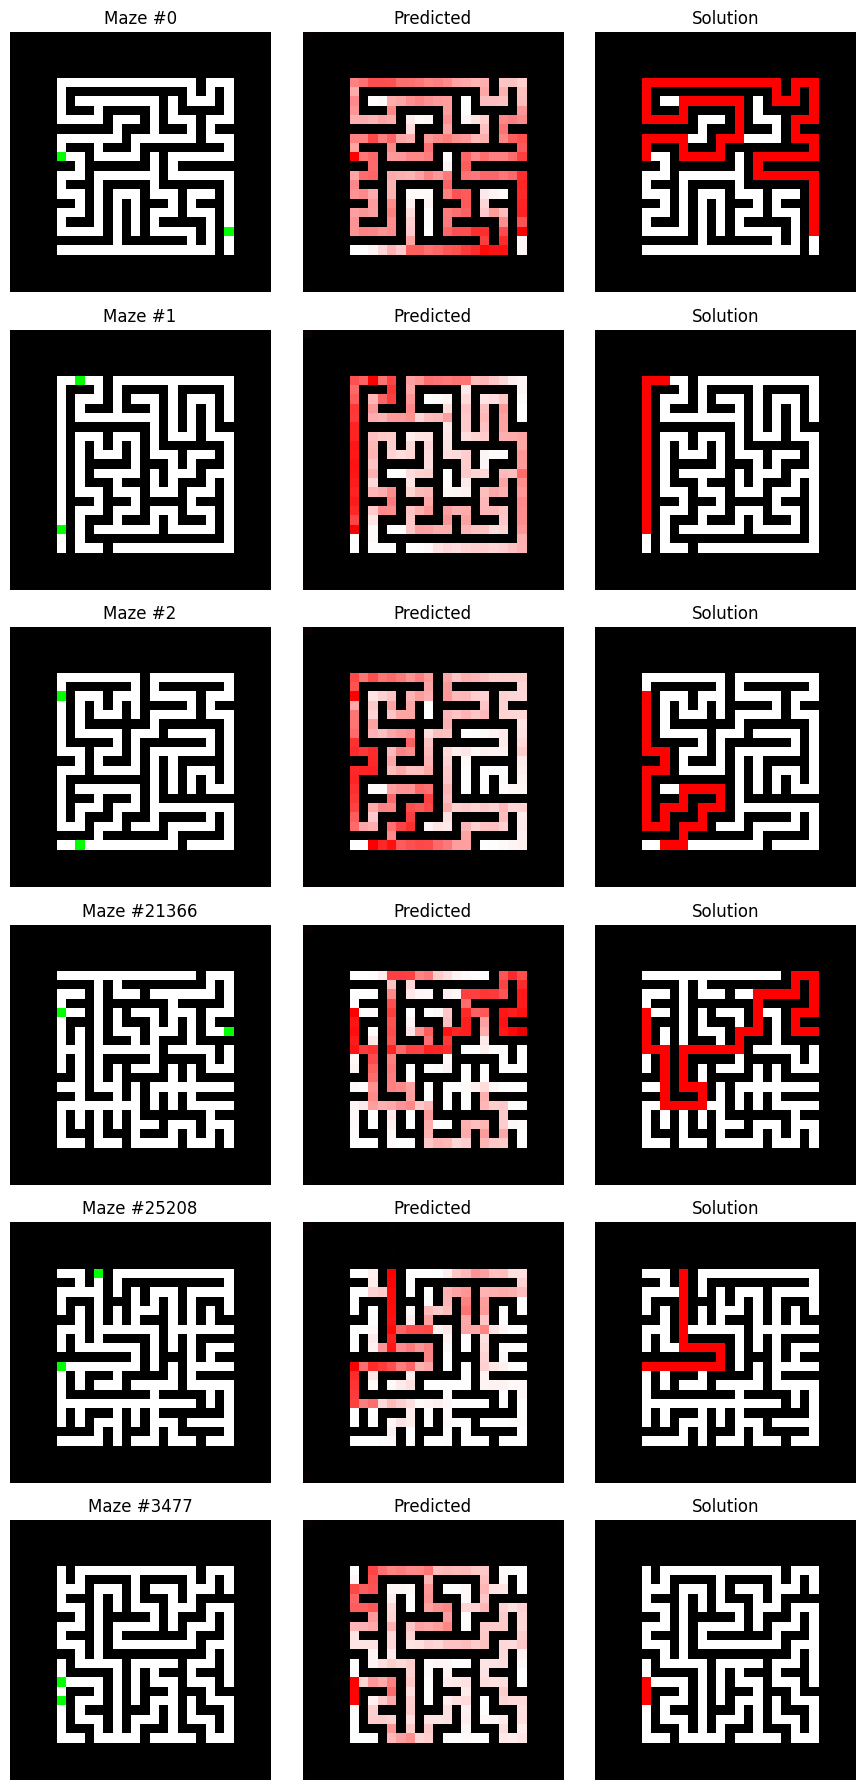

[Train] Epoch 9/70: 100%|██████████| 782/782 [01:50<00:00,  7.11it/s]


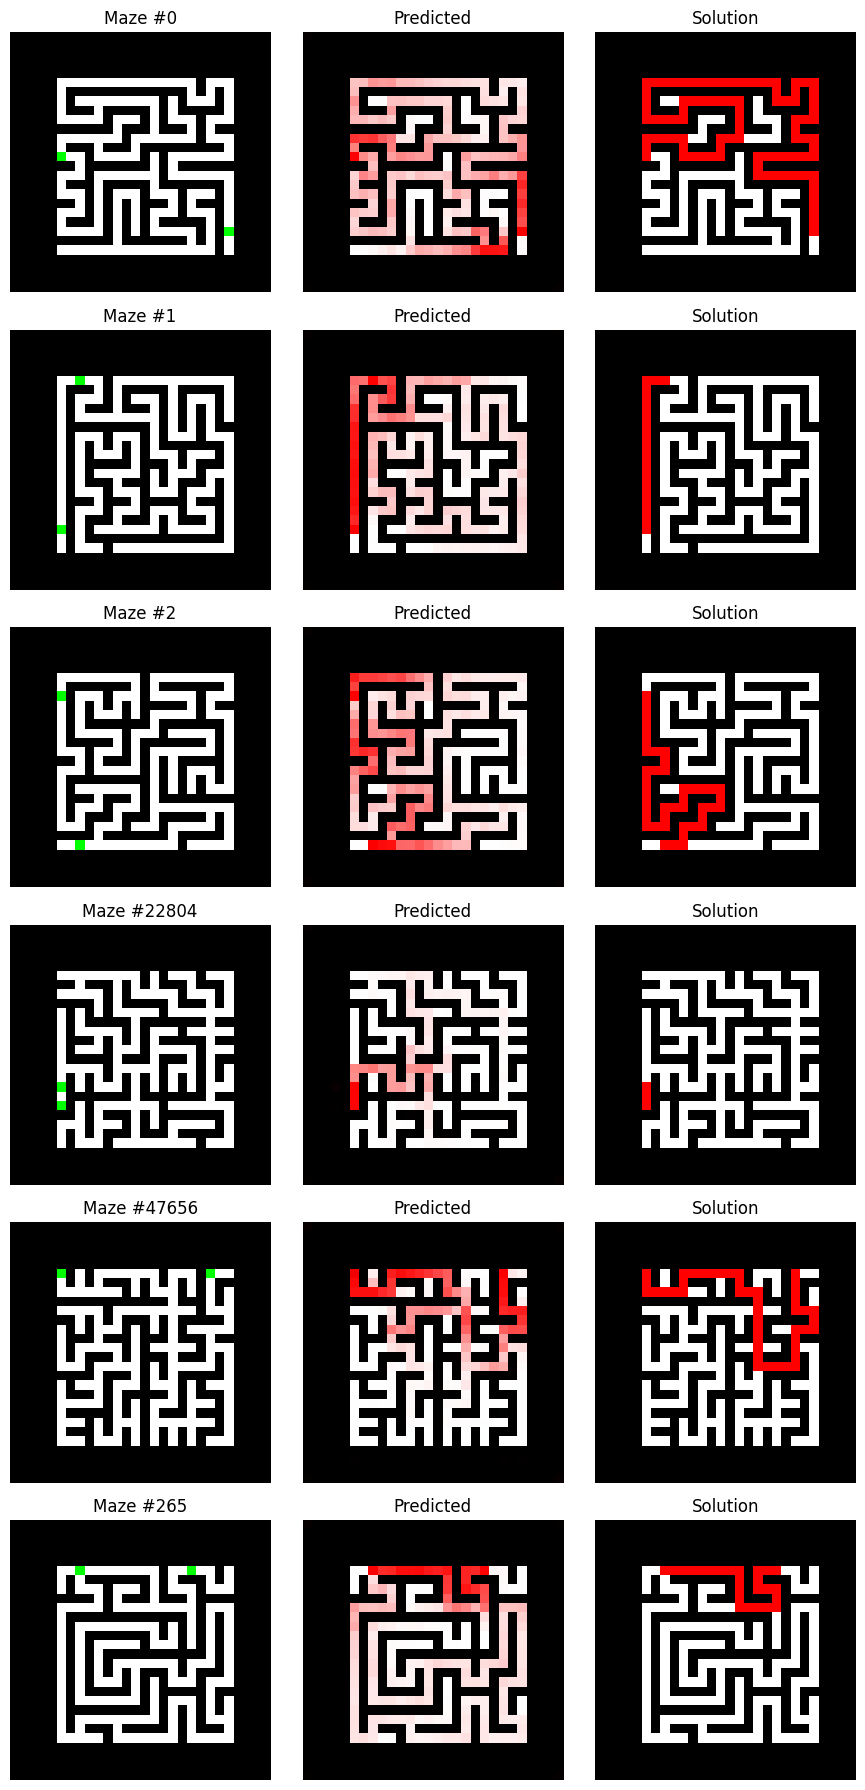

[Train] Epoch 10/70: 100%|██████████| 782/782 [01:53<00:00,  6.87it/s]


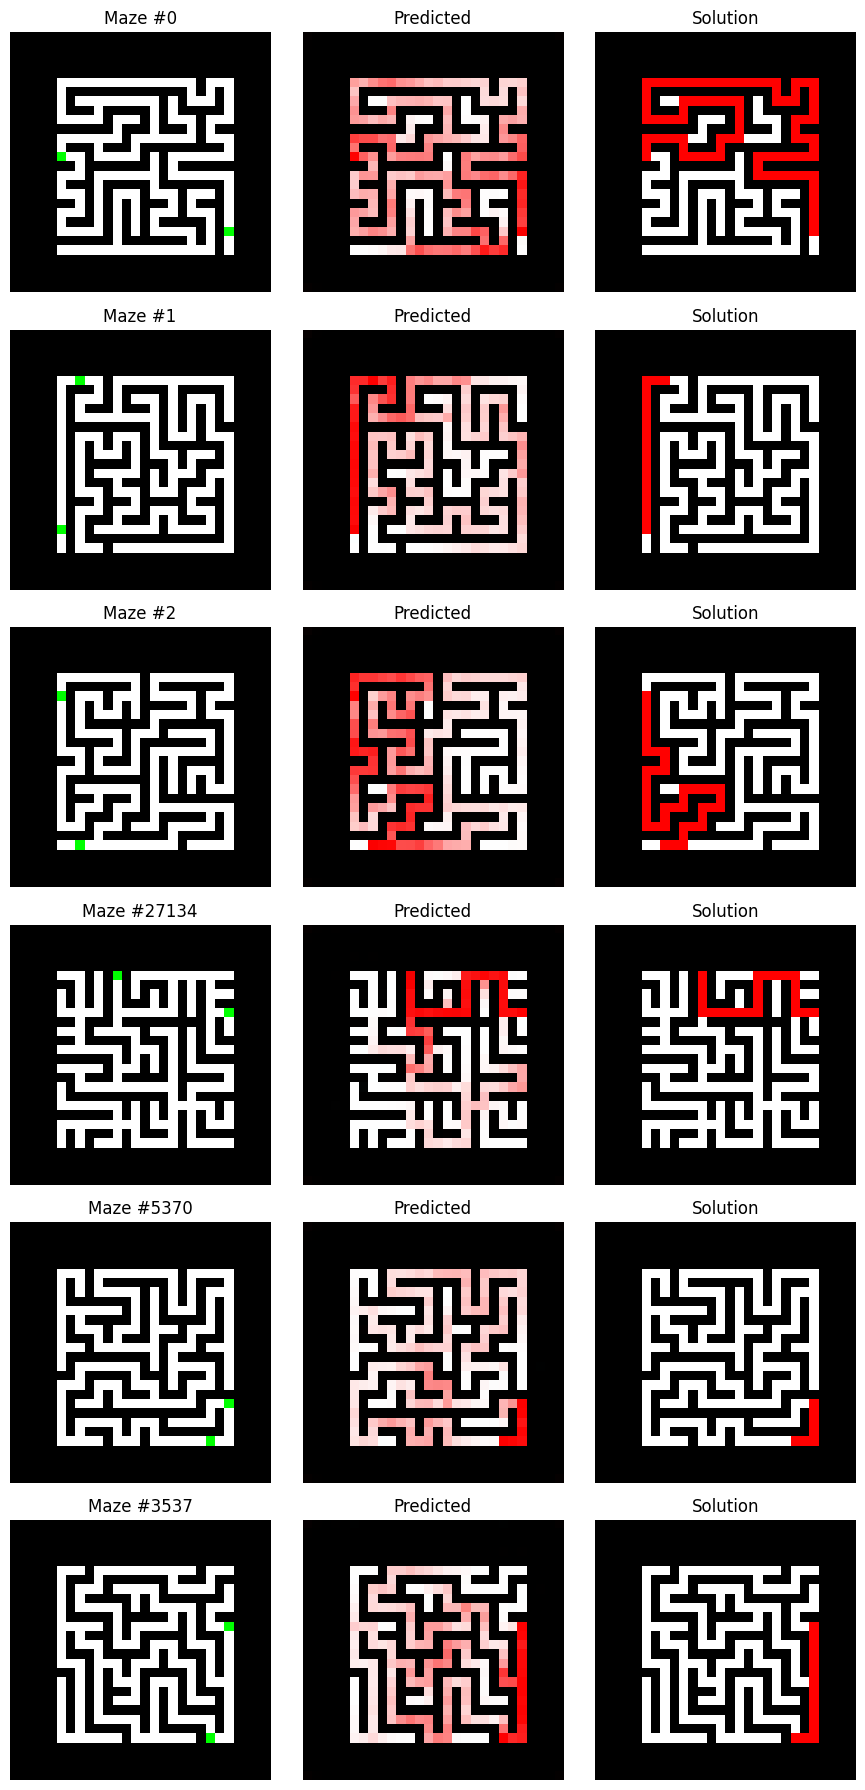

[Train] Epoch 11/70: 100%|██████████| 782/782 [01:53<00:00,  6.88it/s]


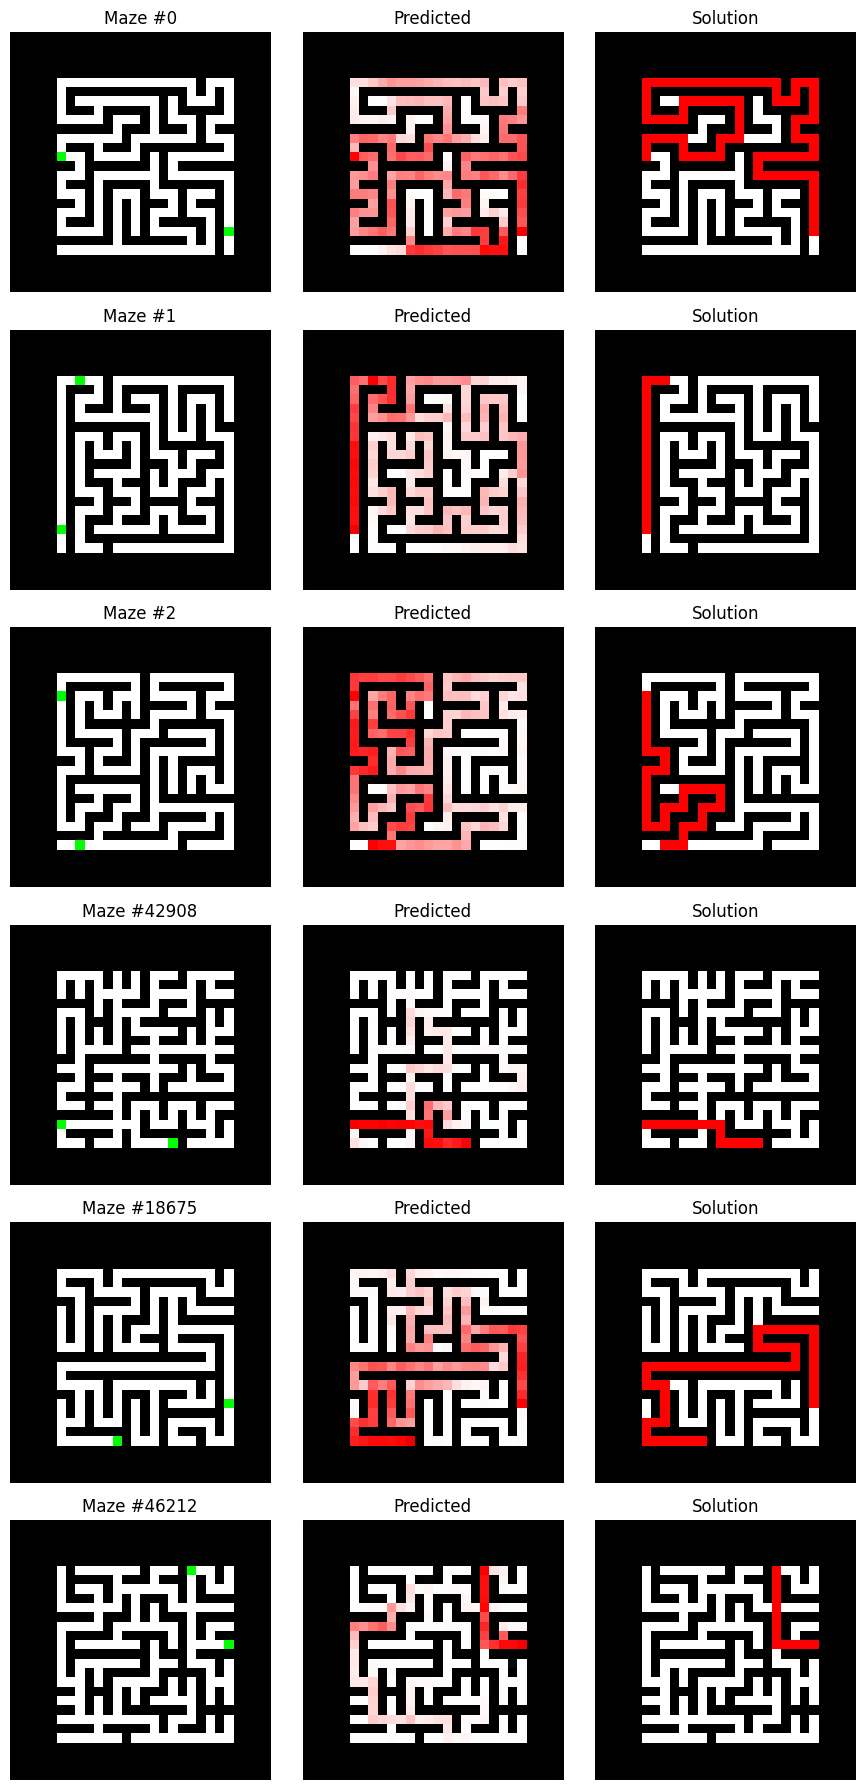

[Train] Epoch 12/70: 100%|██████████| 782/782 [01:51<00:00,  7.02it/s]


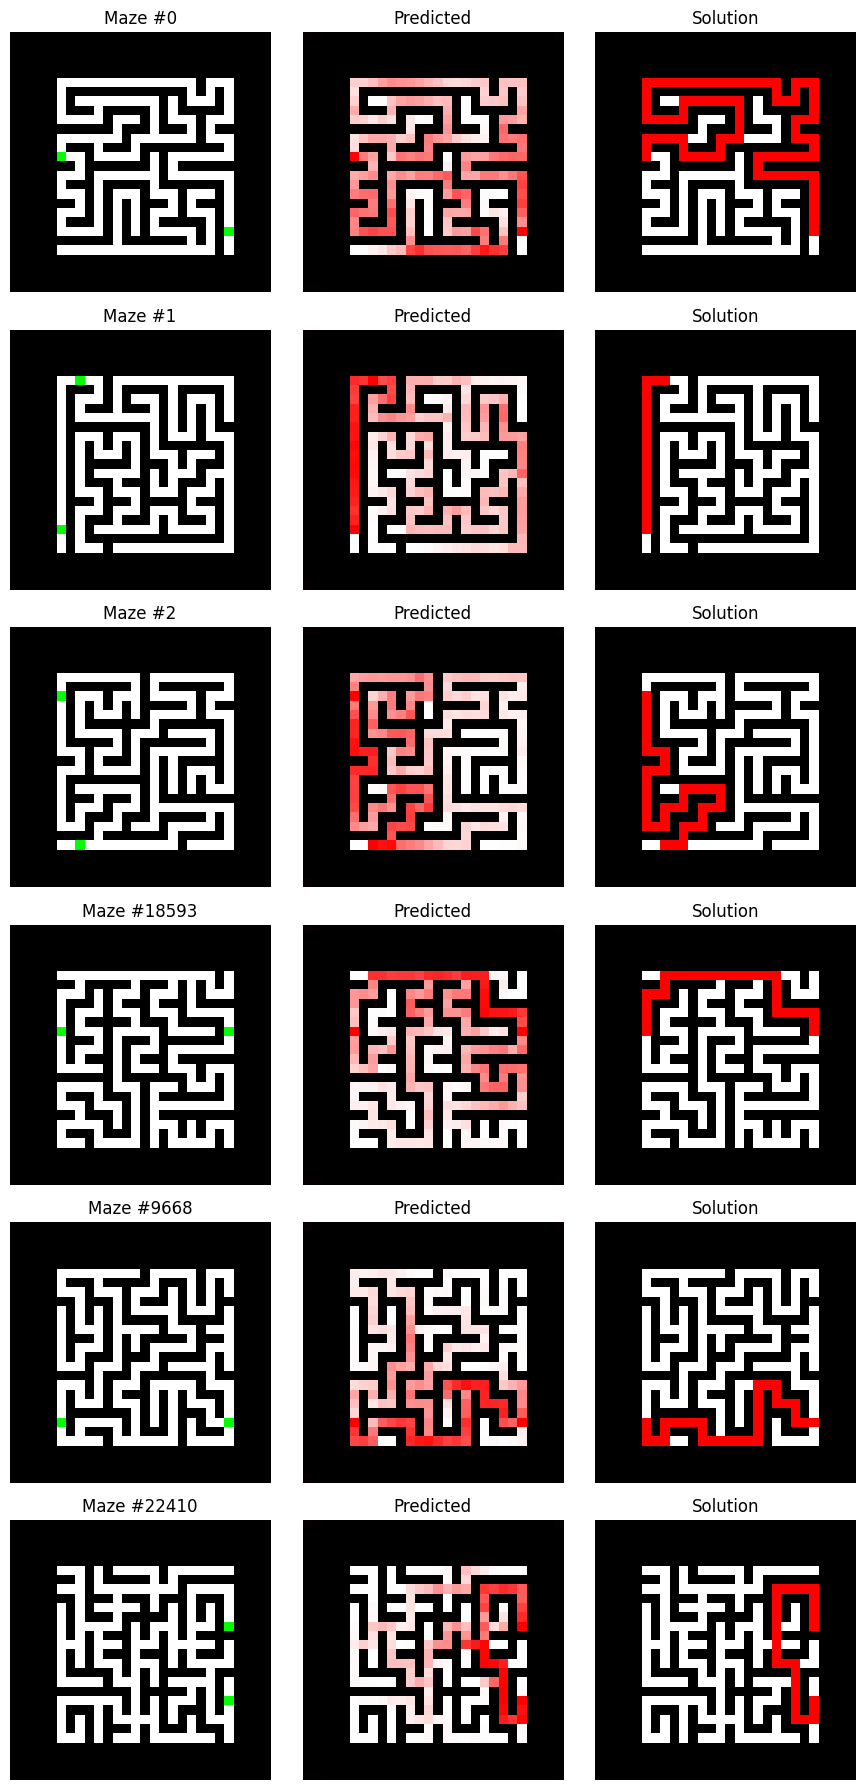

[Train] Epoch 13/70: 100%|██████████| 782/782 [01:51<00:00,  7.00it/s]


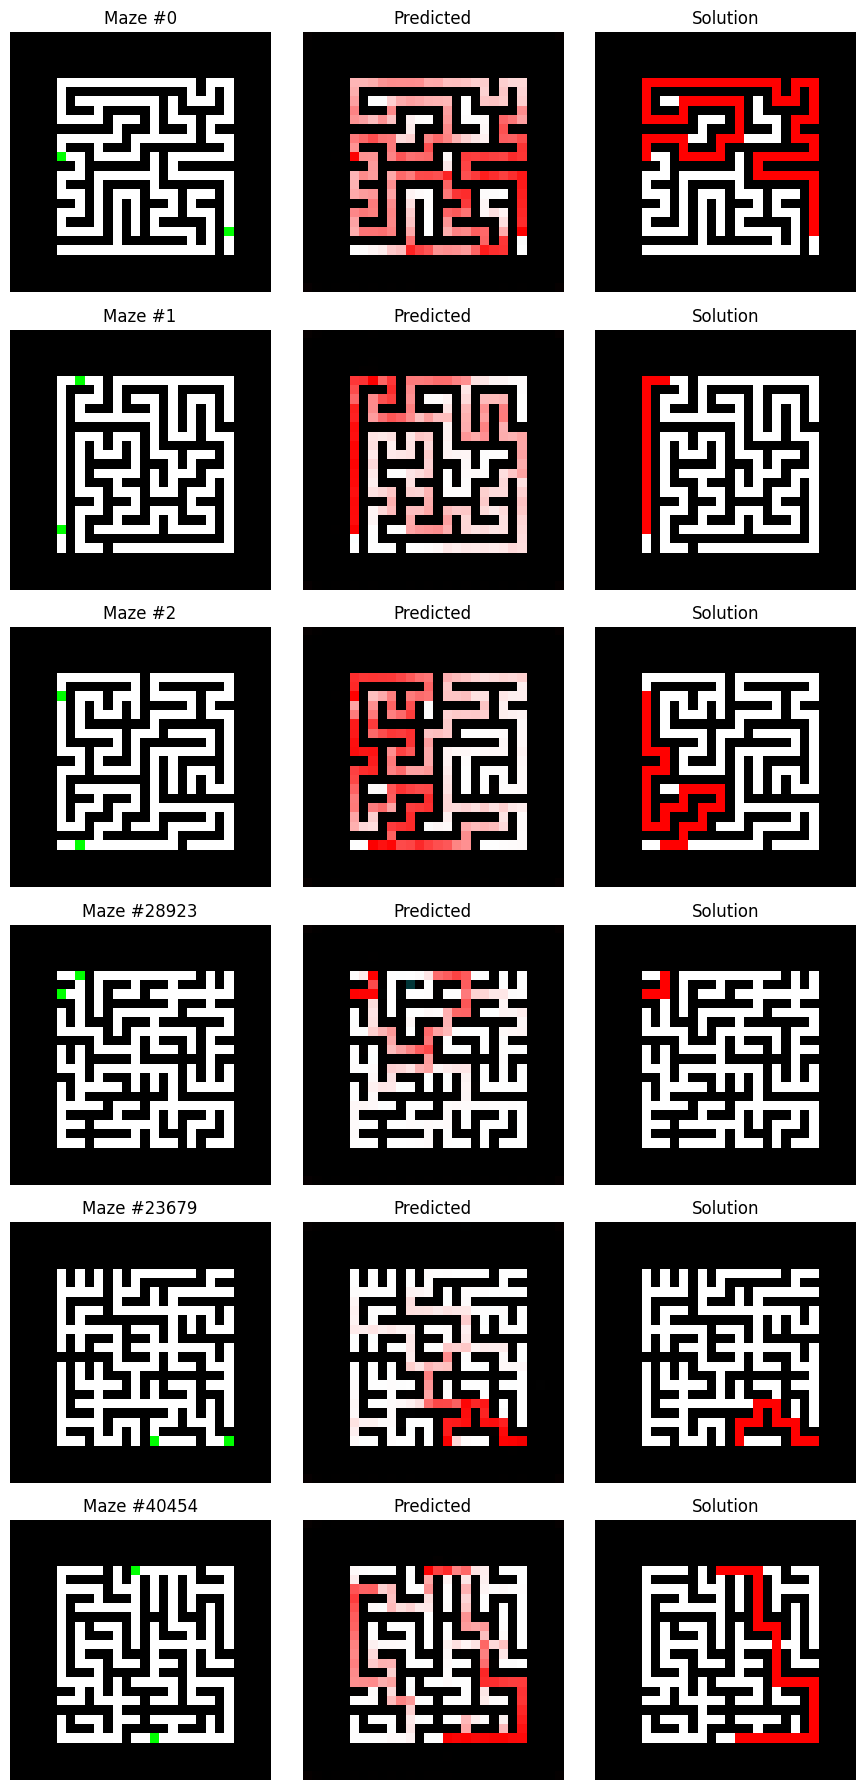

[Train] Epoch 14/70: 100%|██████████| 782/782 [01:54<00:00,  6.84it/s]


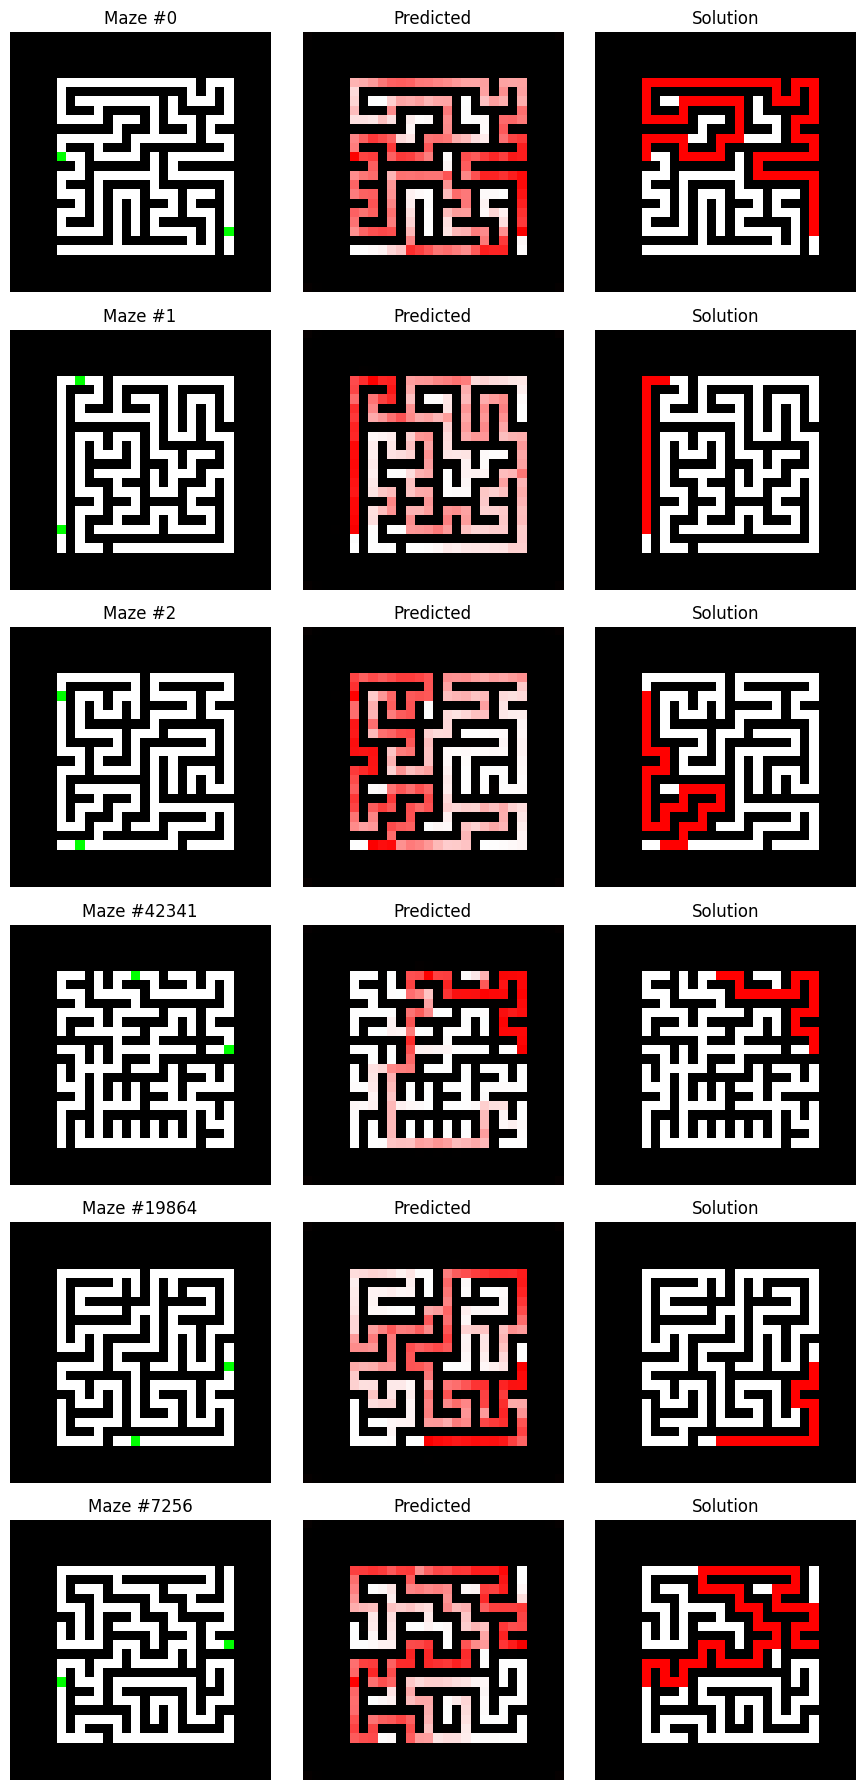

[Train] Epoch 15/70: 100%|██████████| 782/782 [01:52<00:00,  6.98it/s]


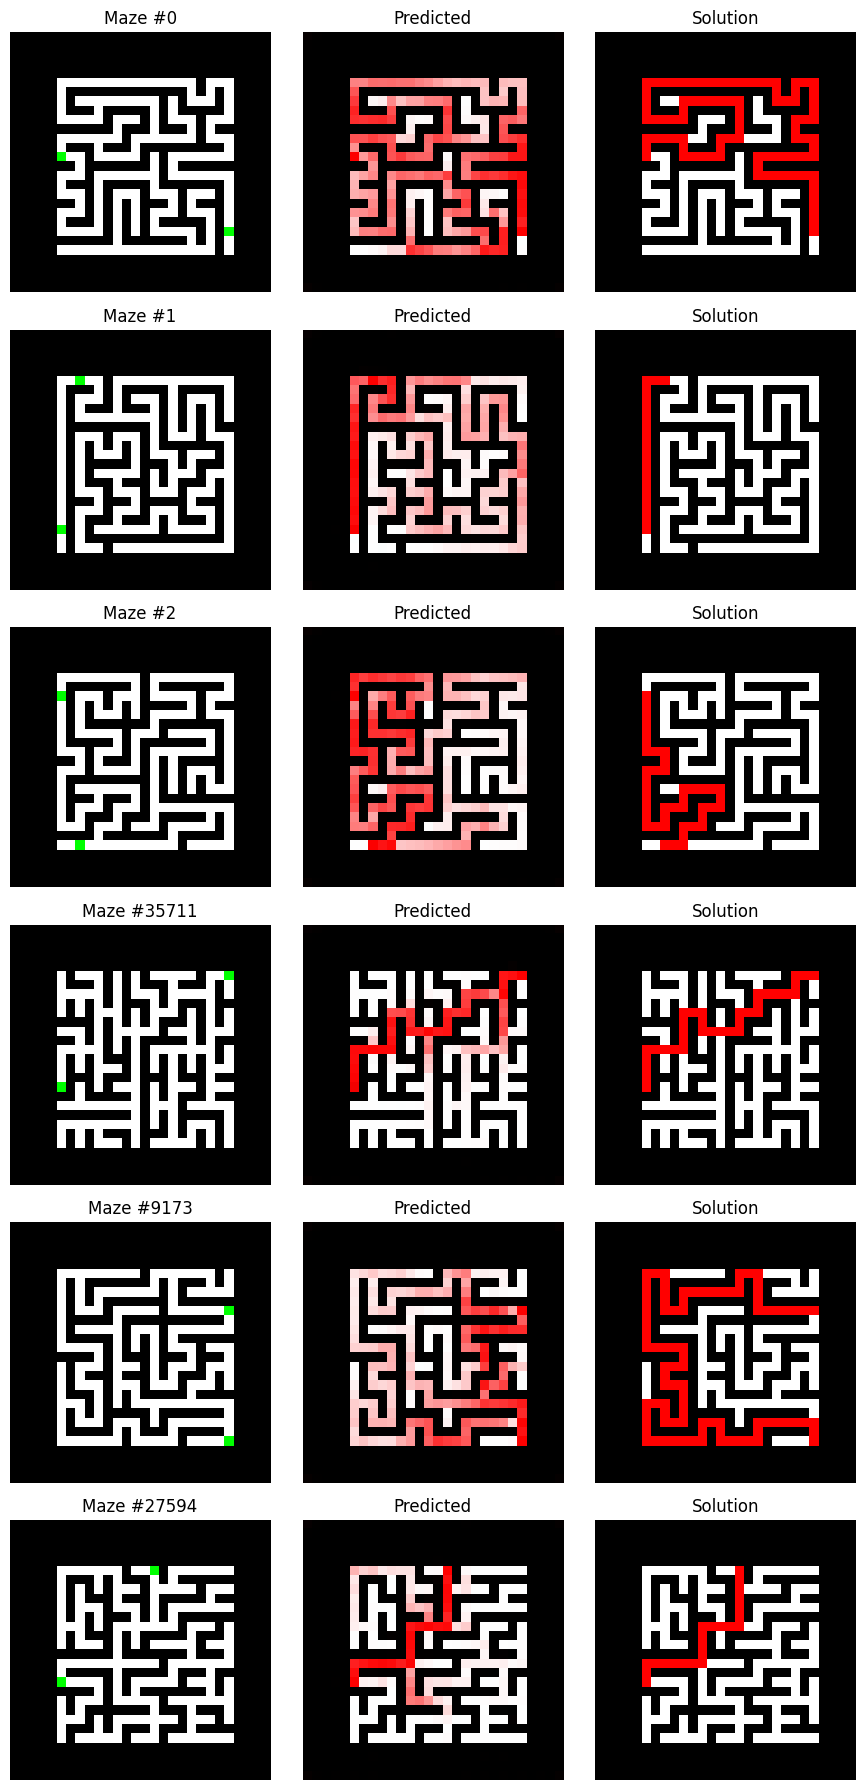

[Train] Epoch 16/70: 100%|██████████| 782/782 [01:51<00:00,  6.99it/s]


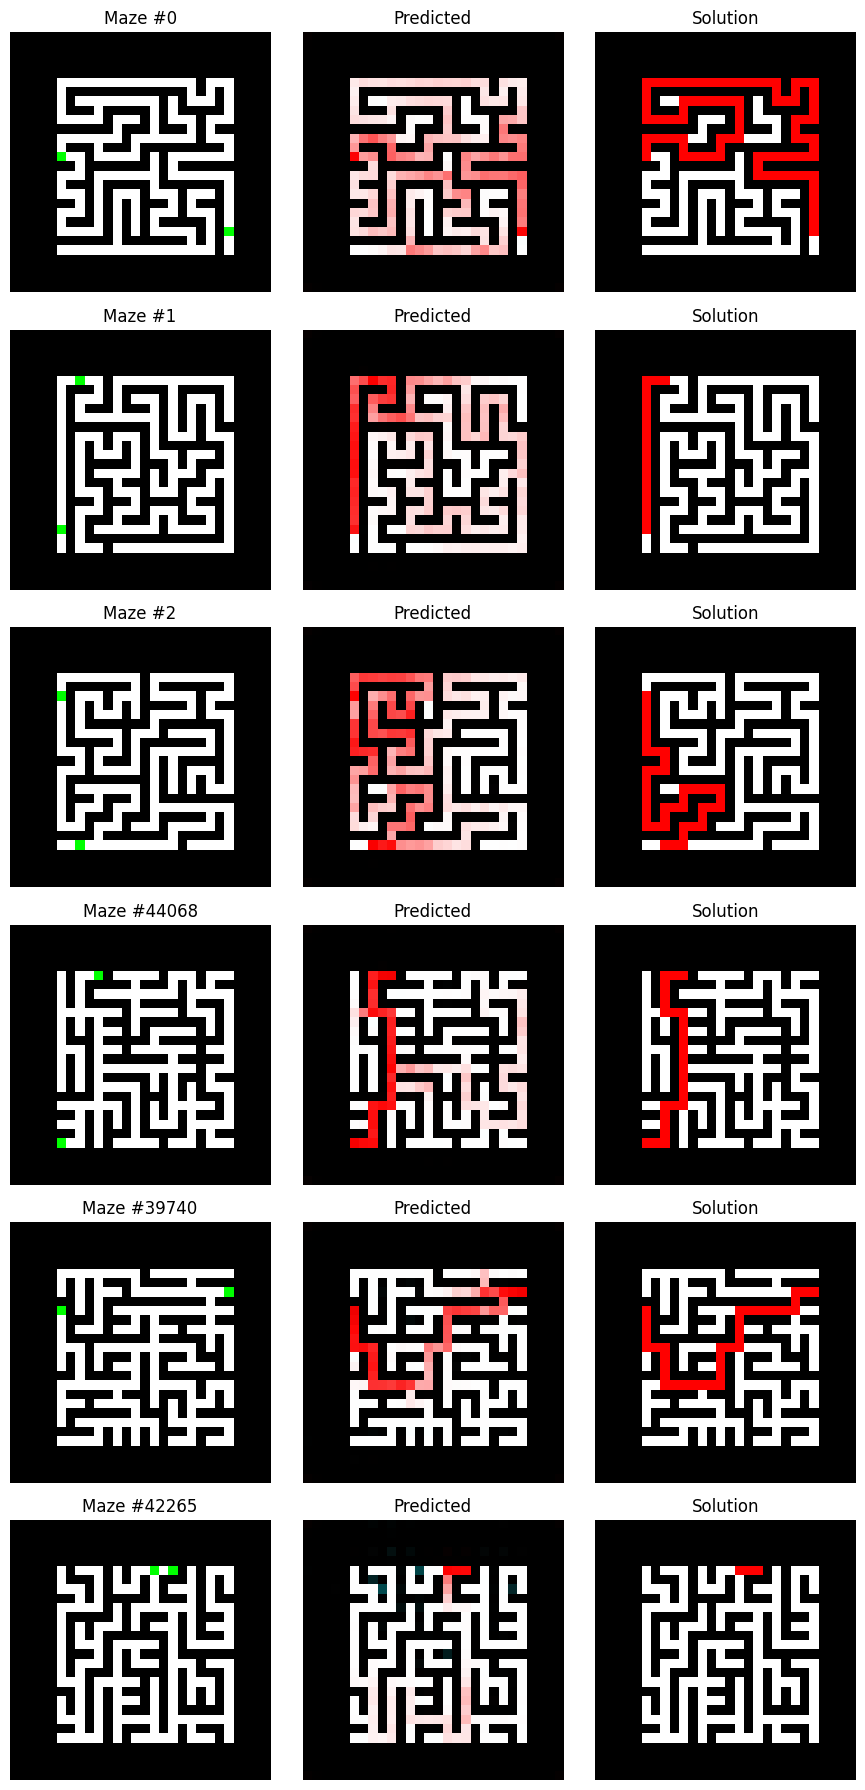

[Train] Epoch 17/70: 100%|██████████| 782/782 [01:50<00:00,  7.05it/s]


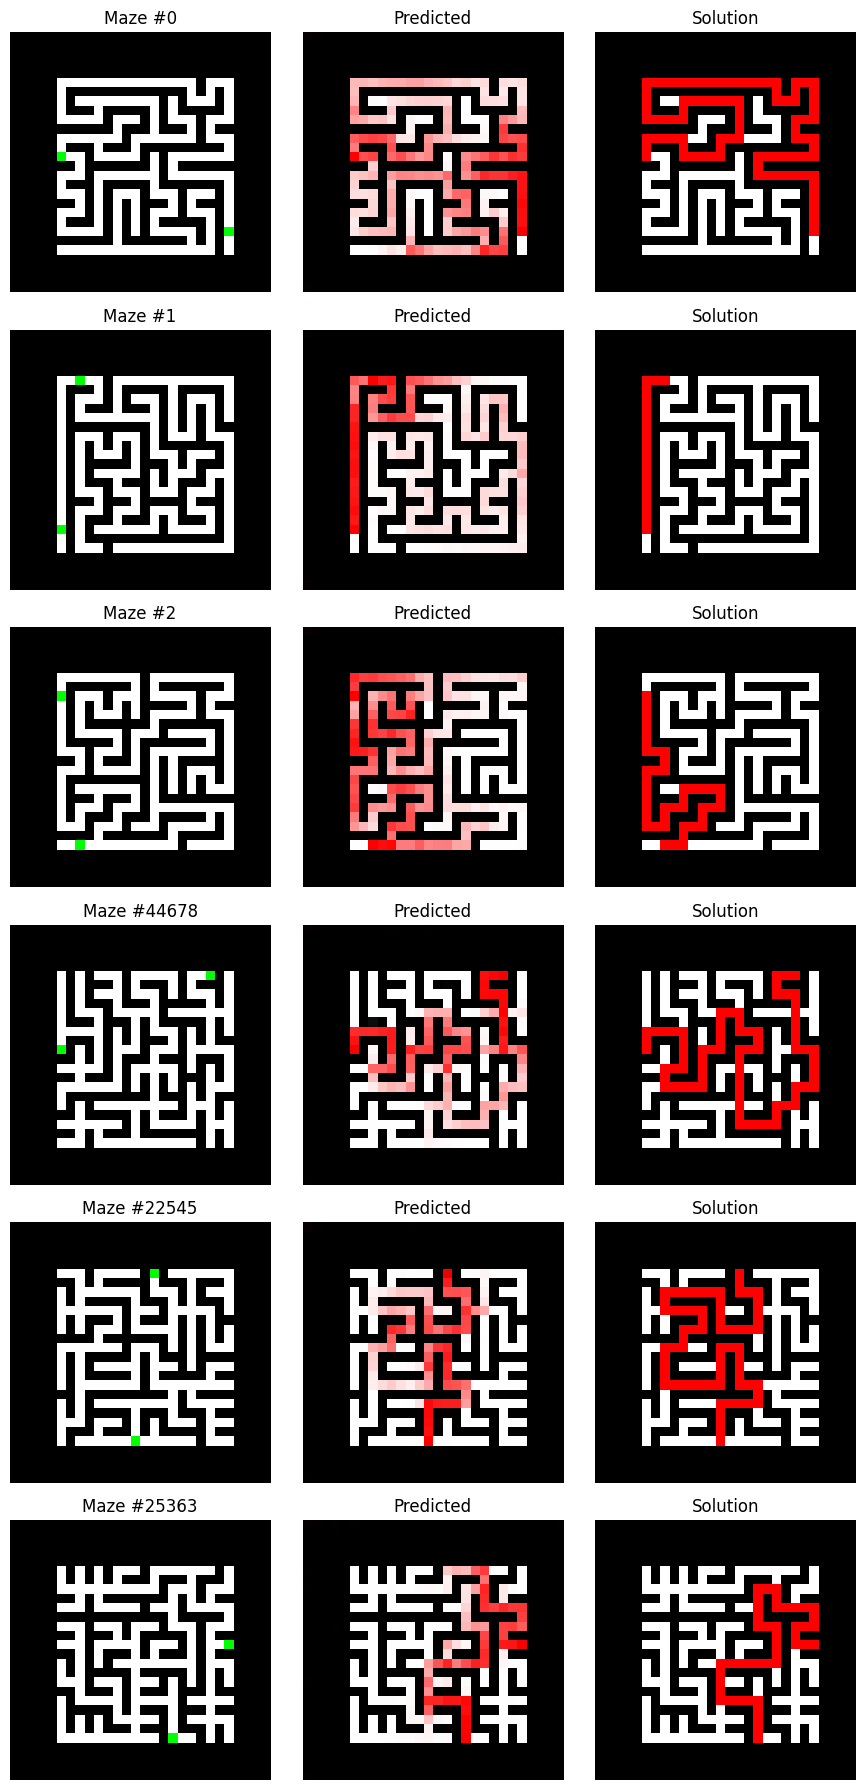

[Train] Epoch 18/70: 100%|██████████| 782/782 [01:50<00:00,  7.05it/s]


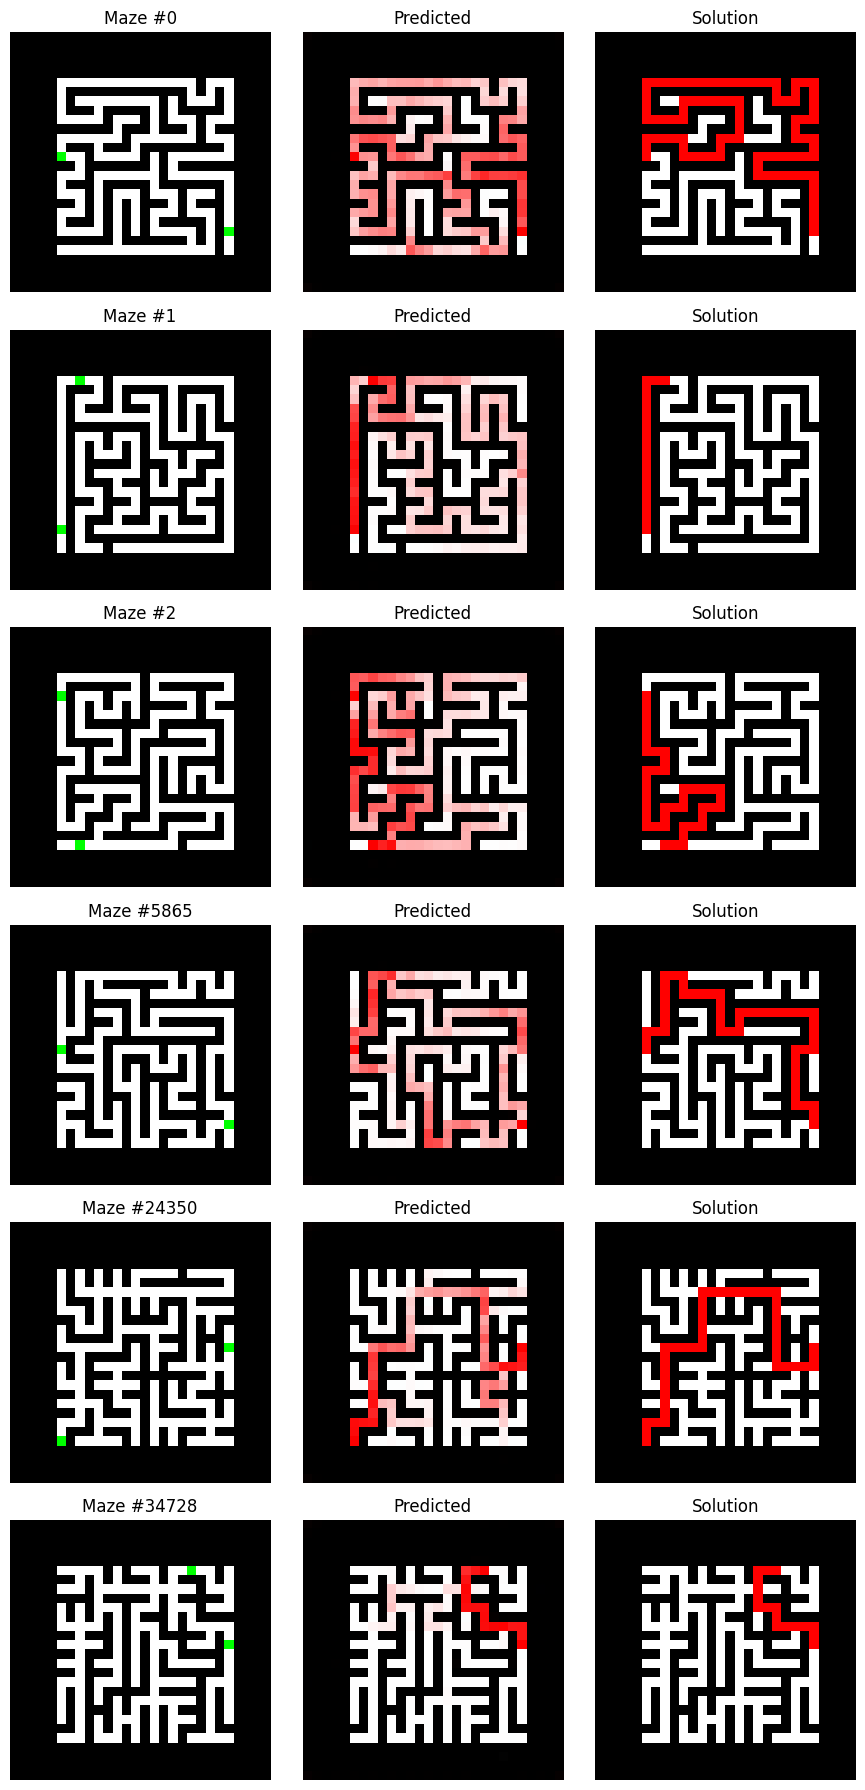

[Train] Epoch 19/70: 100%|██████████| 782/782 [01:52<00:00,  6.92it/s]


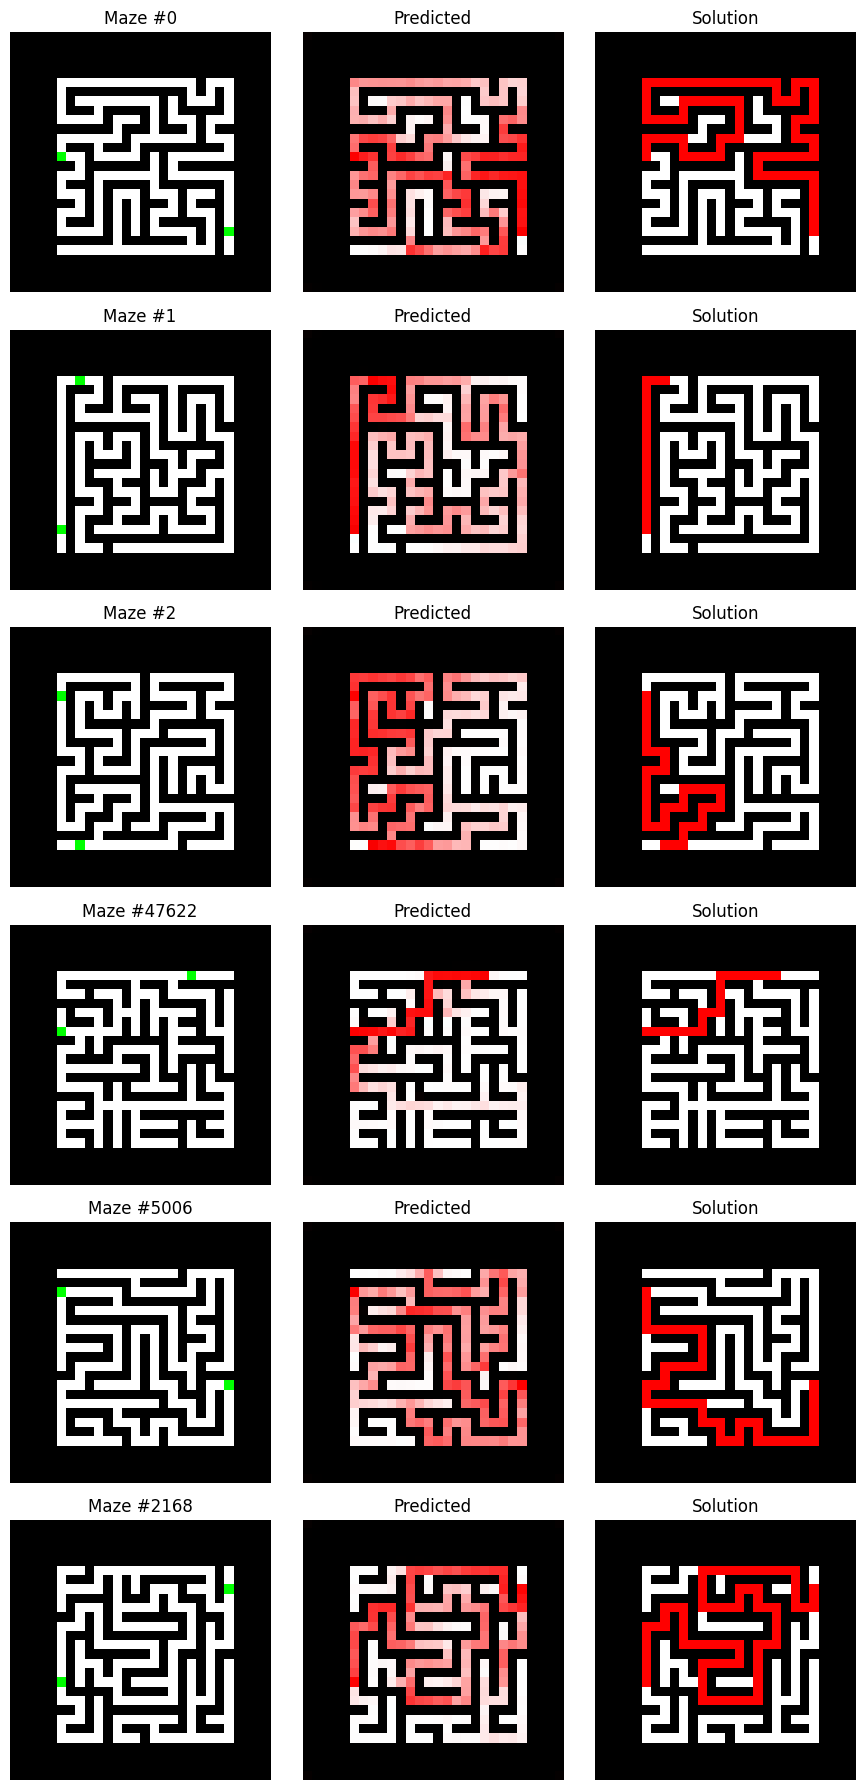

[Train] Epoch 20/70: 100%|██████████| 782/782 [01:50<00:00,  7.09it/s]


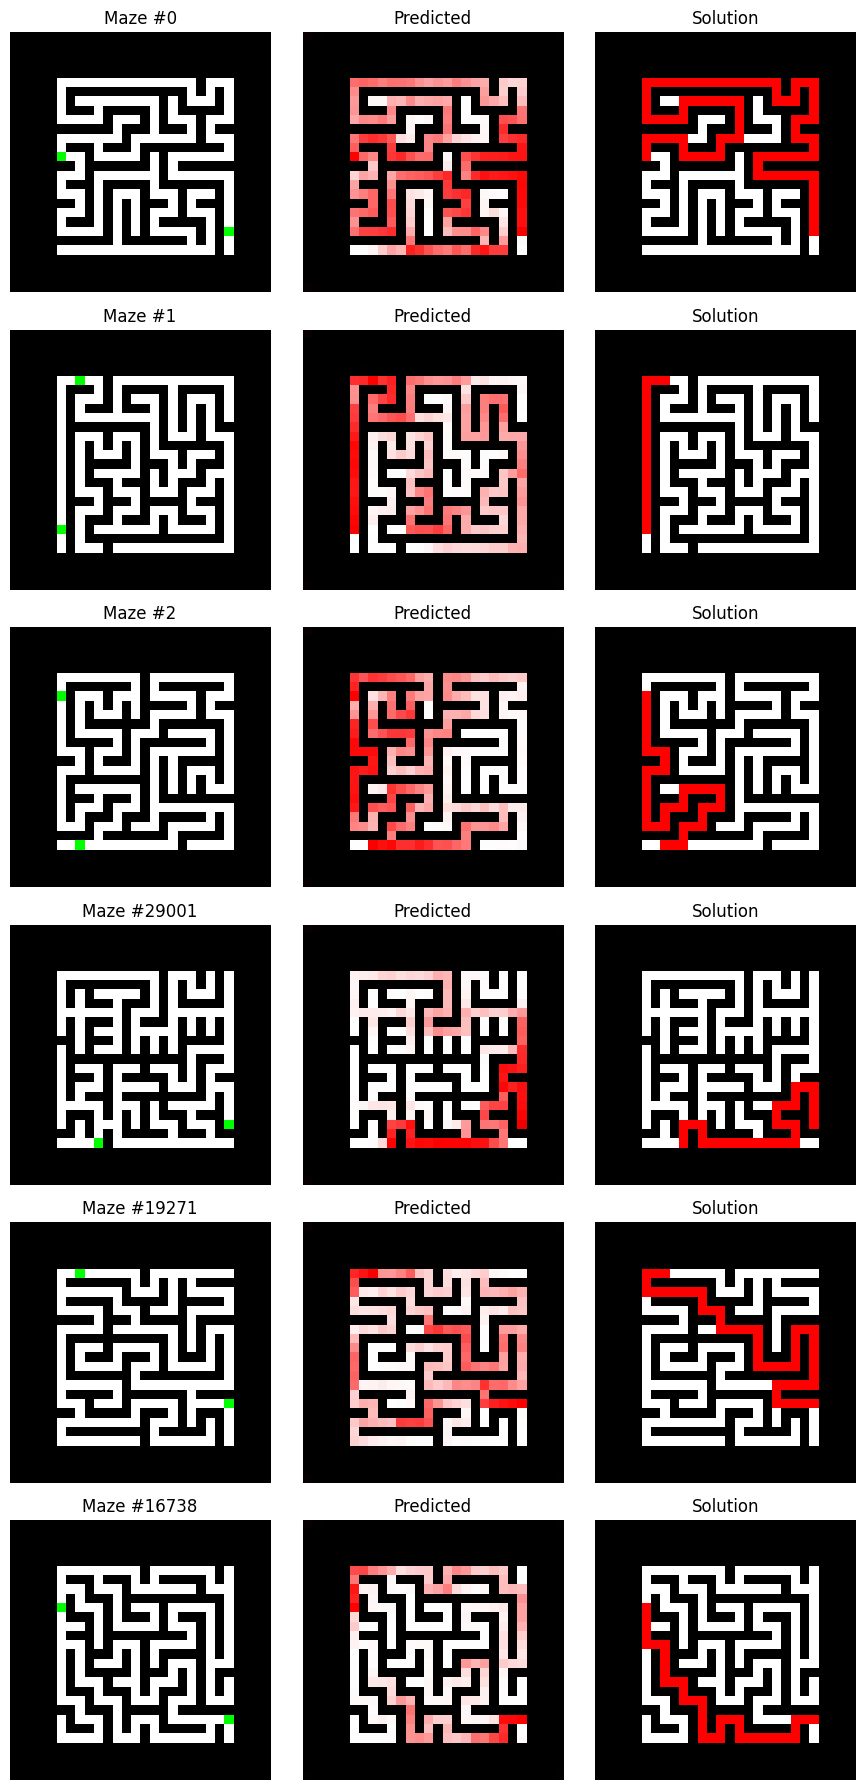

[Train] Epoch 21/70: 100%|██████████| 782/782 [01:53<00:00,  6.90it/s]


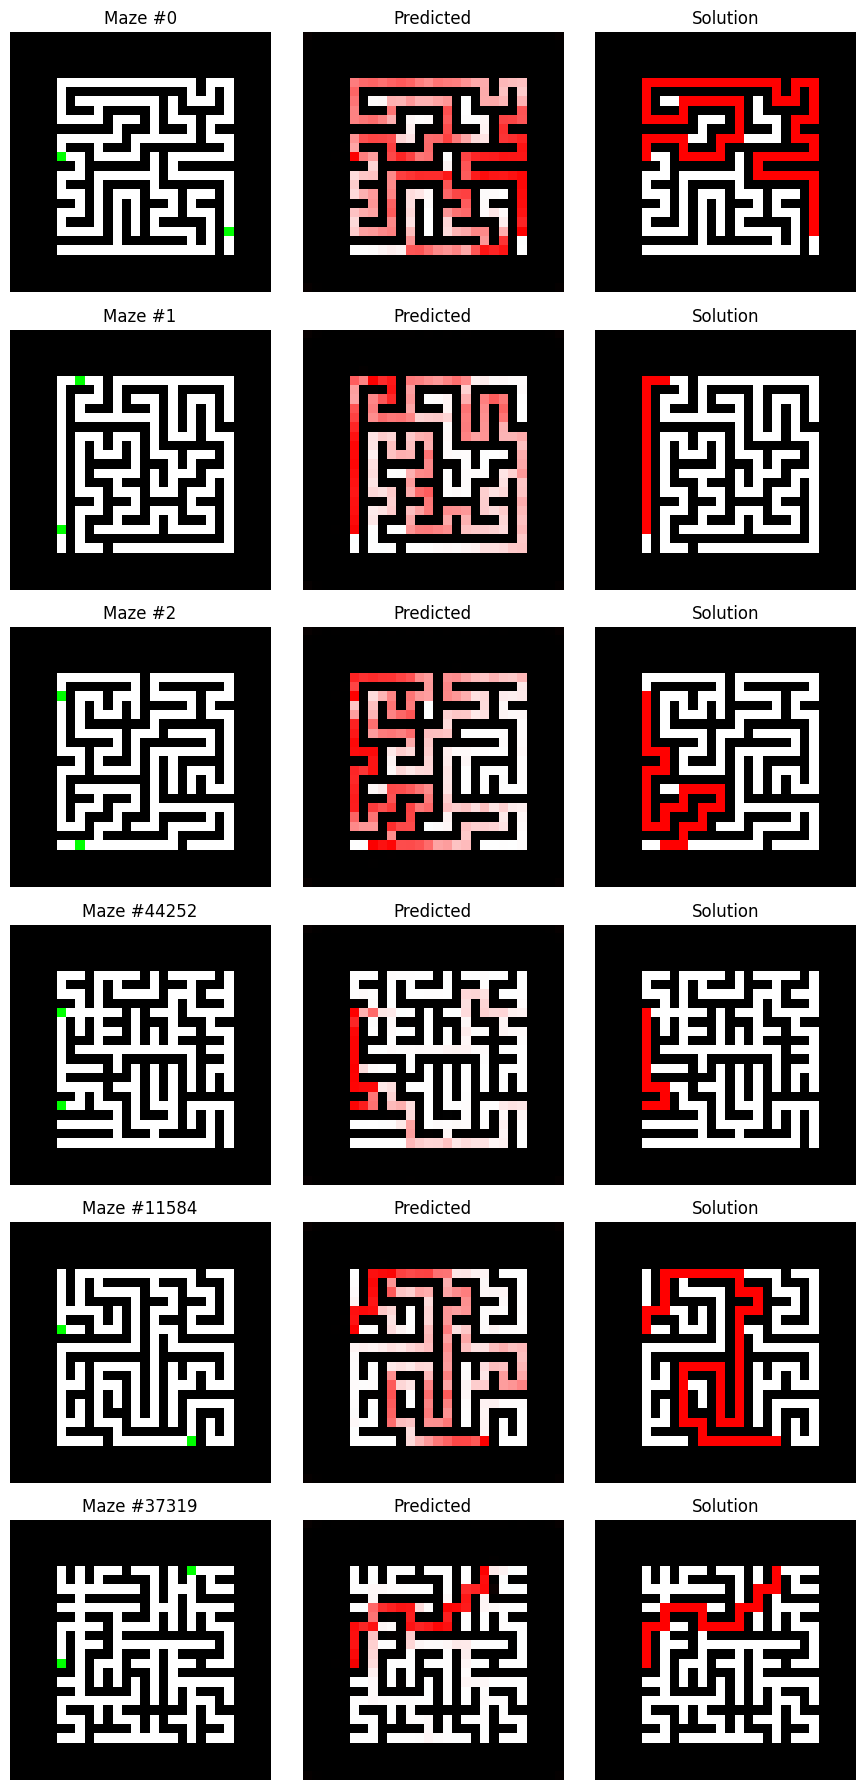

[Train] Epoch 22/70: 100%|██████████| 782/782 [01:57<00:00,  6.65it/s]


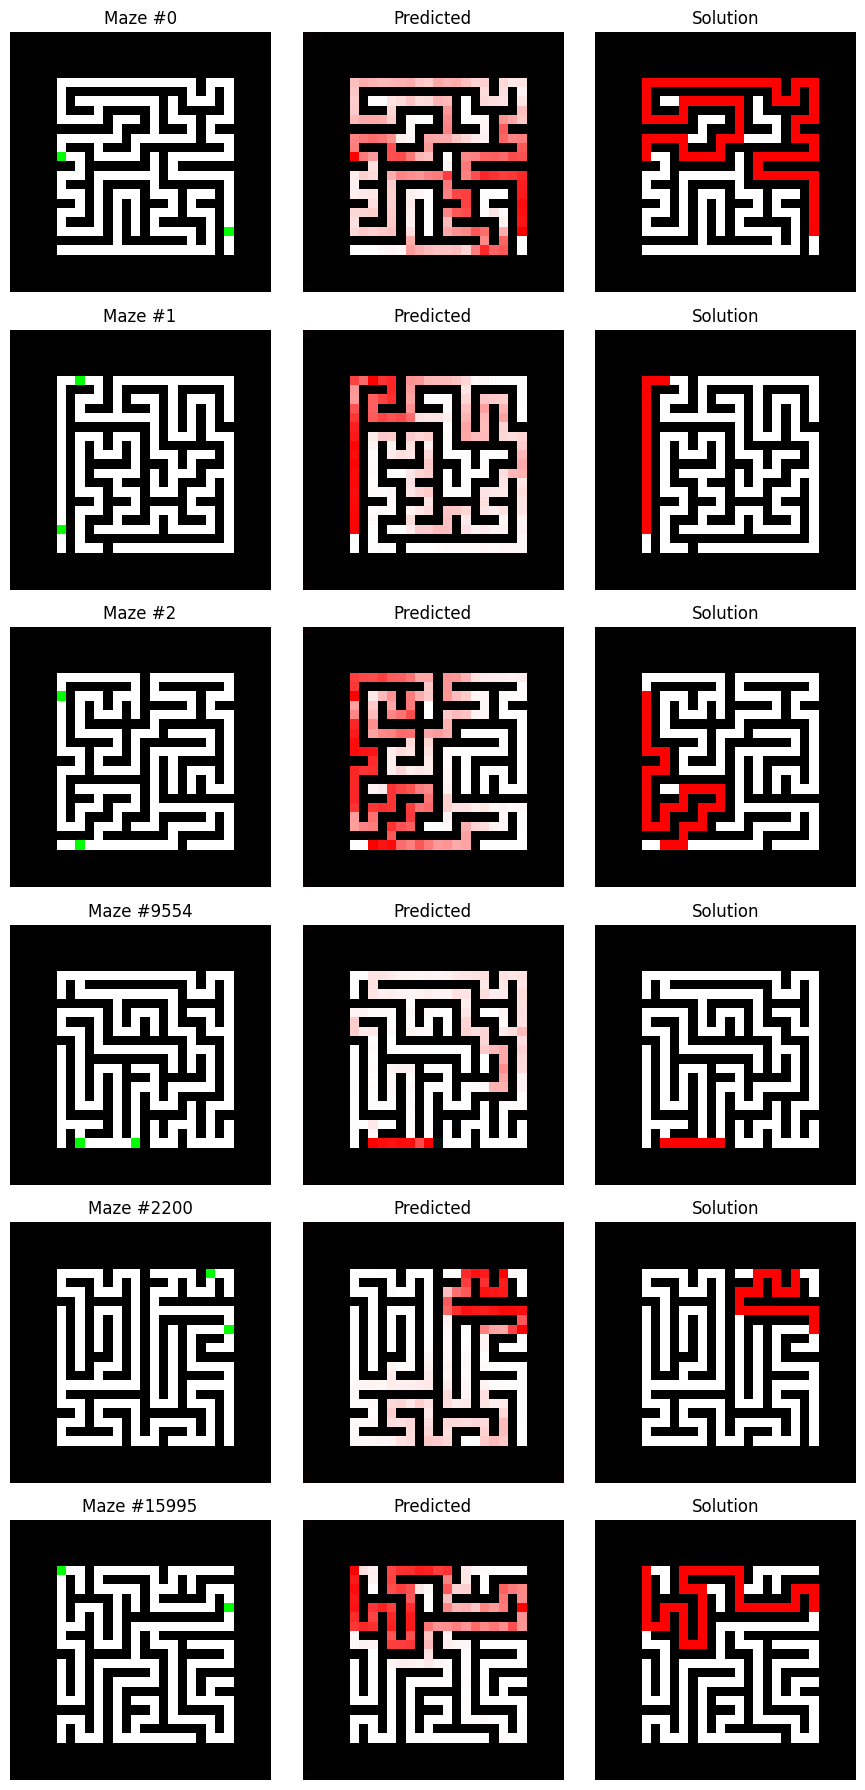

[Train] Epoch 23/70: 100%|██████████| 782/782 [01:59<00:00,  6.57it/s]


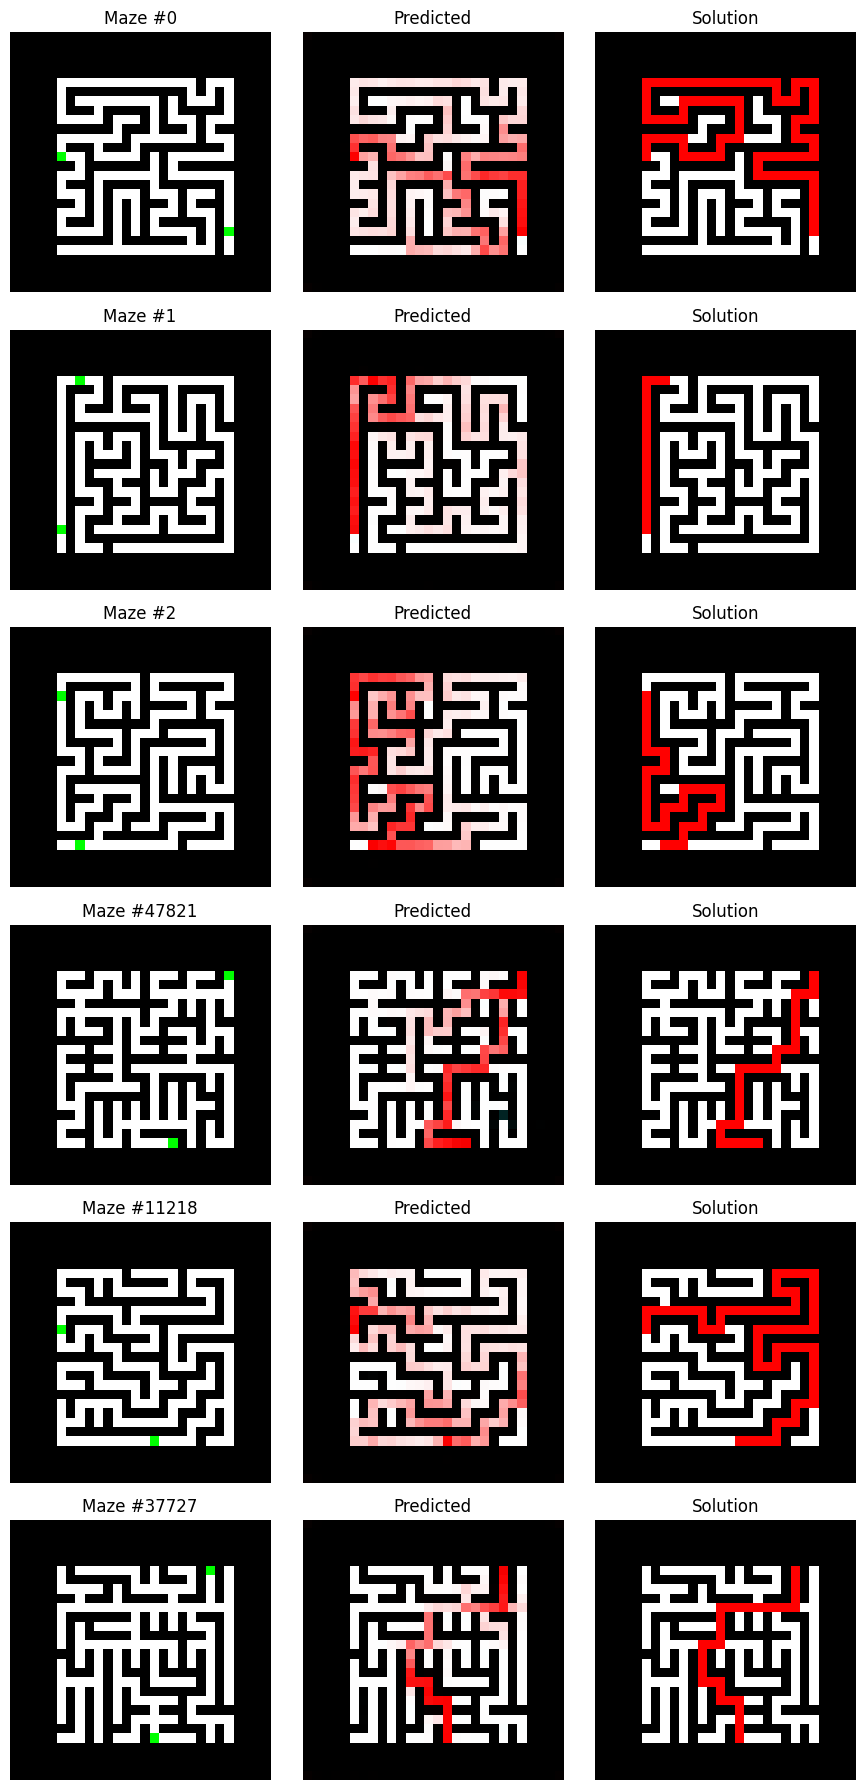

[Train] Epoch 24/70: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s]


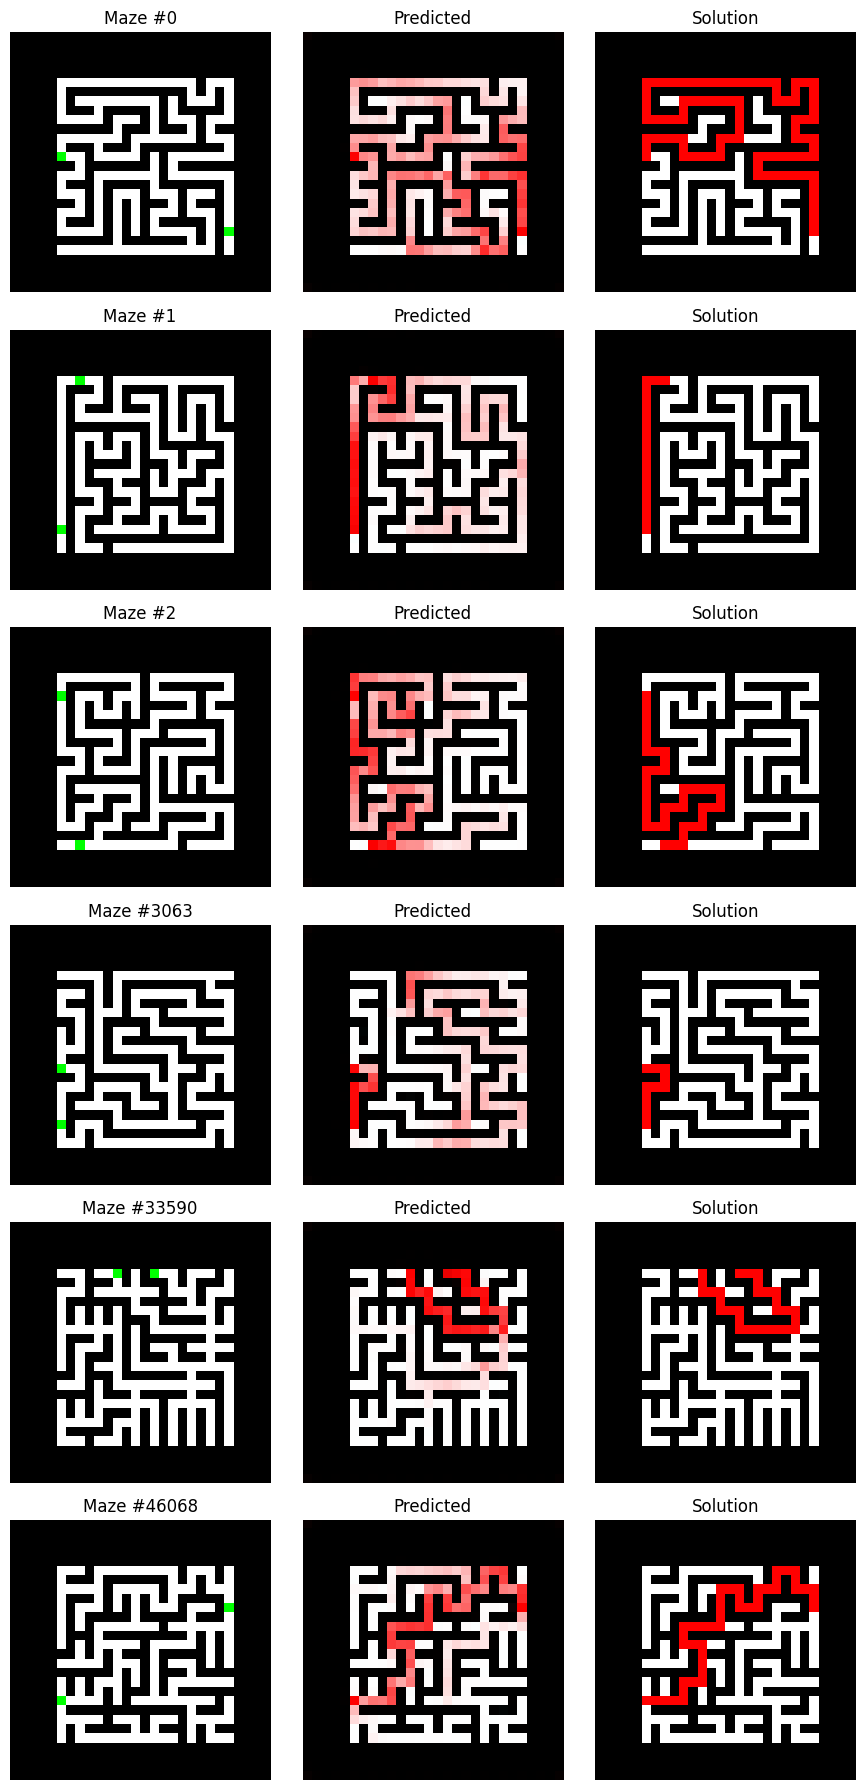

[Train] Epoch 25/70: 100%|██████████| 782/782 [02:00<00:00,  6.49it/s]


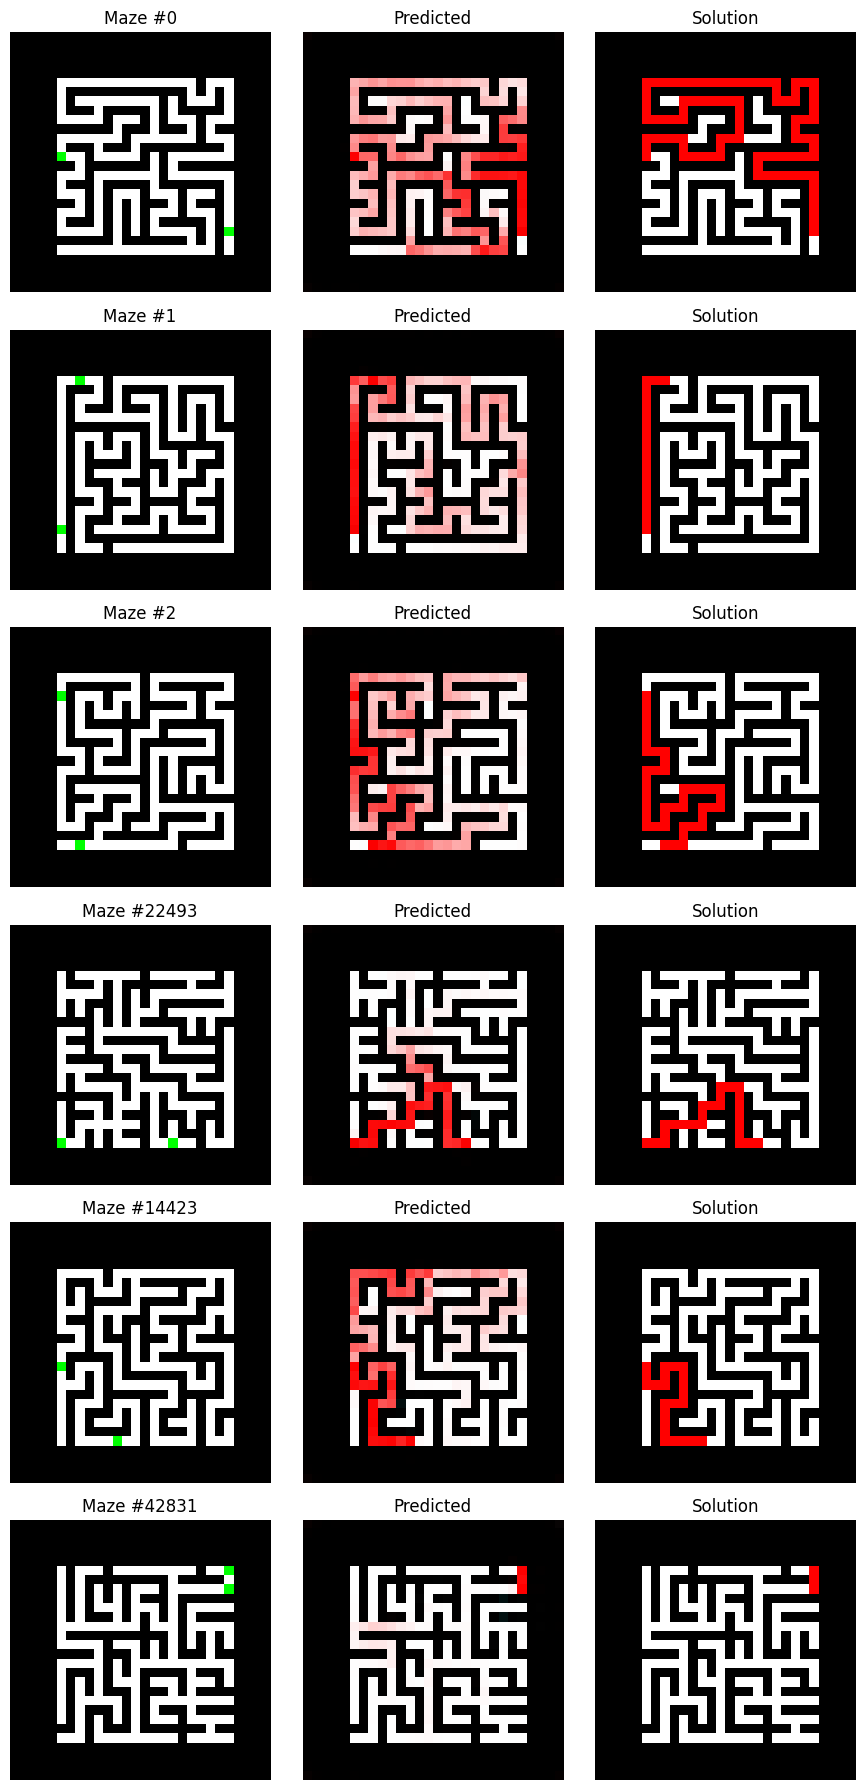

[Train] Epoch 26/70: 100%|██████████| 782/782 [01:58<00:00,  6.58it/s]


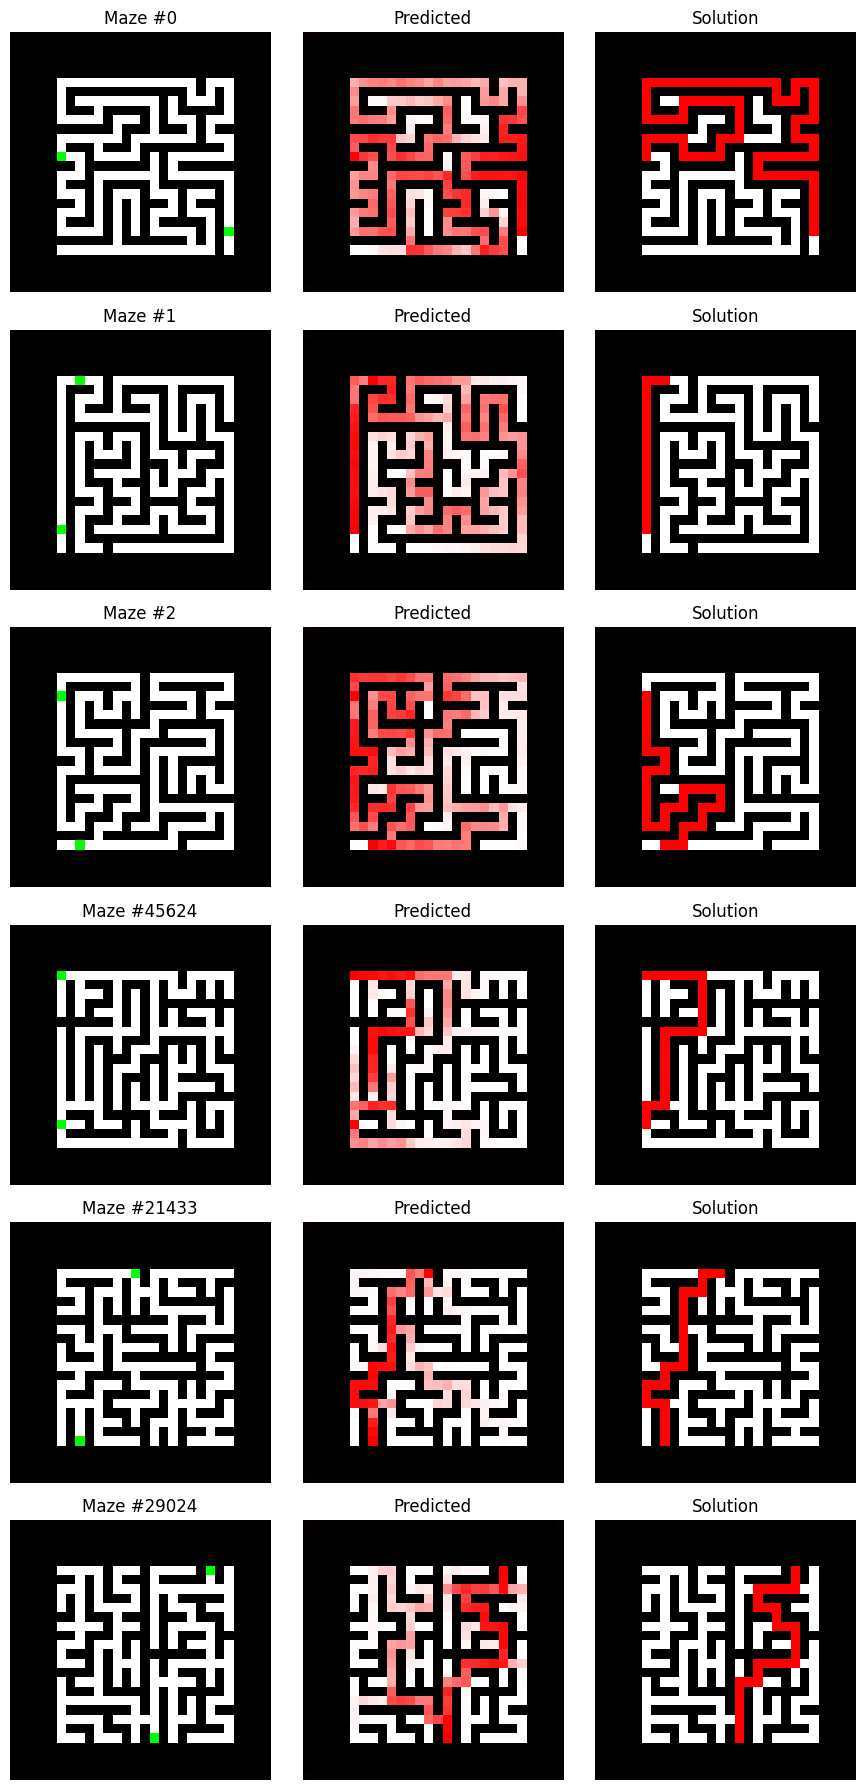

[Train] Epoch 27/70: 100%|██████████| 782/782 [02:38<00:00,  4.94it/s]


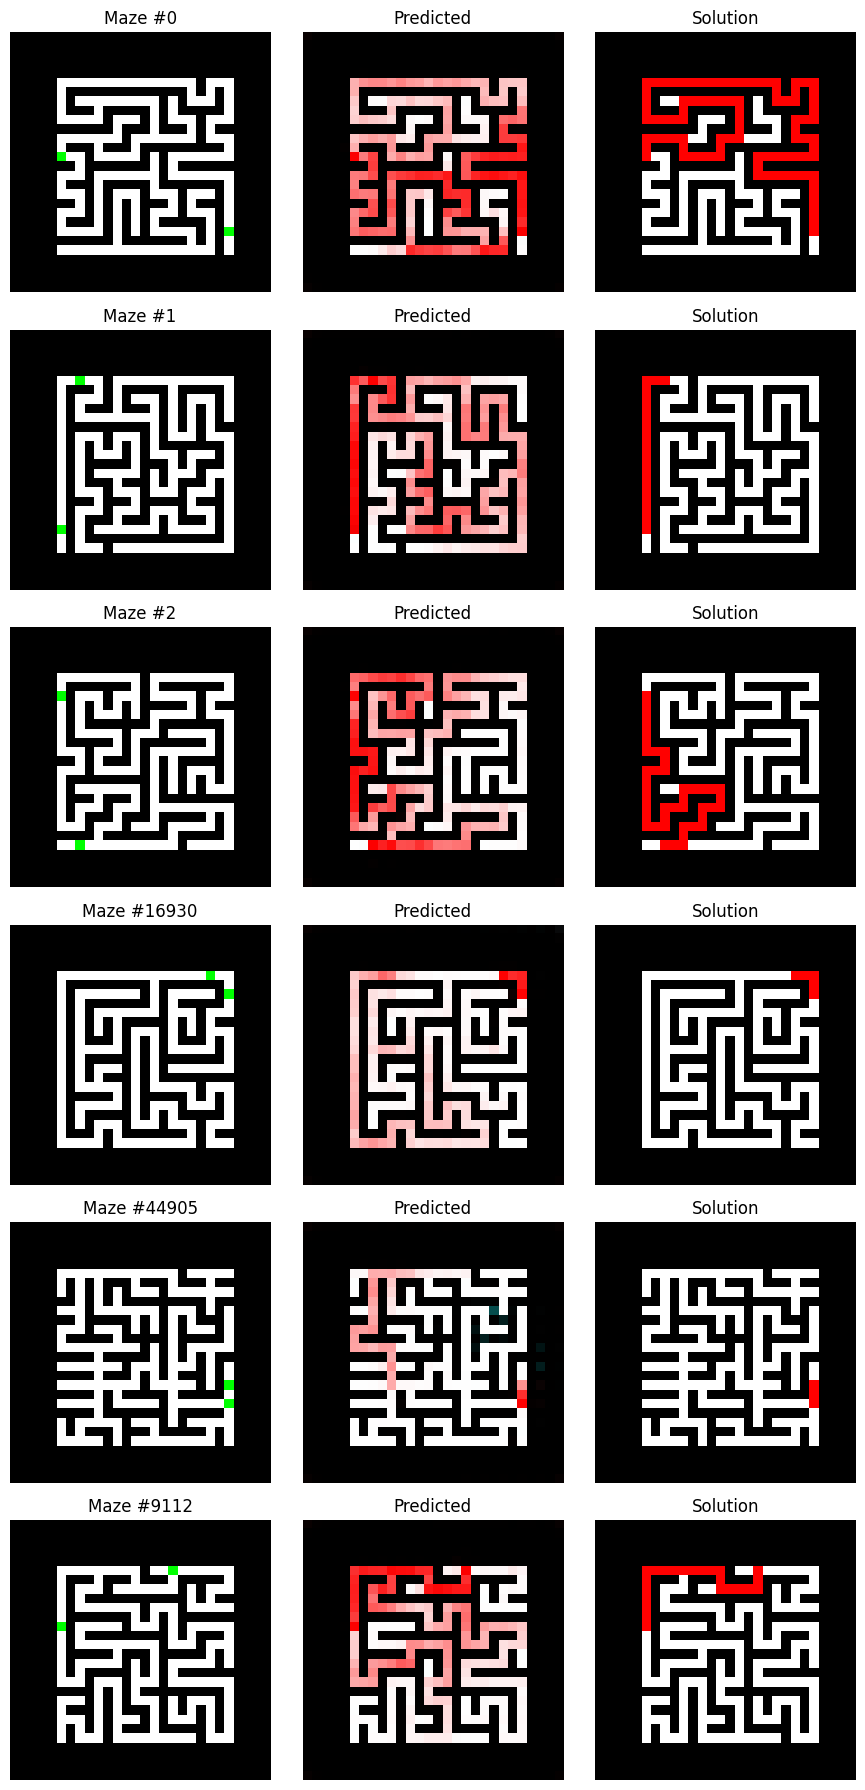

[Train] Epoch 28/70: 100%|██████████| 782/782 [02:21<00:00,  5.54it/s]


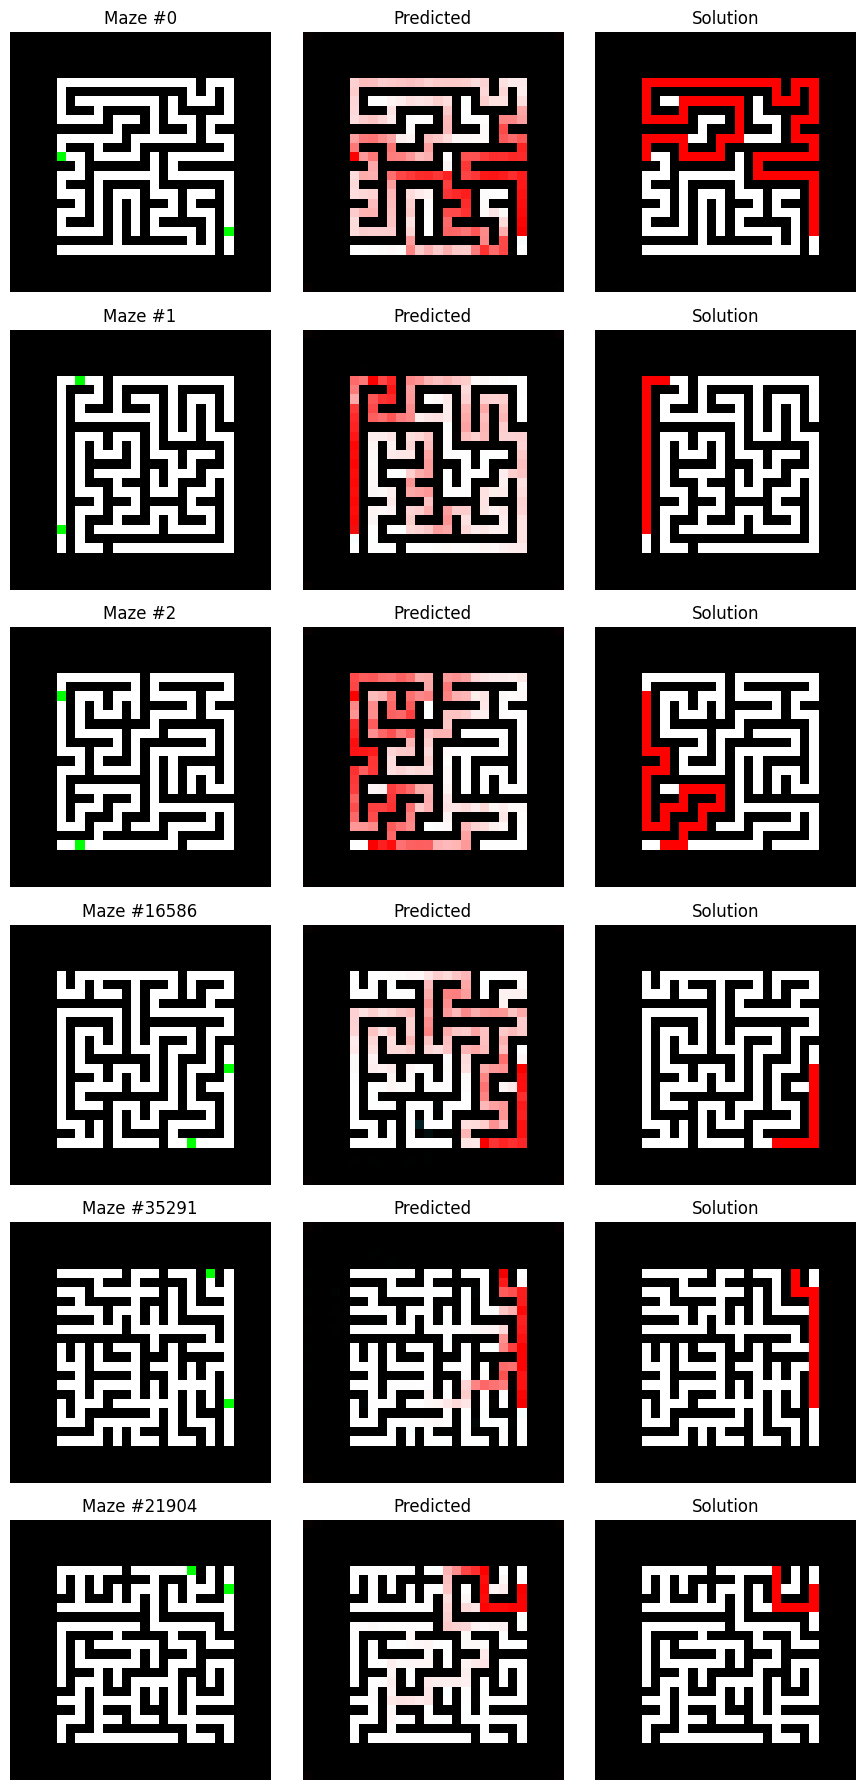

[Train] Epoch 29/70: 100%|██████████| 782/782 [02:20<00:00,  5.58it/s]


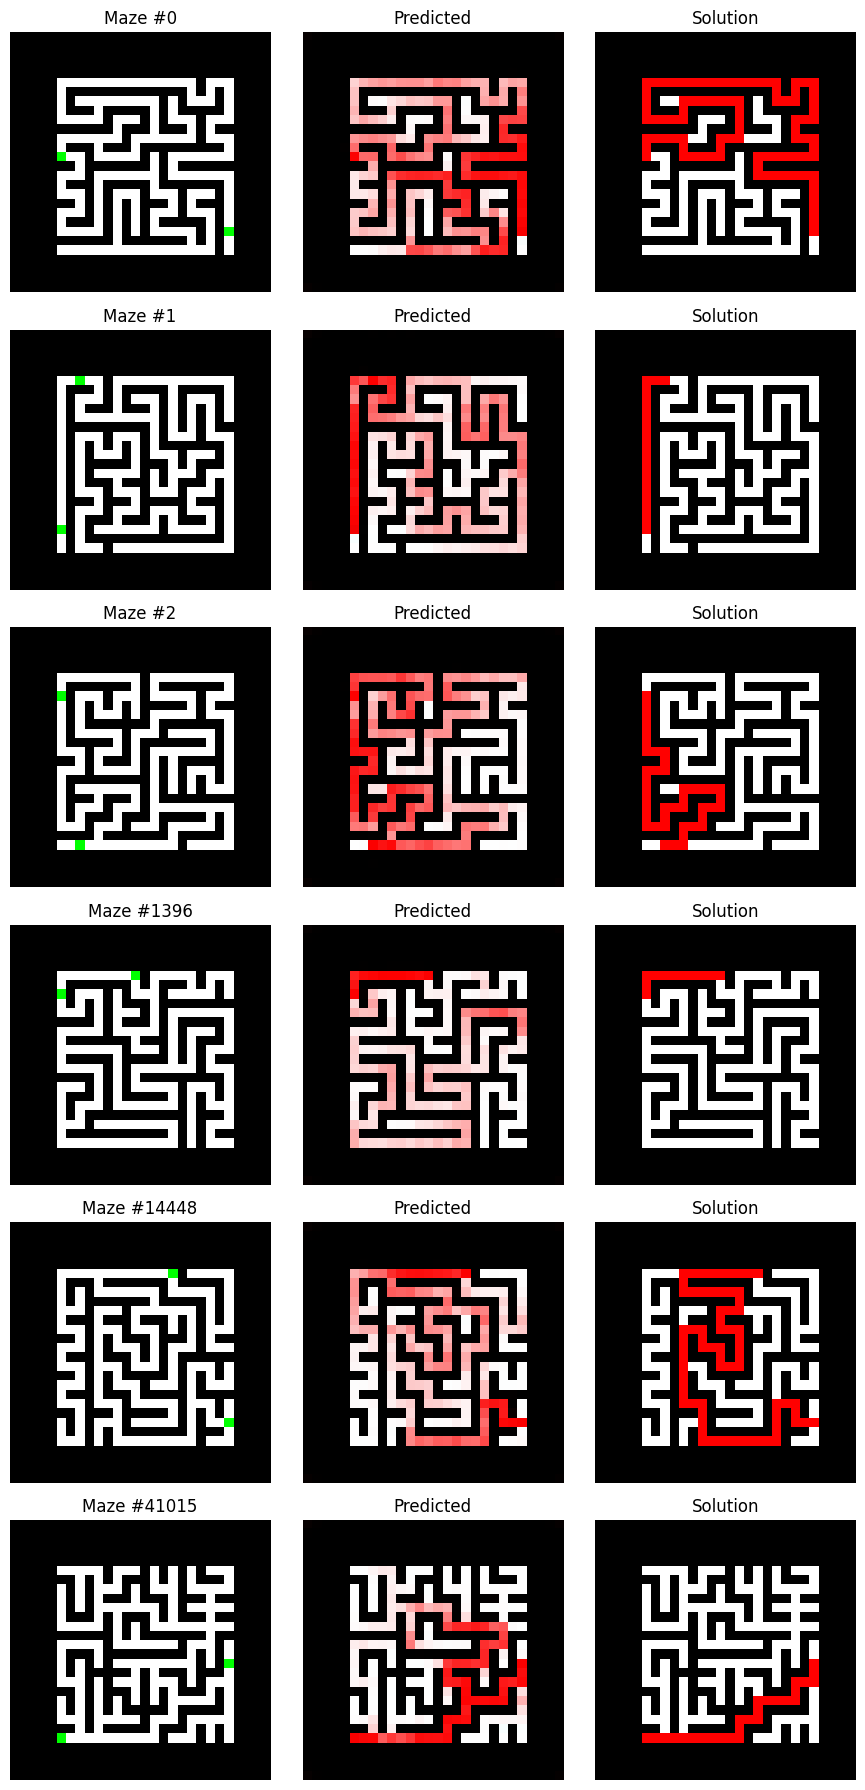

[Train] Epoch 30/70: 100%|██████████| 782/782 [02:17<00:00,  5.70it/s]


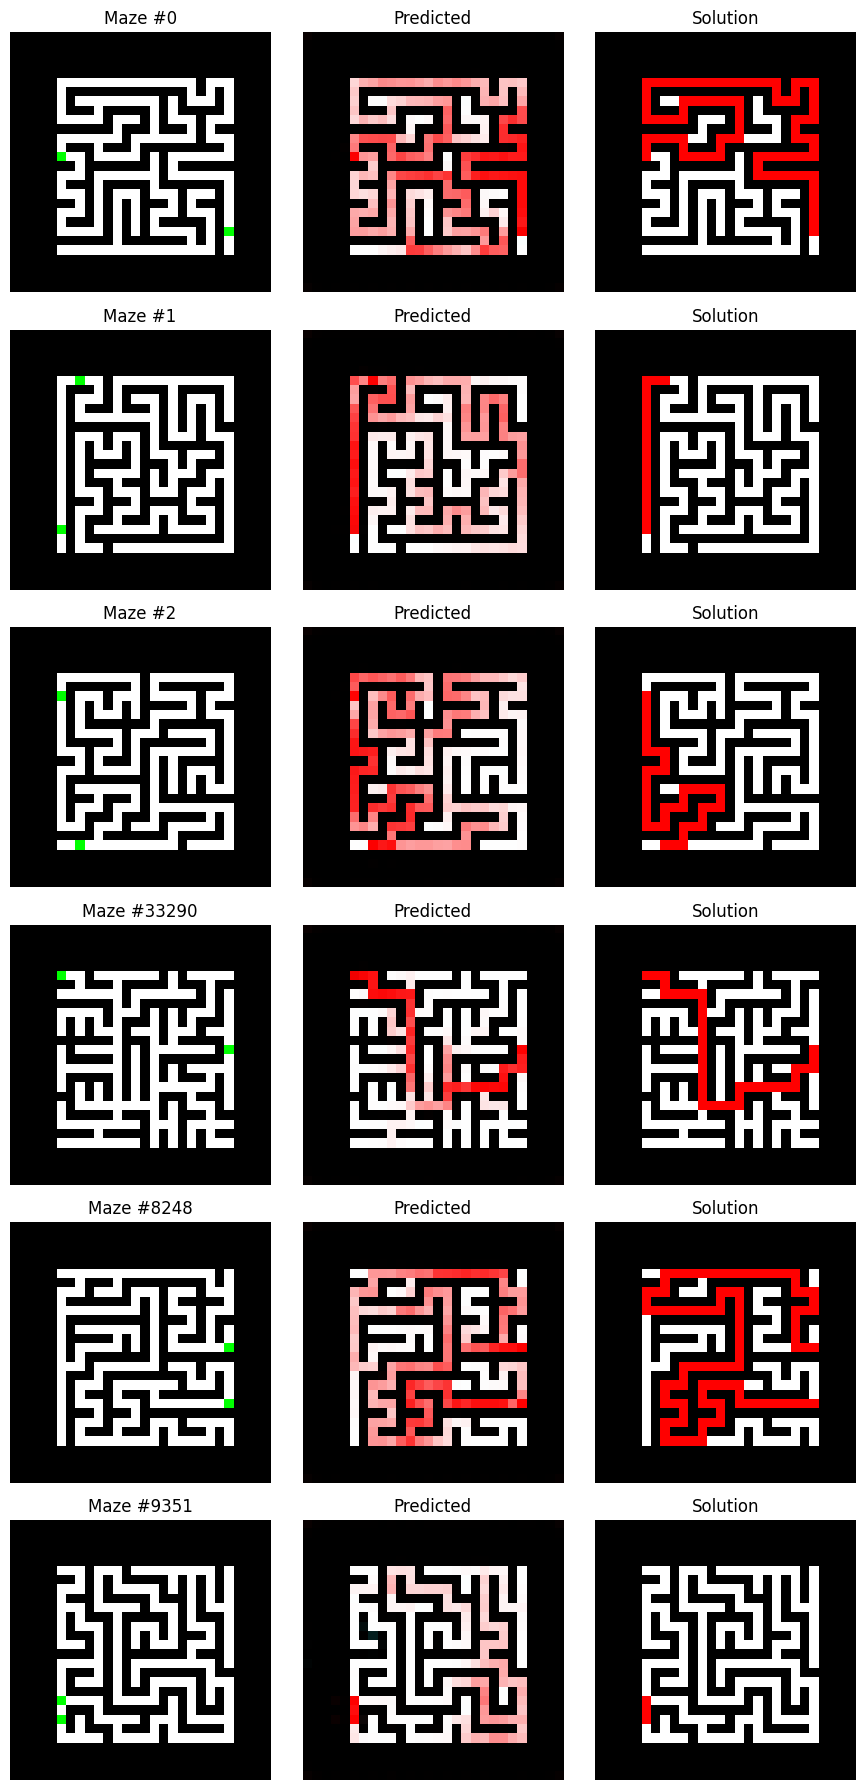

[Train] Epoch 31/70: 100%|██████████| 782/782 [02:34<00:00,  5.07it/s]


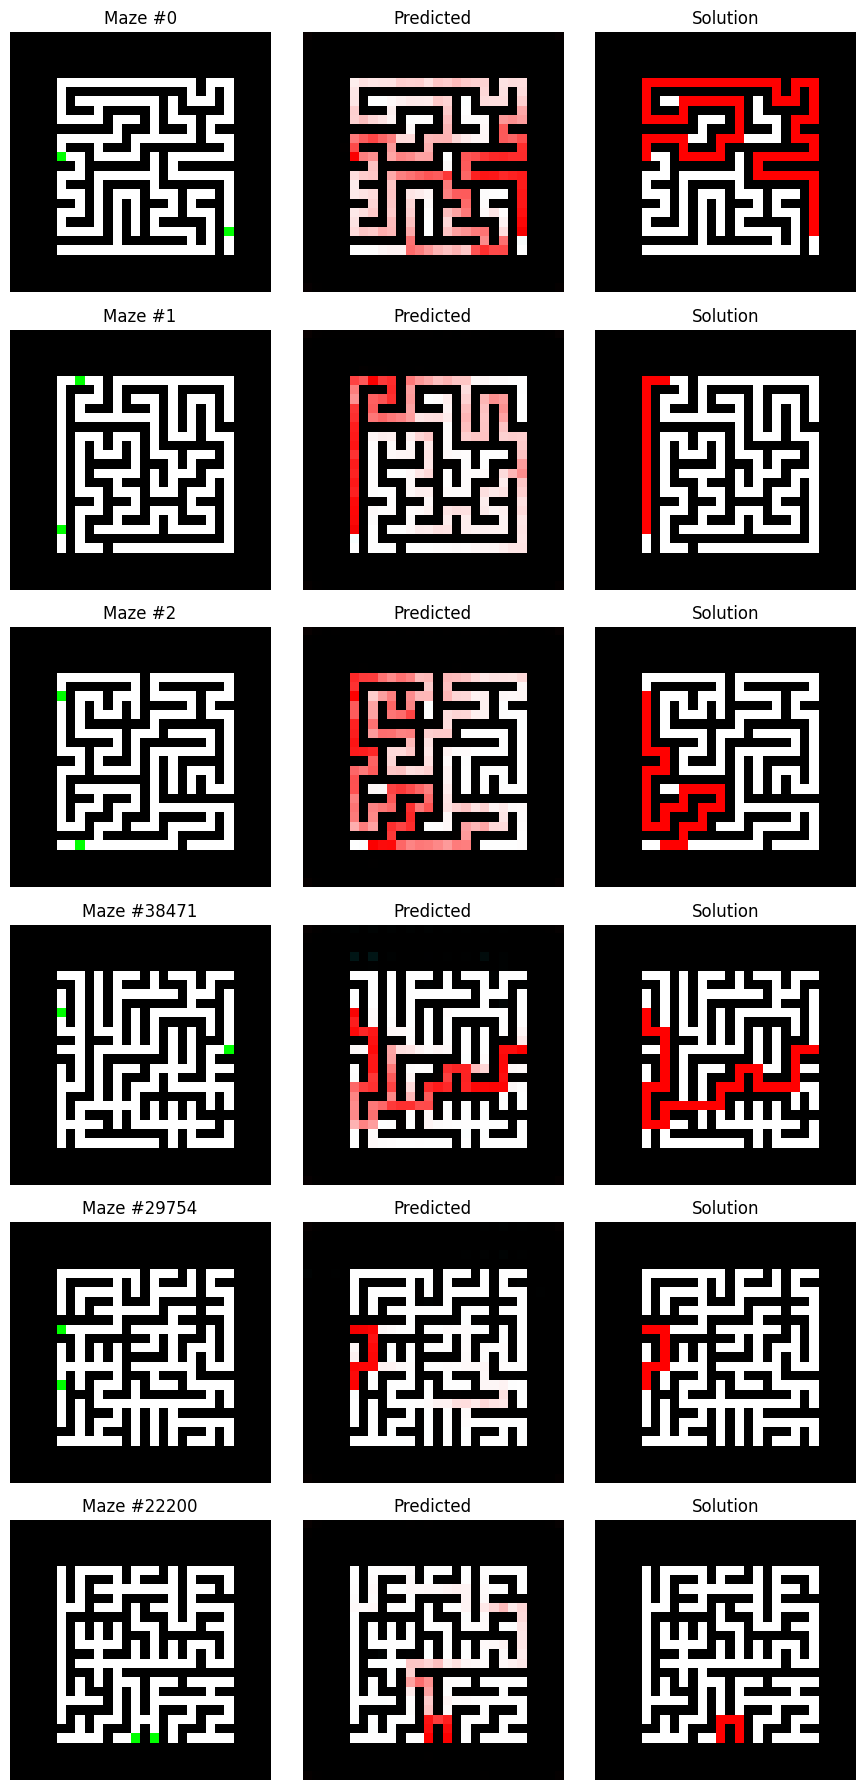

[Train] Epoch 32/70: 100%|██████████| 782/782 [02:18<00:00,  5.65it/s]


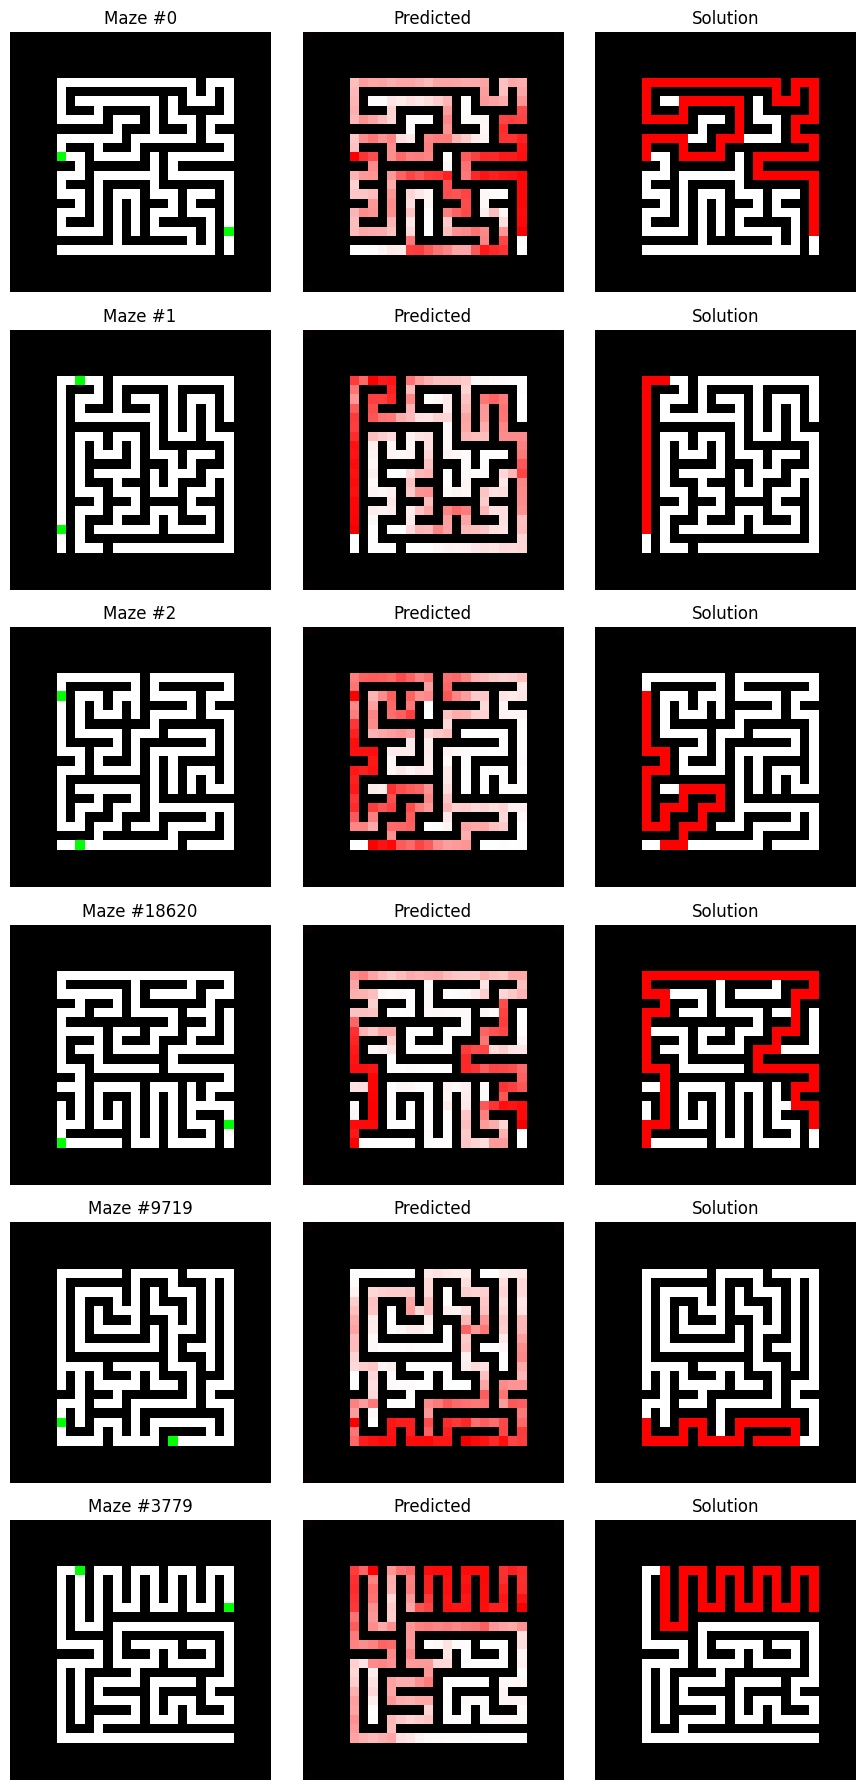

[Train] Epoch 33/70: 100%|██████████| 782/782 [02:06<00:00,  6.20it/s]


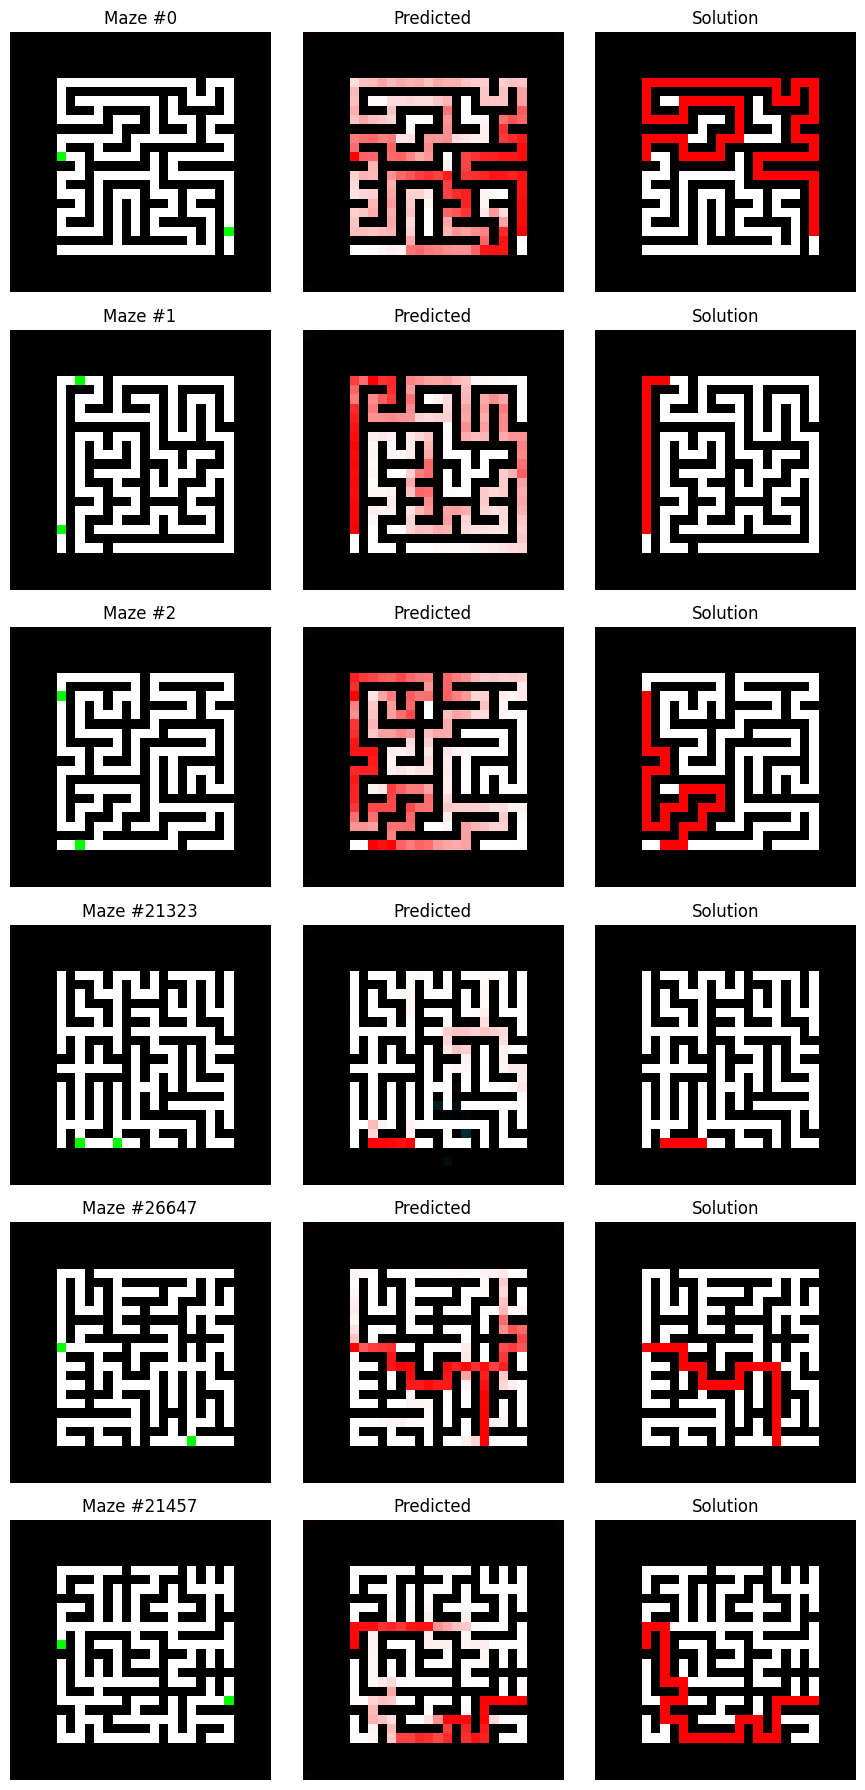

[Train] Epoch 34/70: 100%|██████████| 782/782 [02:02<00:00,  6.40it/s]


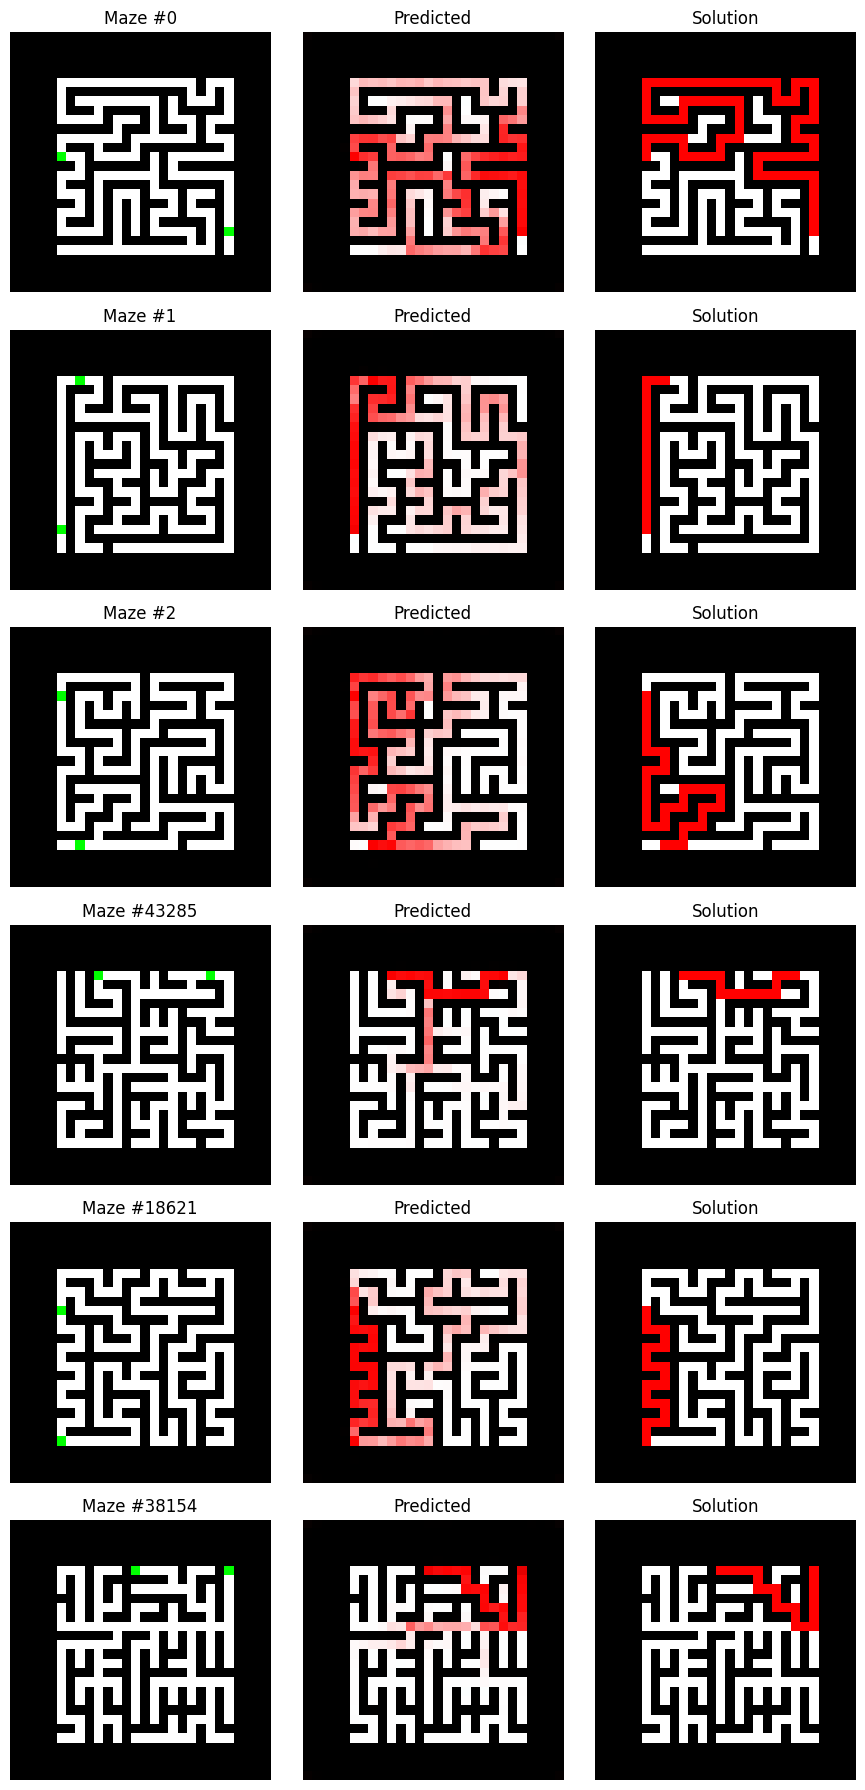

[Train] Epoch 35/70: 100%|██████████| 782/782 [02:02<00:00,  6.36it/s]


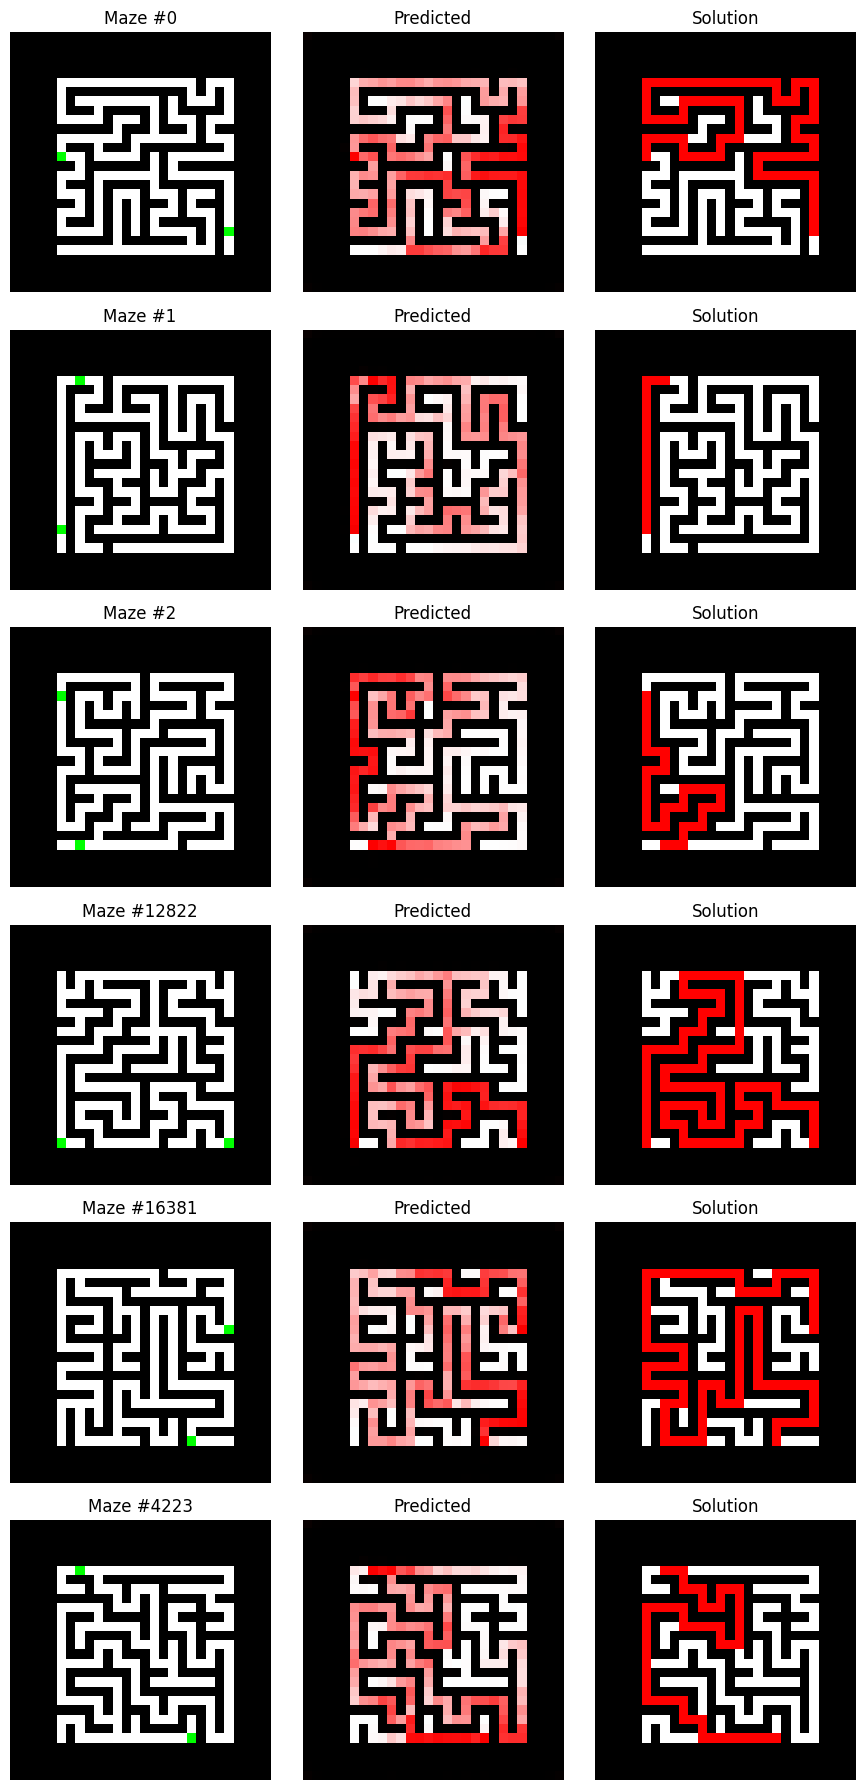

[Train] Epoch 36/70: 100%|██████████| 782/782 [02:00<00:00,  6.49it/s]


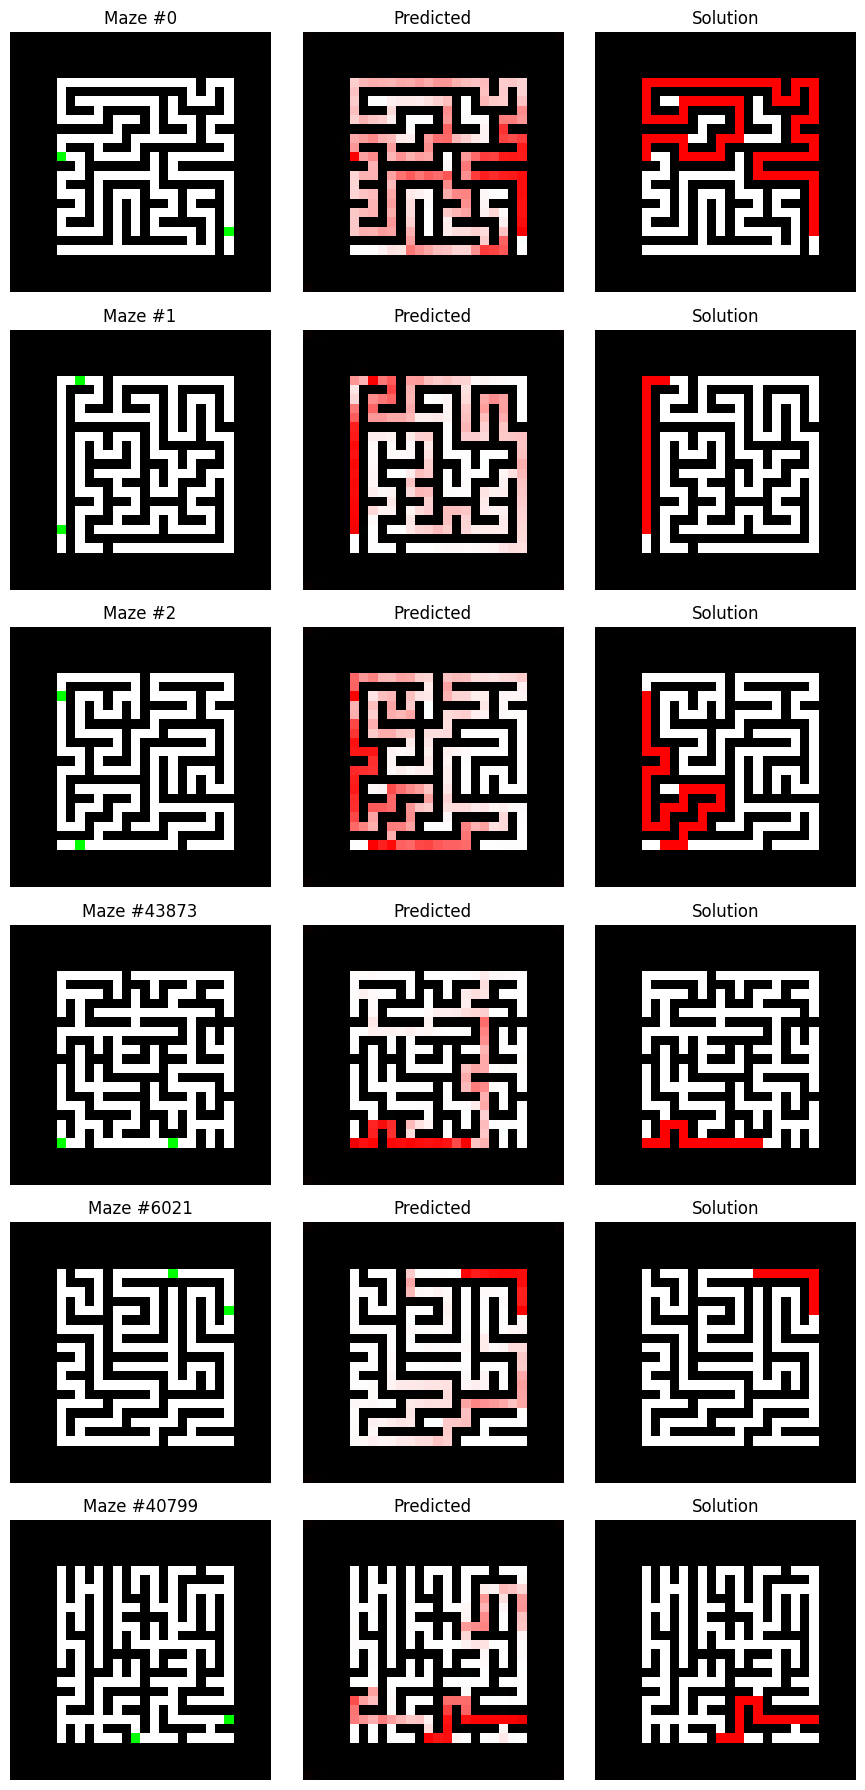

[Train] Epoch 37/70: 100%|██████████| 782/782 [02:00<00:00,  6.49it/s]


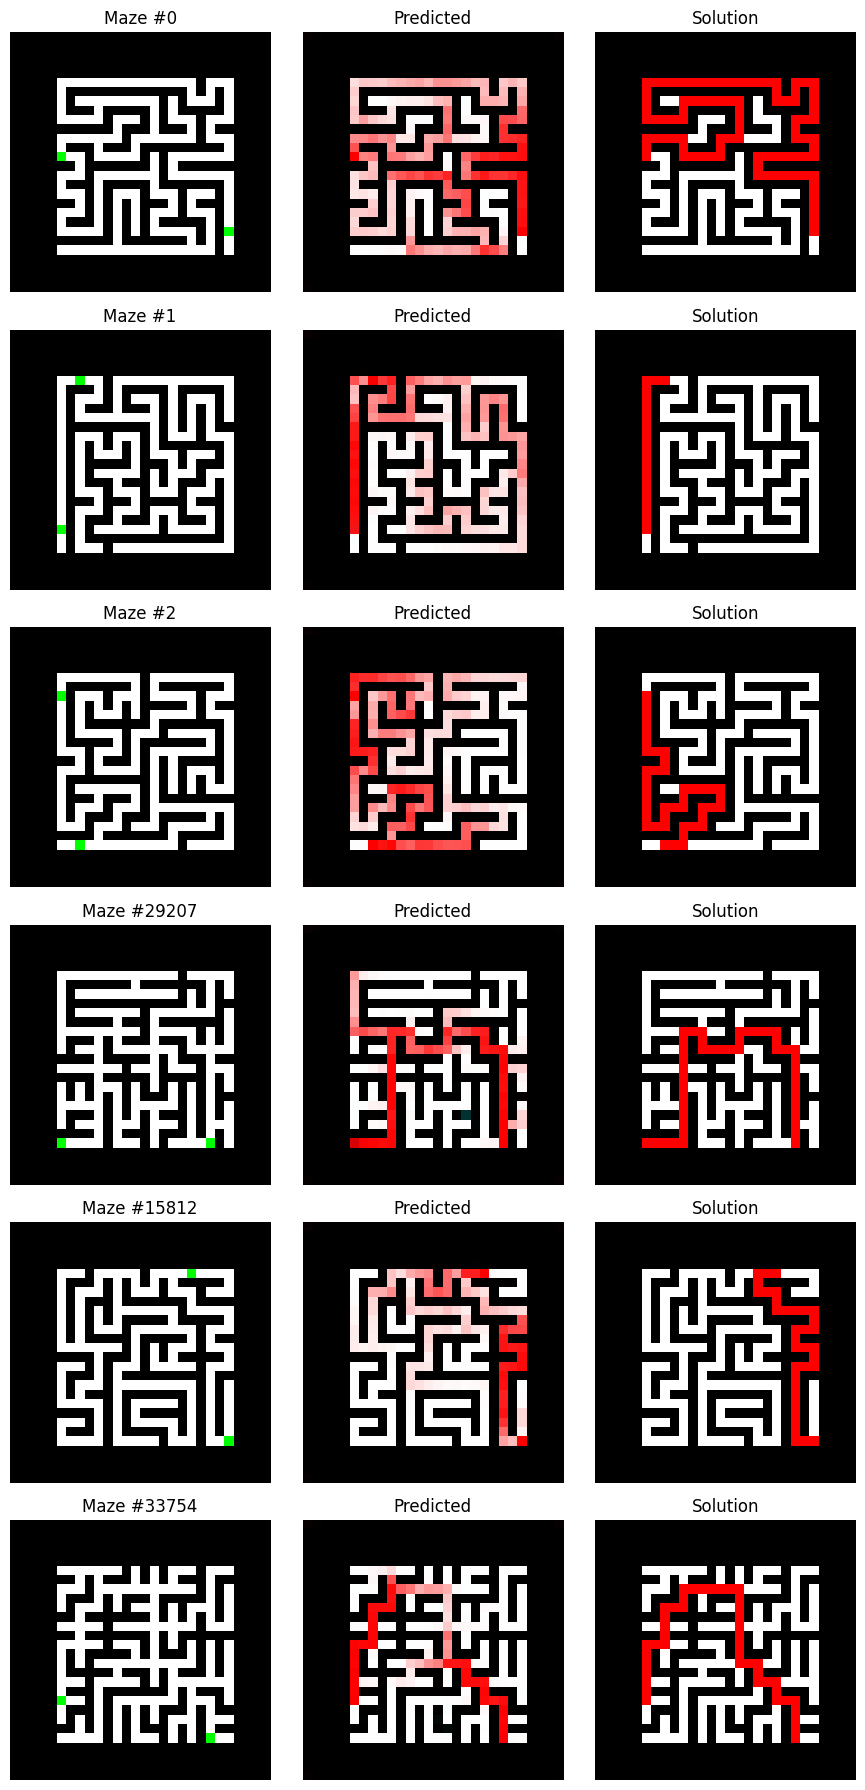

[Train] Epoch 38/70: 100%|██████████| 782/782 [02:00<00:00,  6.51it/s]


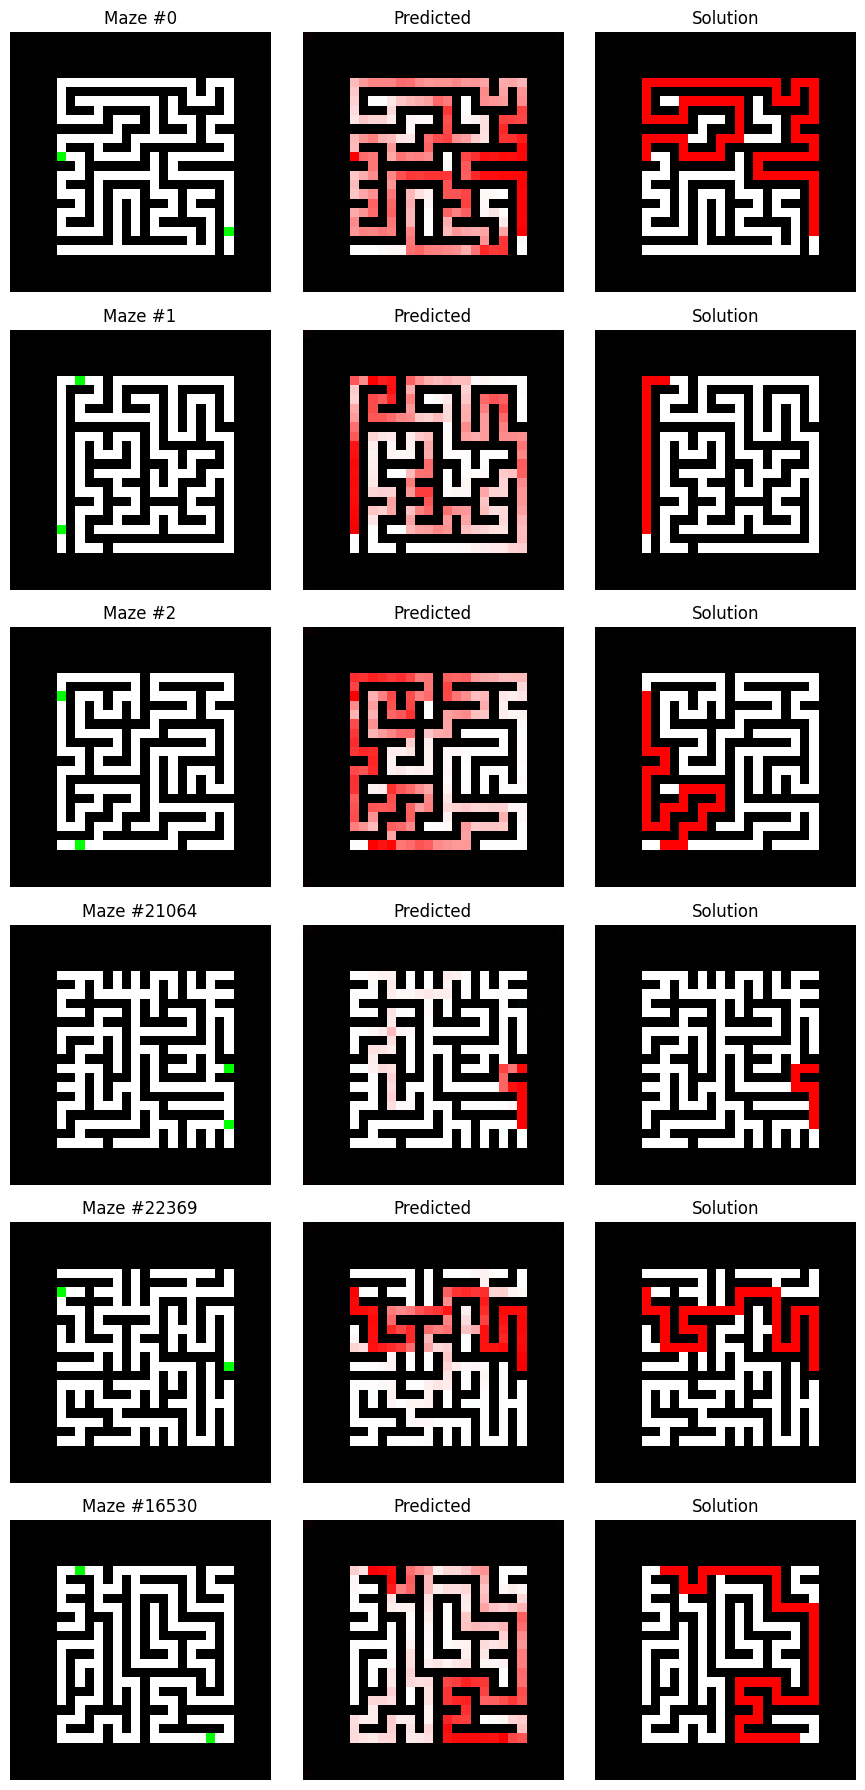

[Train] Epoch 39/70: 100%|██████████| 782/782 [02:01<00:00,  6.46it/s]


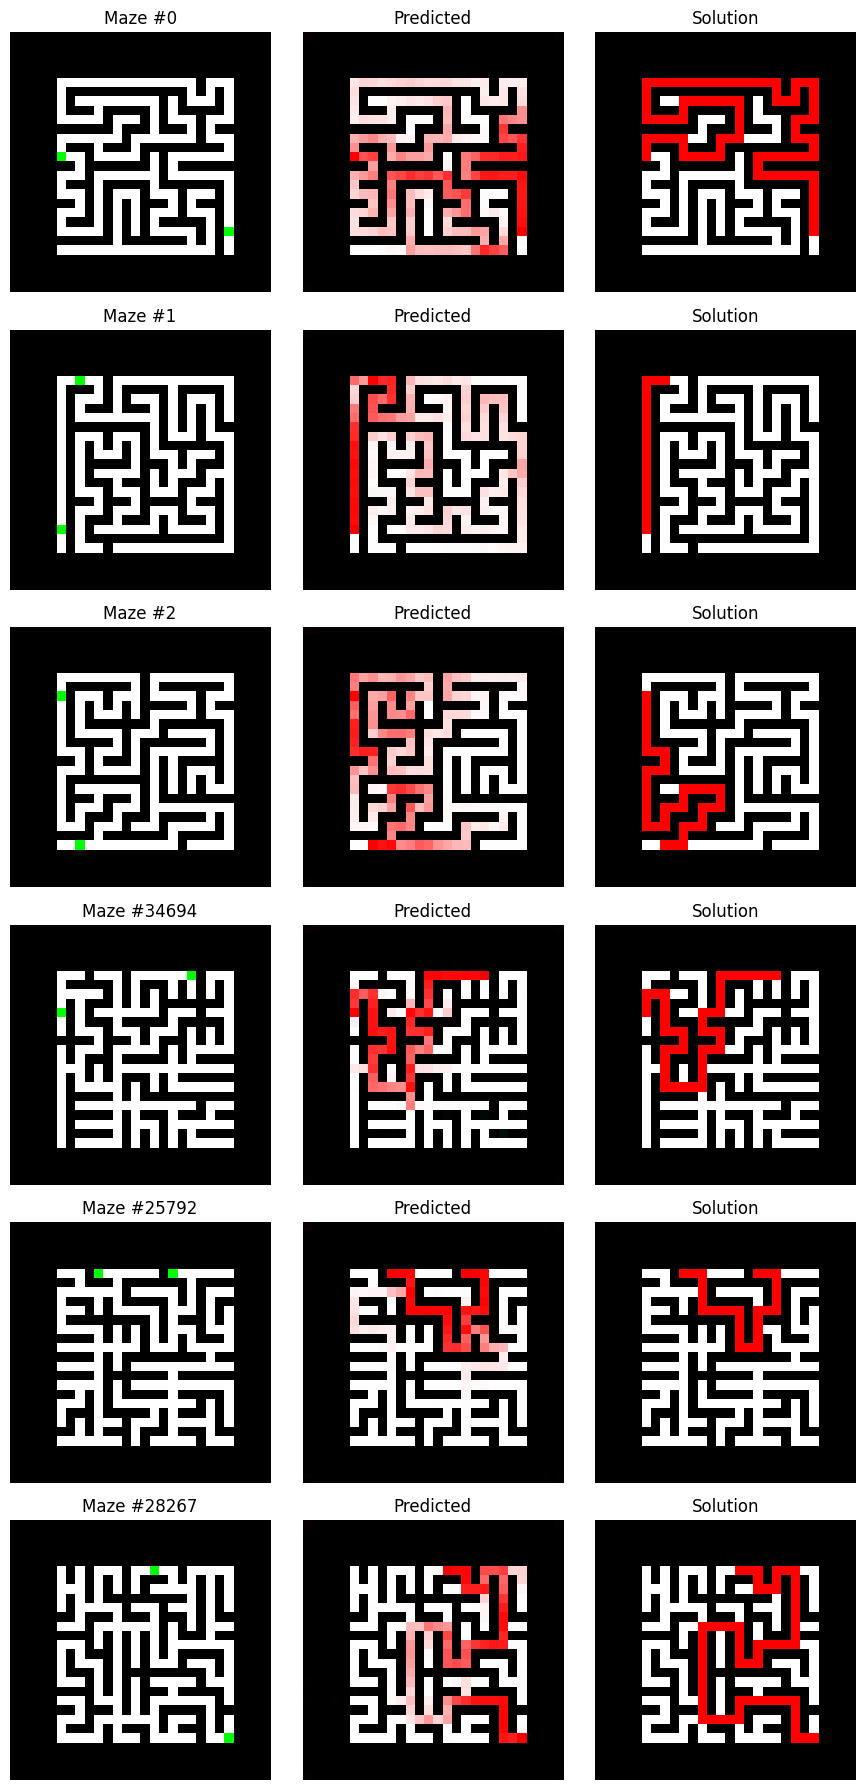

[Train] Epoch 40/70: 100%|██████████| 782/782 [01:56<00:00,  6.69it/s]


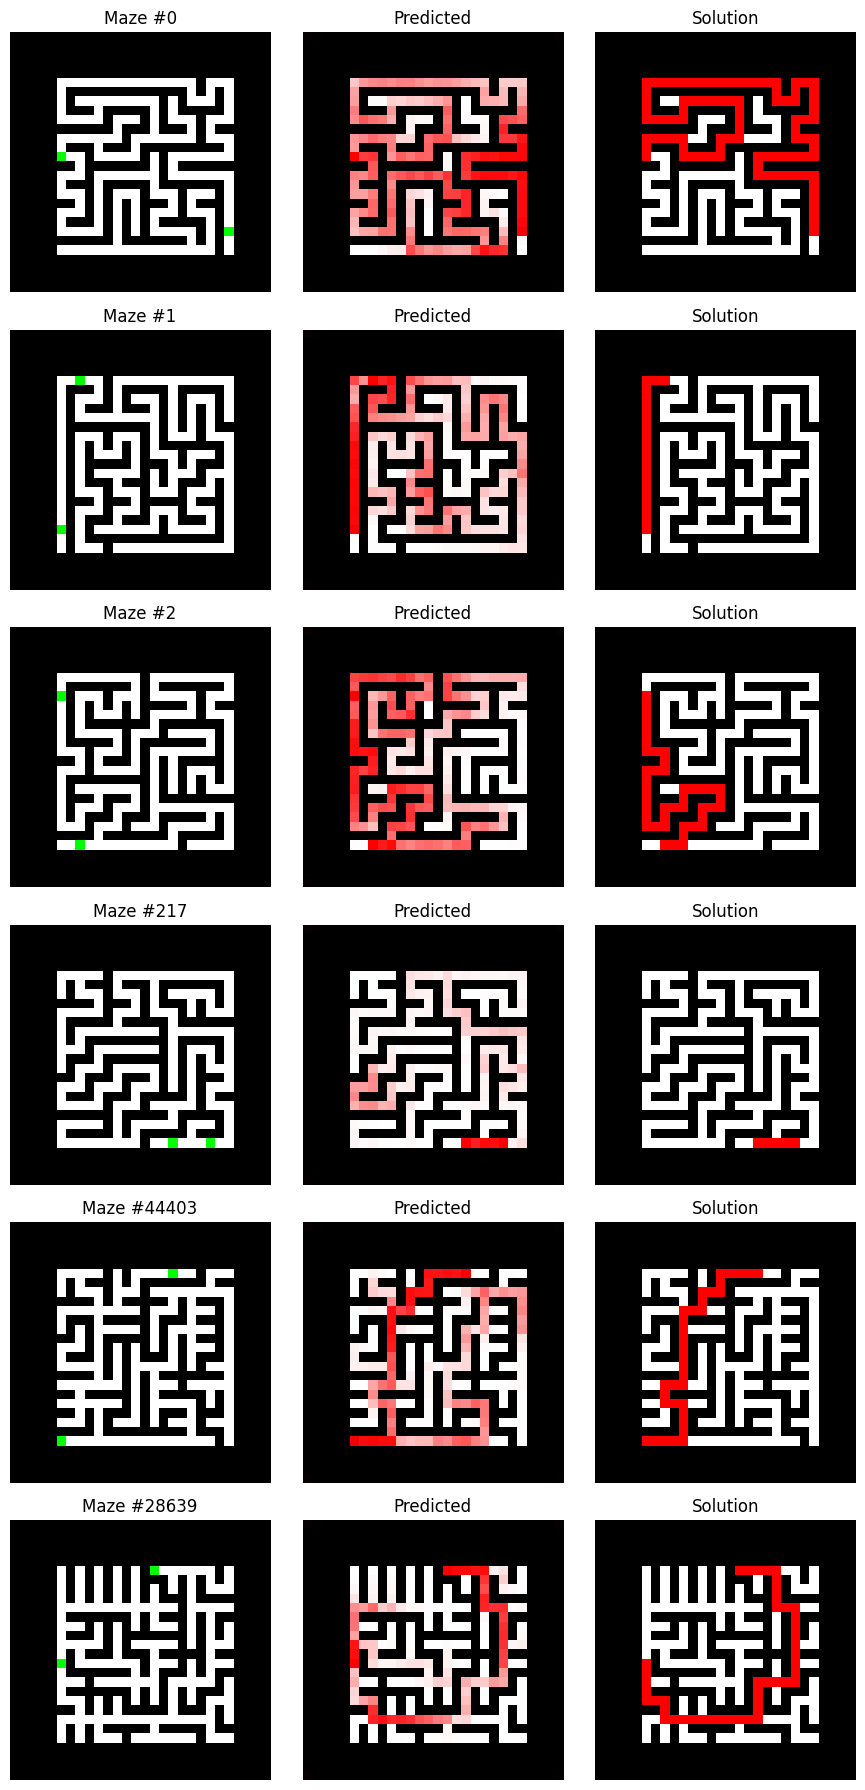

[Train] Epoch 41/70: 100%|██████████| 782/782 [01:58<00:00,  6.58it/s]


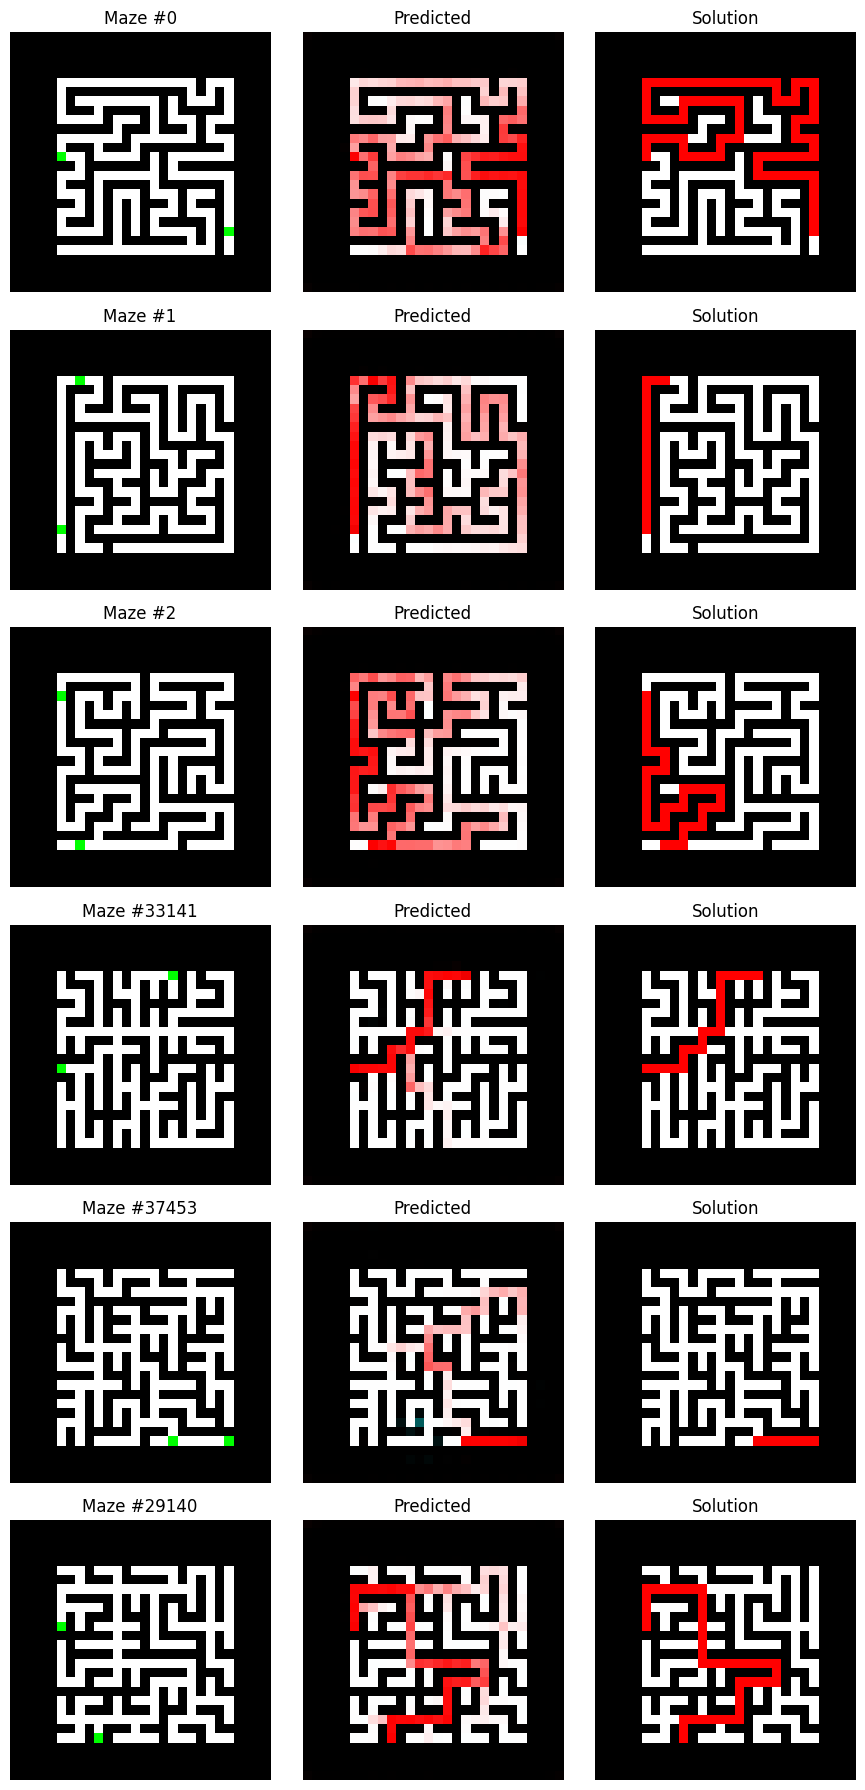

[Train] Epoch 42/70: 100%|██████████| 782/782 [01:59<00:00,  6.56it/s]


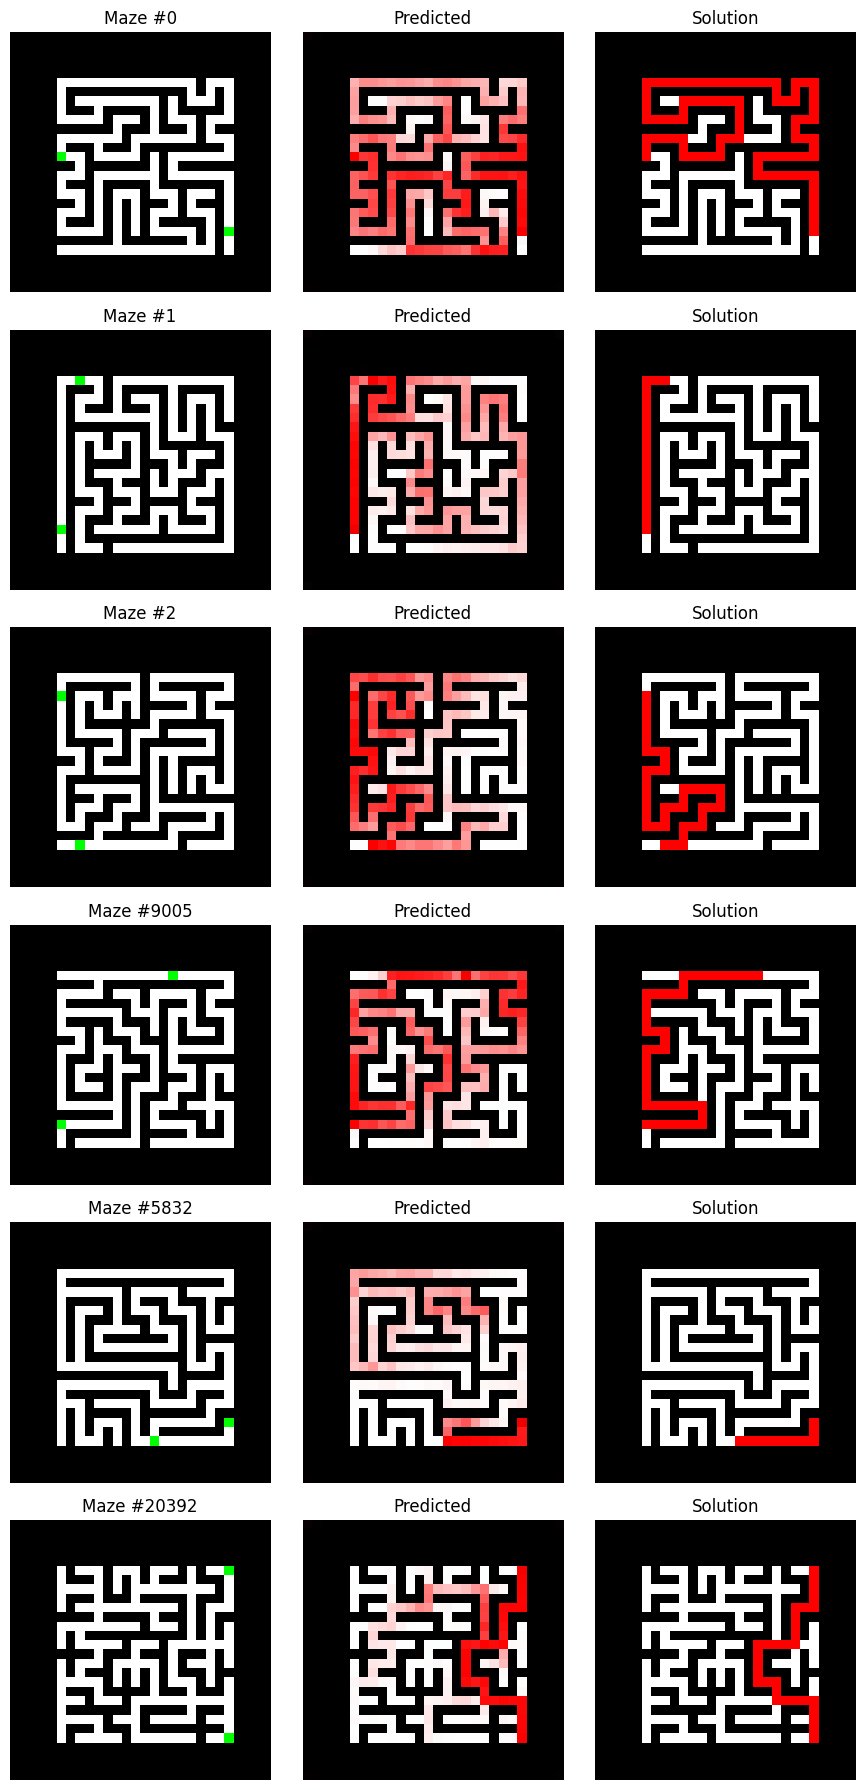

[Train] Epoch 43/70: 100%|██████████| 782/782 [01:58<00:00,  6.62it/s]


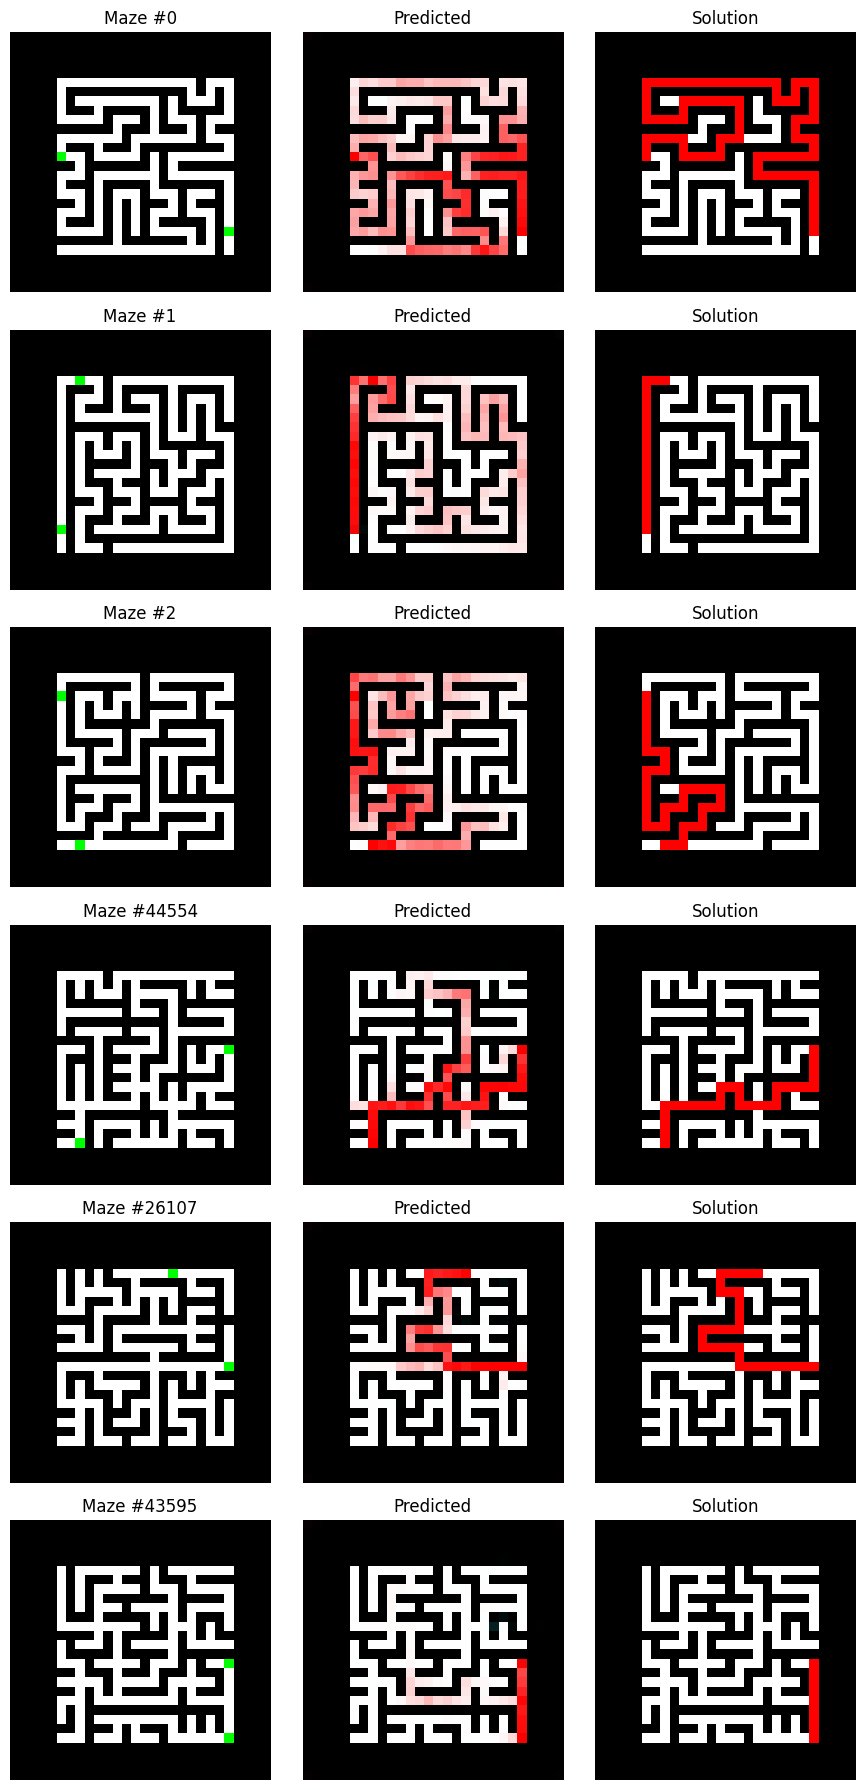

[Train] Epoch 44/70: 100%|██████████| 782/782 [01:58<00:00,  6.60it/s]


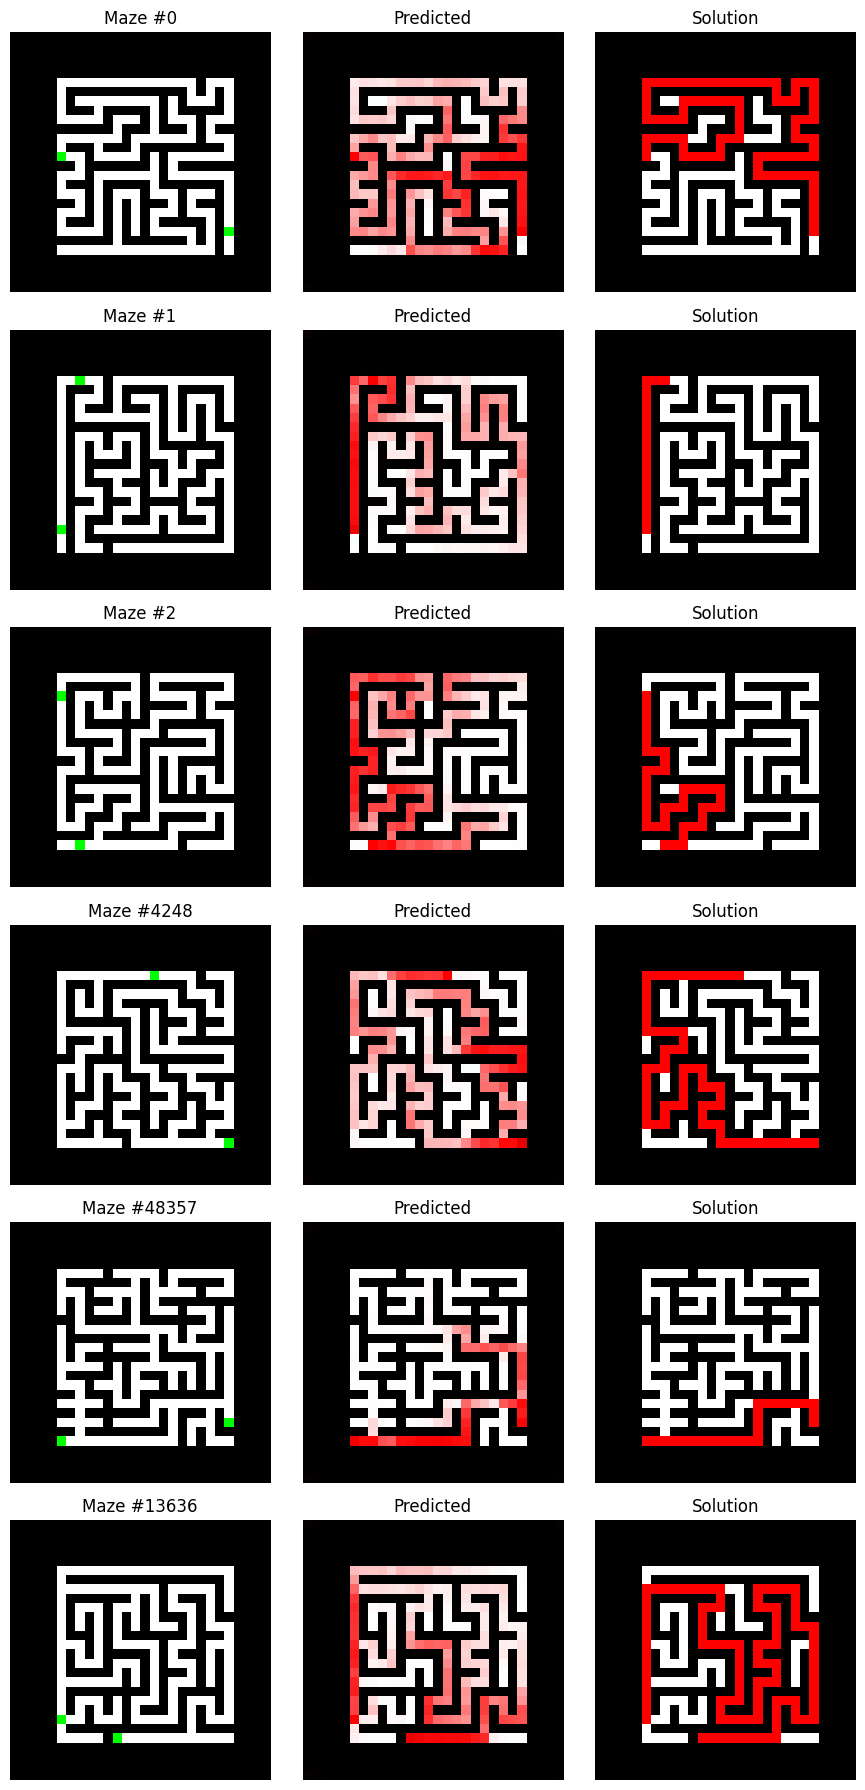

[Train] Epoch 45/70:  45%|████▍     | 351/782 [00:53<01:03,  6.74it/s]

In [ ]:
EPOCHS = 70
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Generator().to(device)  # Output is RGB image (3 channels)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0

    for X, y in tqdm(loader, desc=f"[Train] Epoch {epoch+1}/{EPOCHS}"):
        X = X.to(device).float()  # (B, 3, 28, 28)
        y = y.to(device).float()  # (B, 3, 28, 28)

        outputs = model(X)   
        loss = criterion(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    viz_training(model,loader)
    

## 2. Training pix 2 pix architecture

In [22]:
torch.ones_like

<function torch._VariableFunctionsClass.ones_like>

[Train] Epoch 1/40: 100%|██████████| 782/782 [01:41<00:00,  7.68it/s]


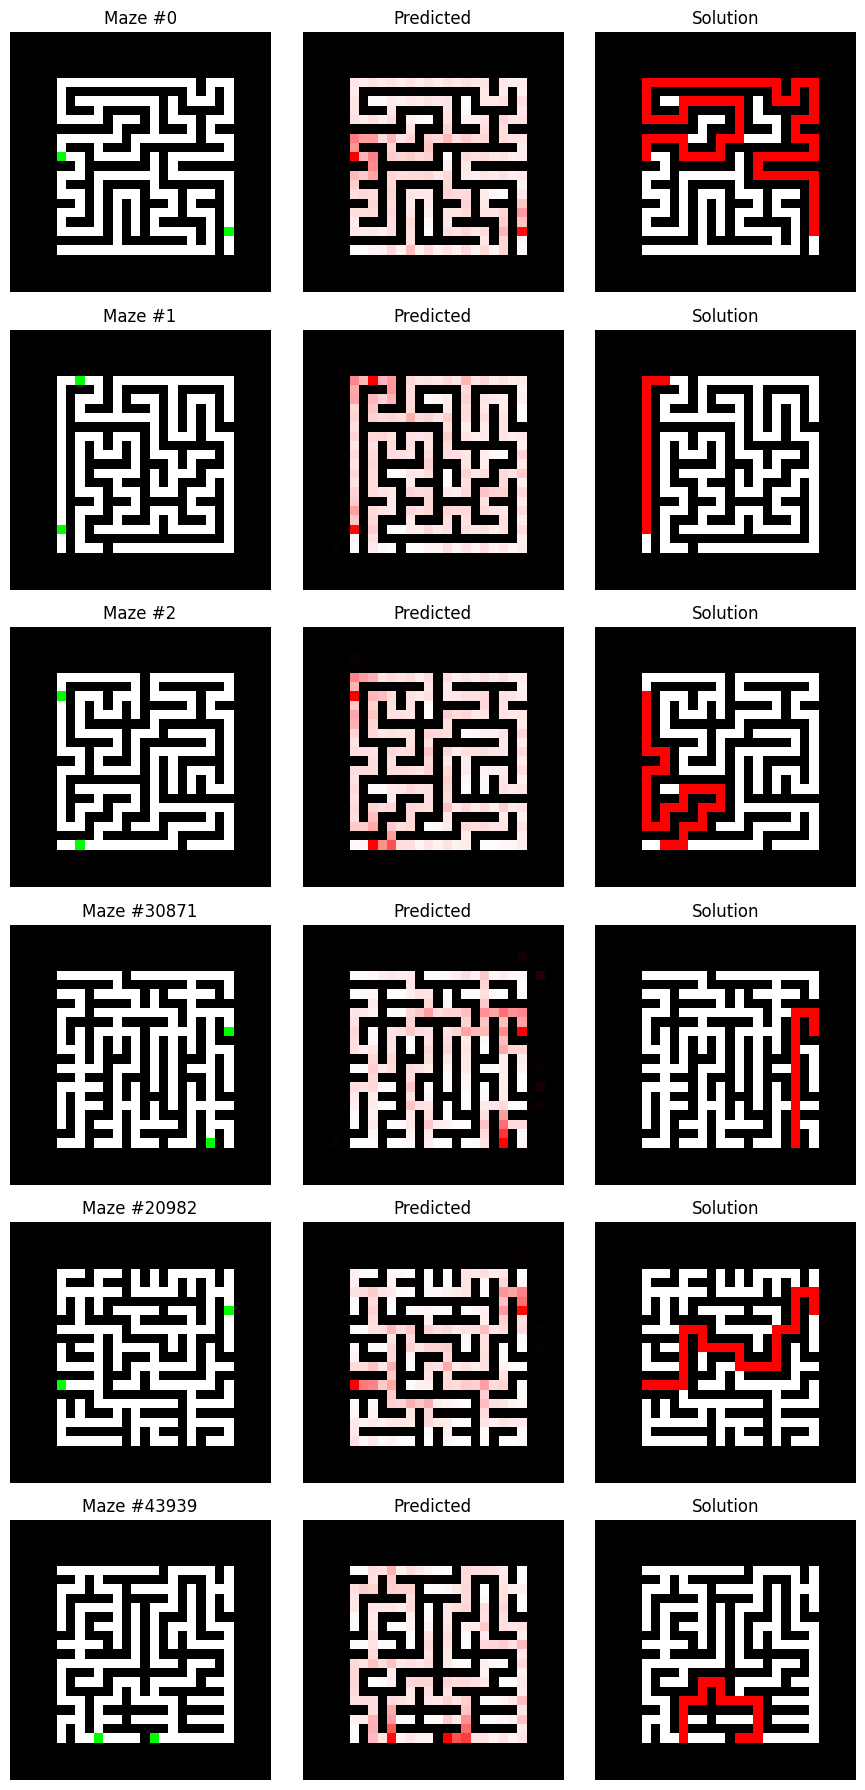

Epoch 1 | D Loss: 528.5992 | G Loss: 6.9856


[Train] Epoch 2/40: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s]


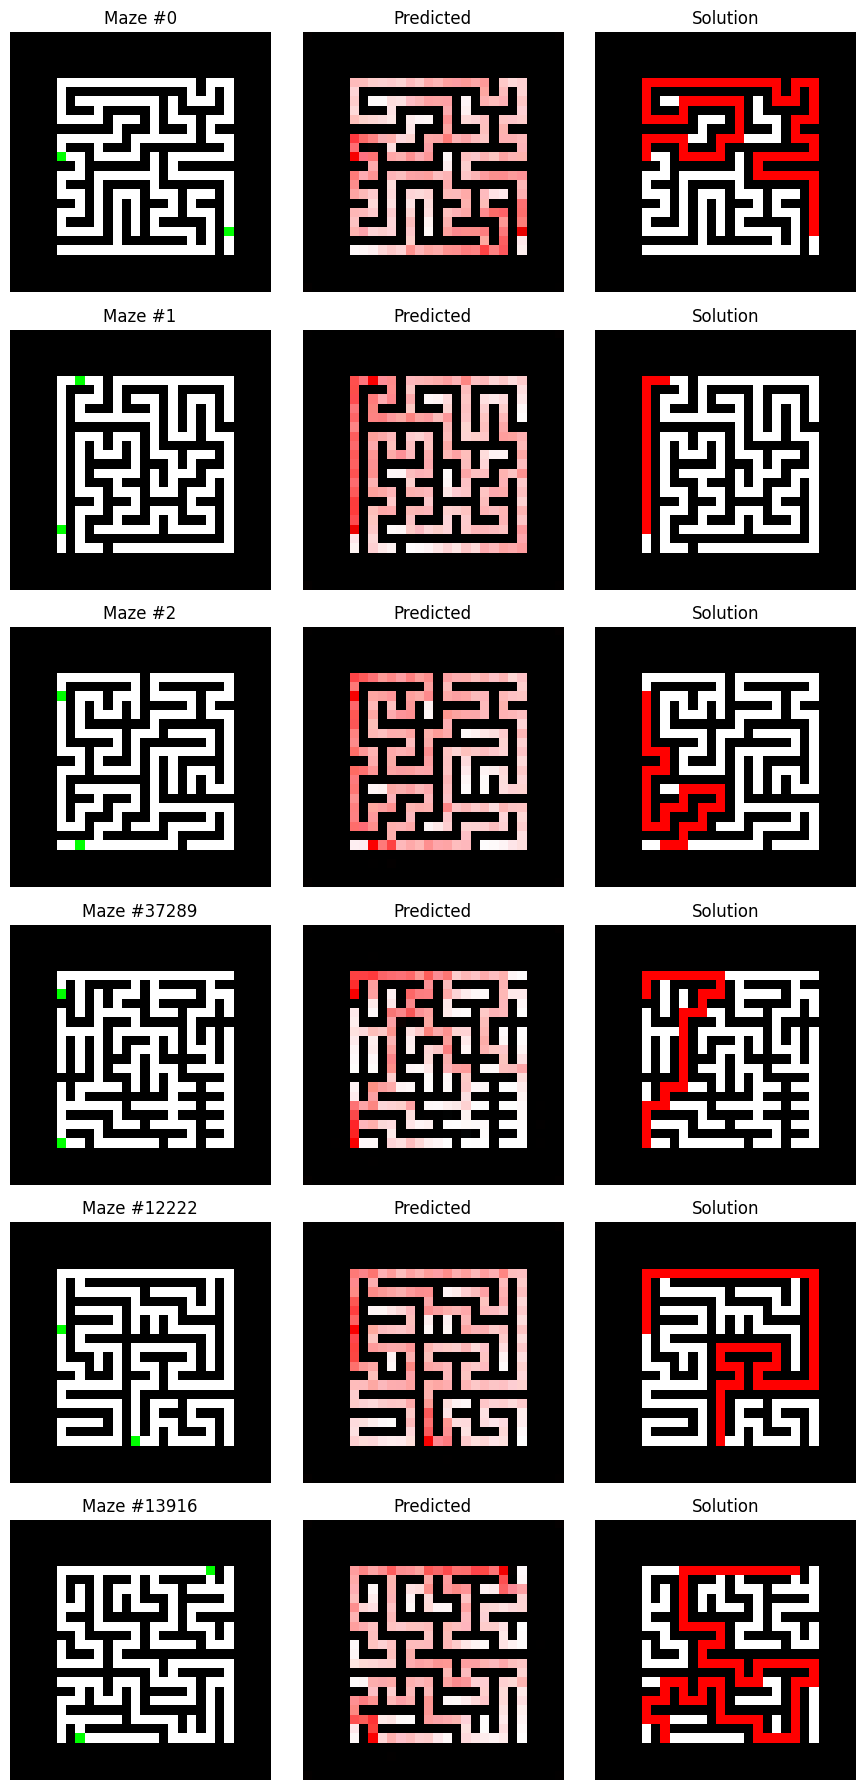

Epoch 2 | D Loss: 527.4711 | G Loss: 8.4091


[Train] Epoch 3/40: 100%|██████████| 782/782 [01:44<00:00,  7.45it/s]


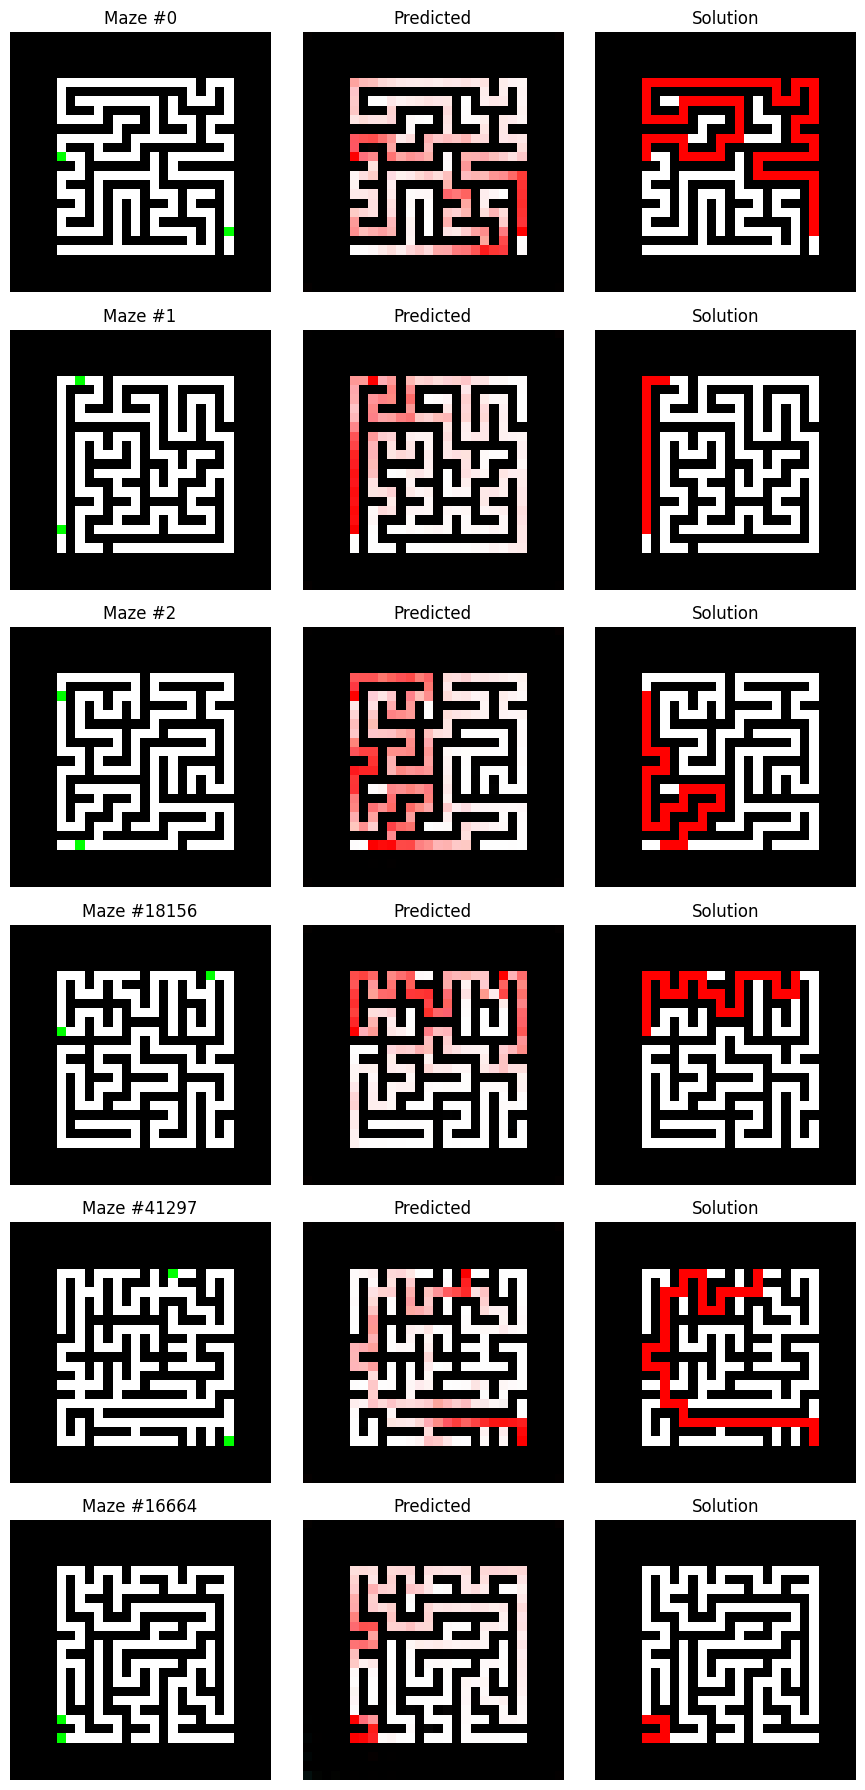

Epoch 3 | D Loss: 535.4794 | G Loss: 5.8954


[Train] Epoch 4/40: 100%|██████████| 782/782 [01:52<00:00,  6.95it/s]


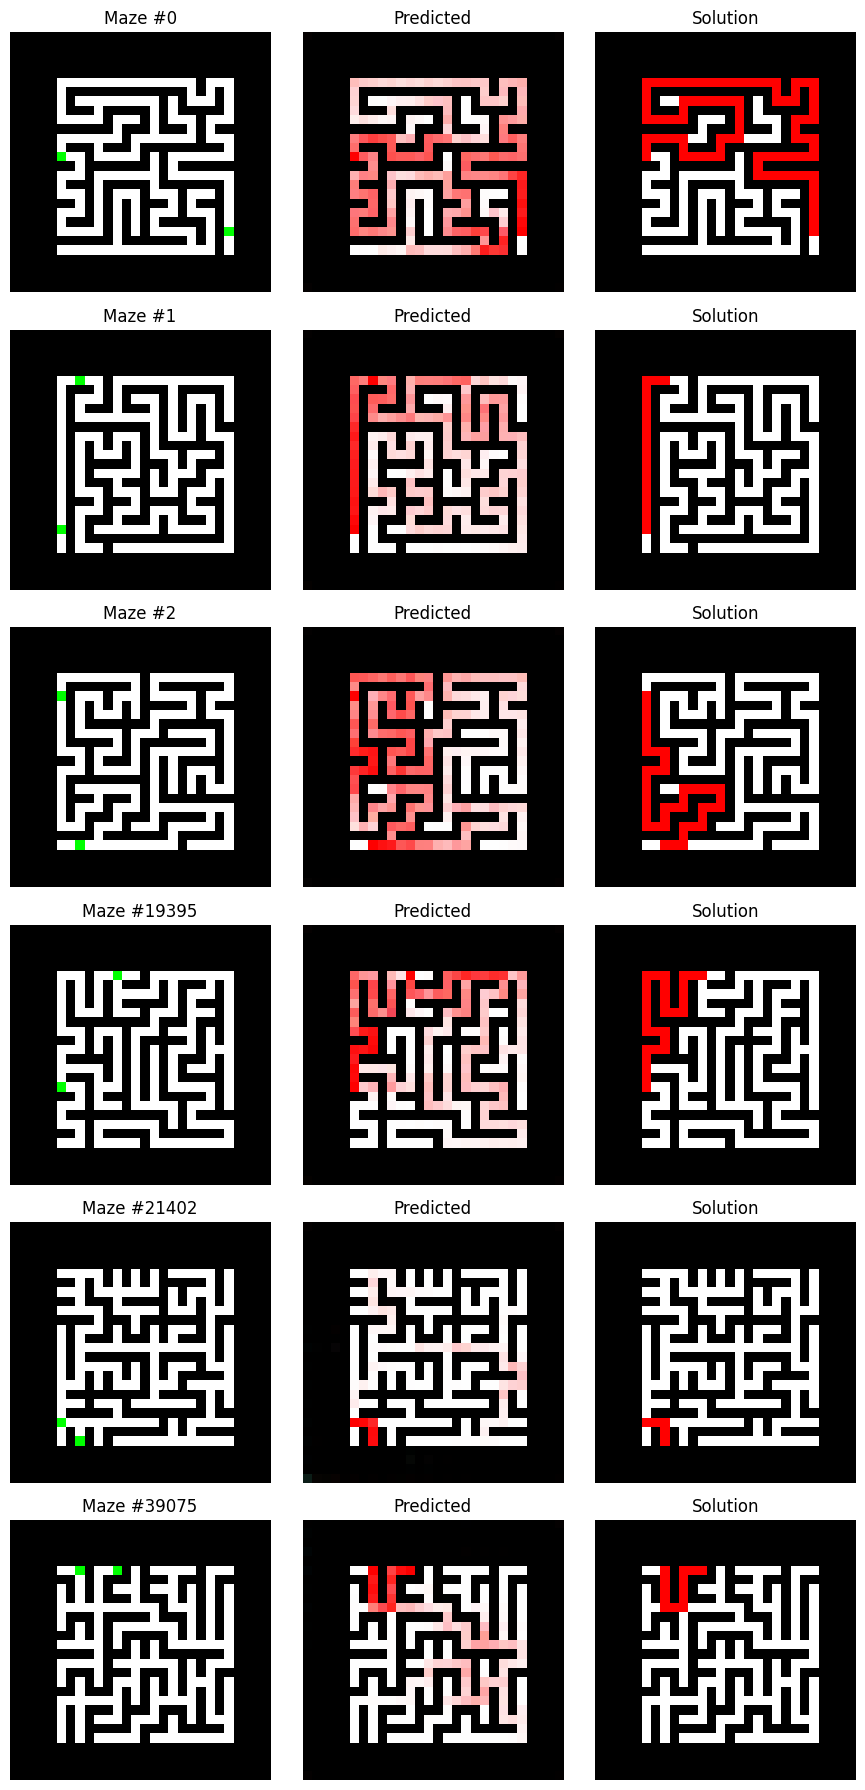

Epoch 4 | D Loss: 538.3780 | G Loss: 5.4475


[Train] Epoch 5/40: 100%|██████████| 782/782 [01:51<00:00,  6.99it/s]


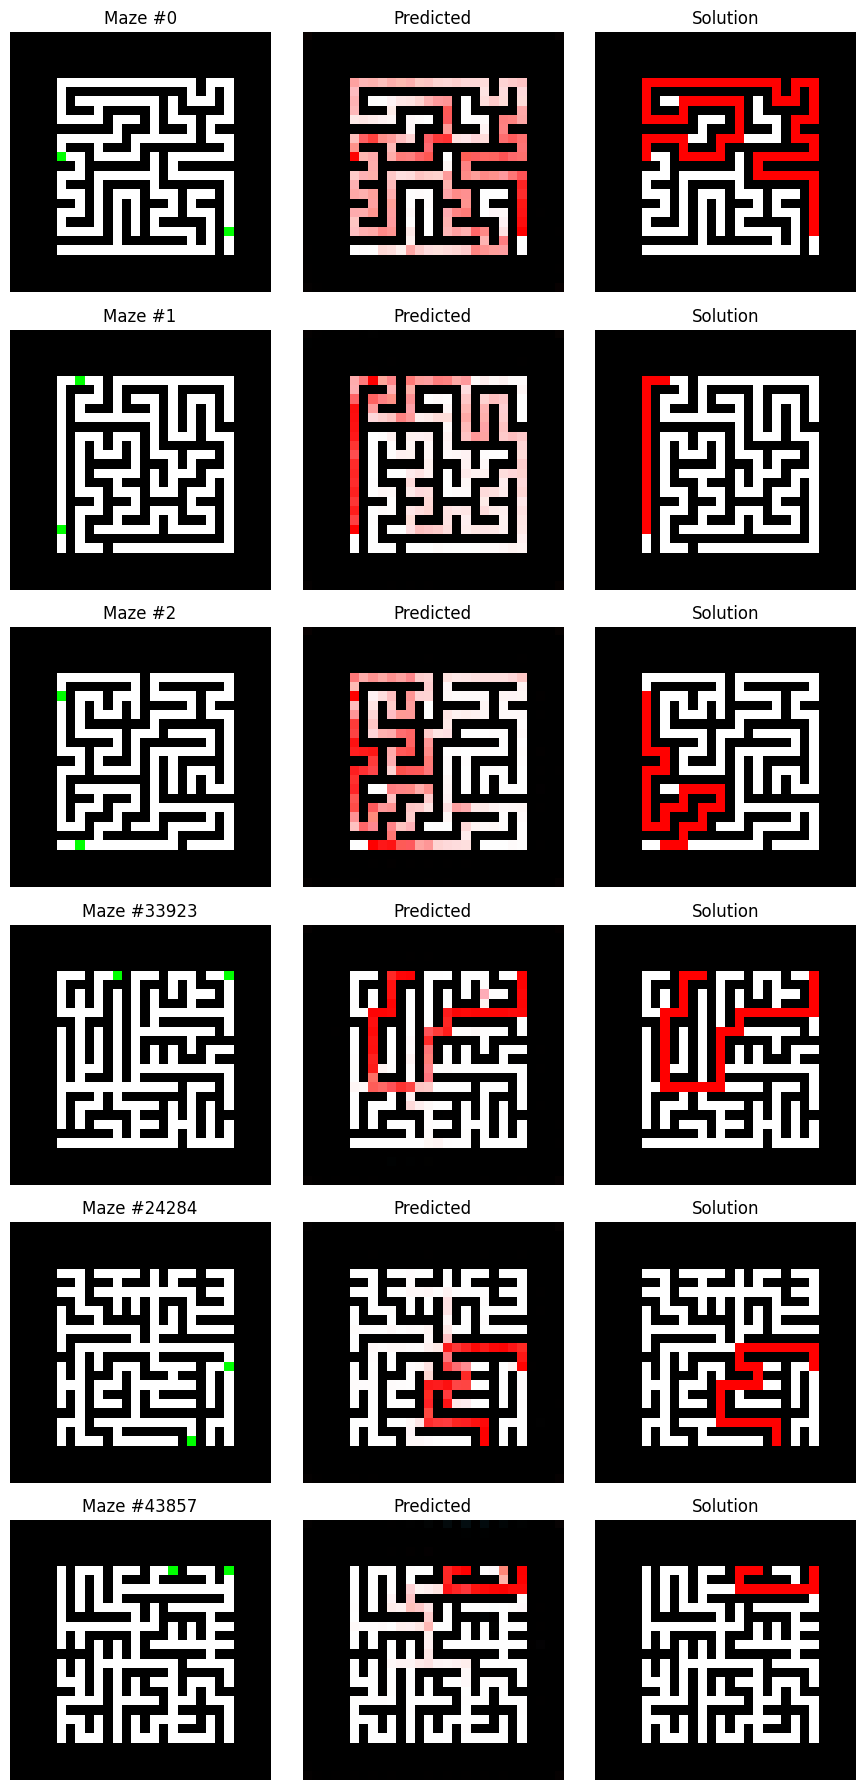

Epoch 5 | D Loss: 539.4292 | G Loss: 4.8254


[Train] Epoch 6/40: 100%|██████████| 782/782 [01:44<00:00,  7.51it/s]


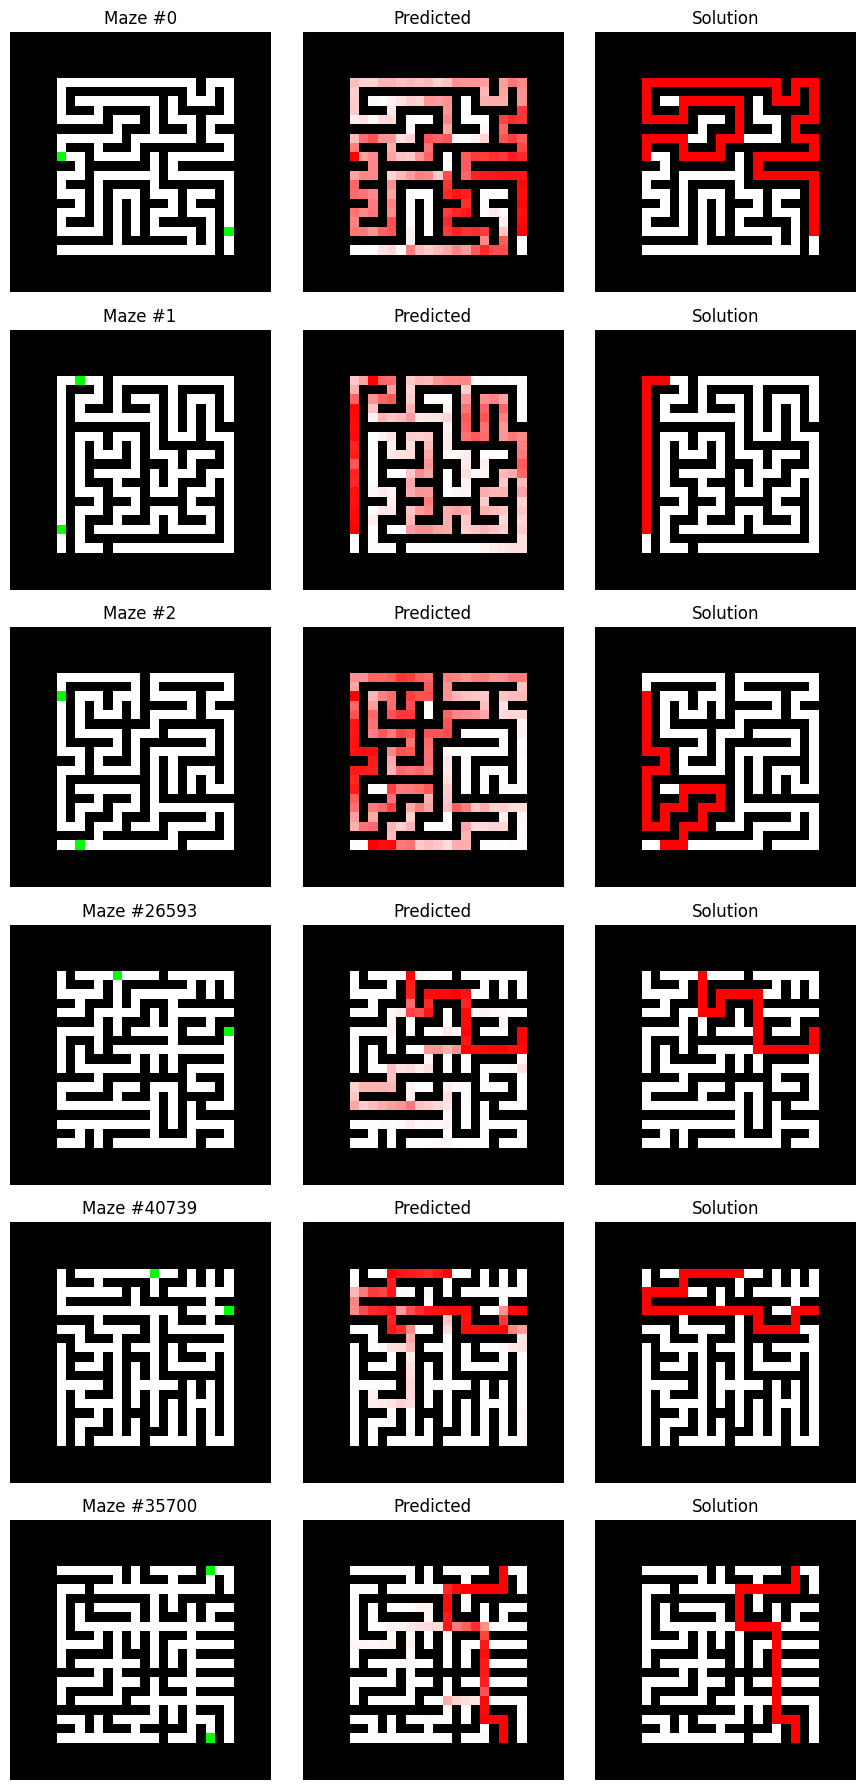

Epoch 6 | D Loss: 540.0206 | G Loss: 5.8344


[Train] Epoch 7/40: 100%|██████████| 782/782 [01:49<00:00,  7.15it/s]


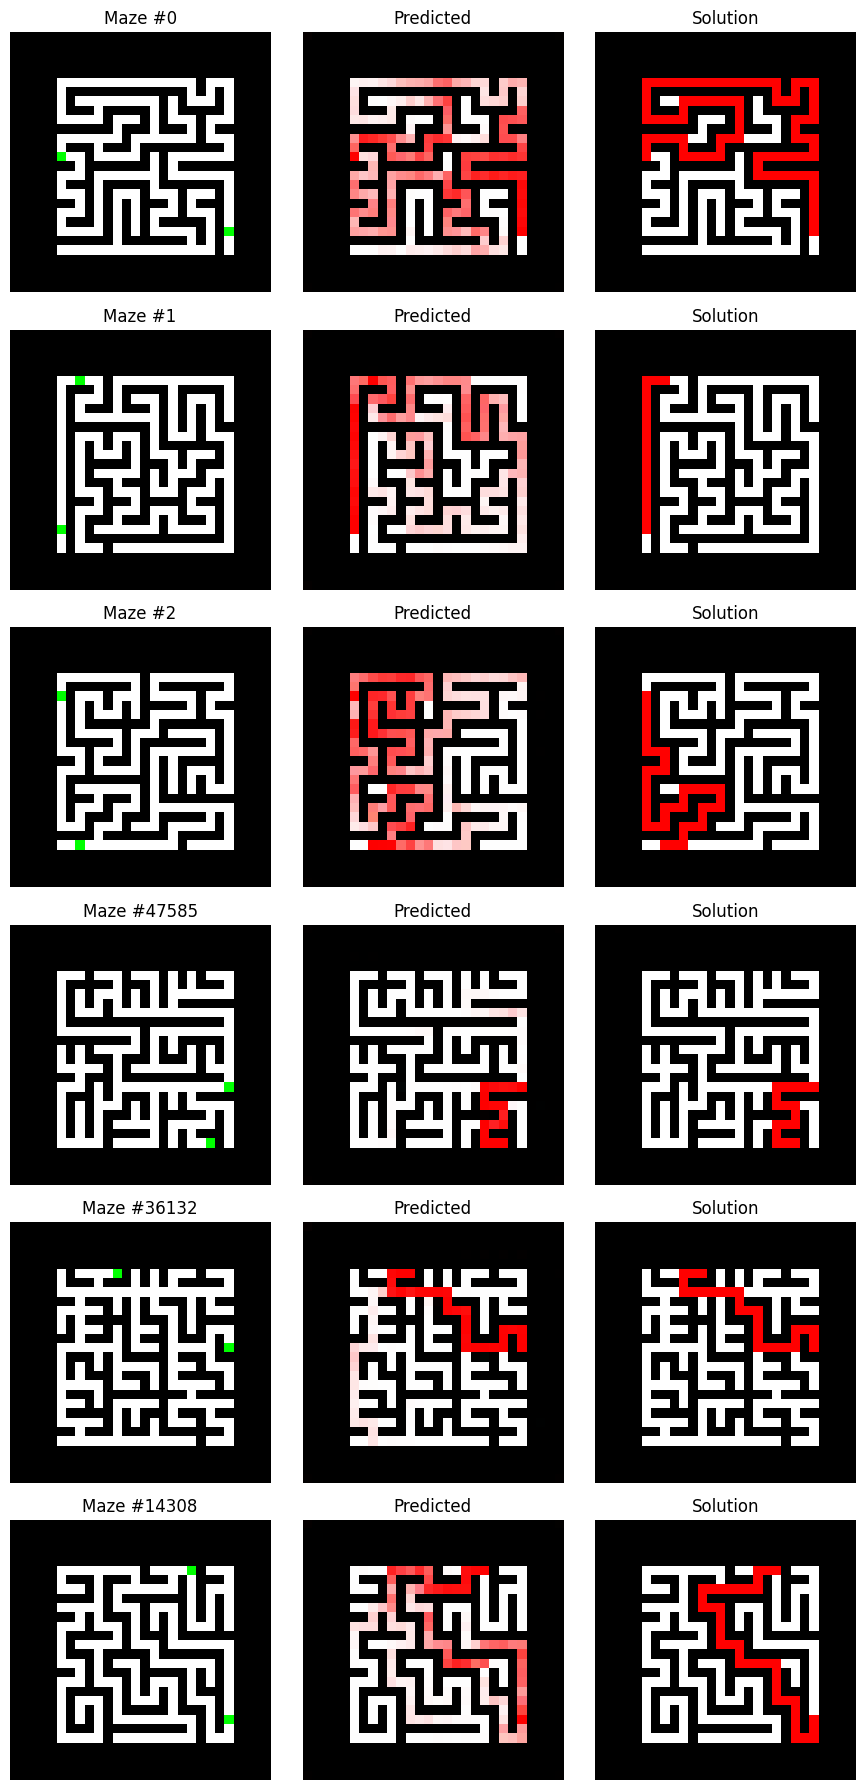

Epoch 7 | D Loss: 540.3406 | G Loss: 2.8924


[Train] Epoch 8/40: 100%|██████████| 782/782 [01:54<00:00,  6.85it/s]


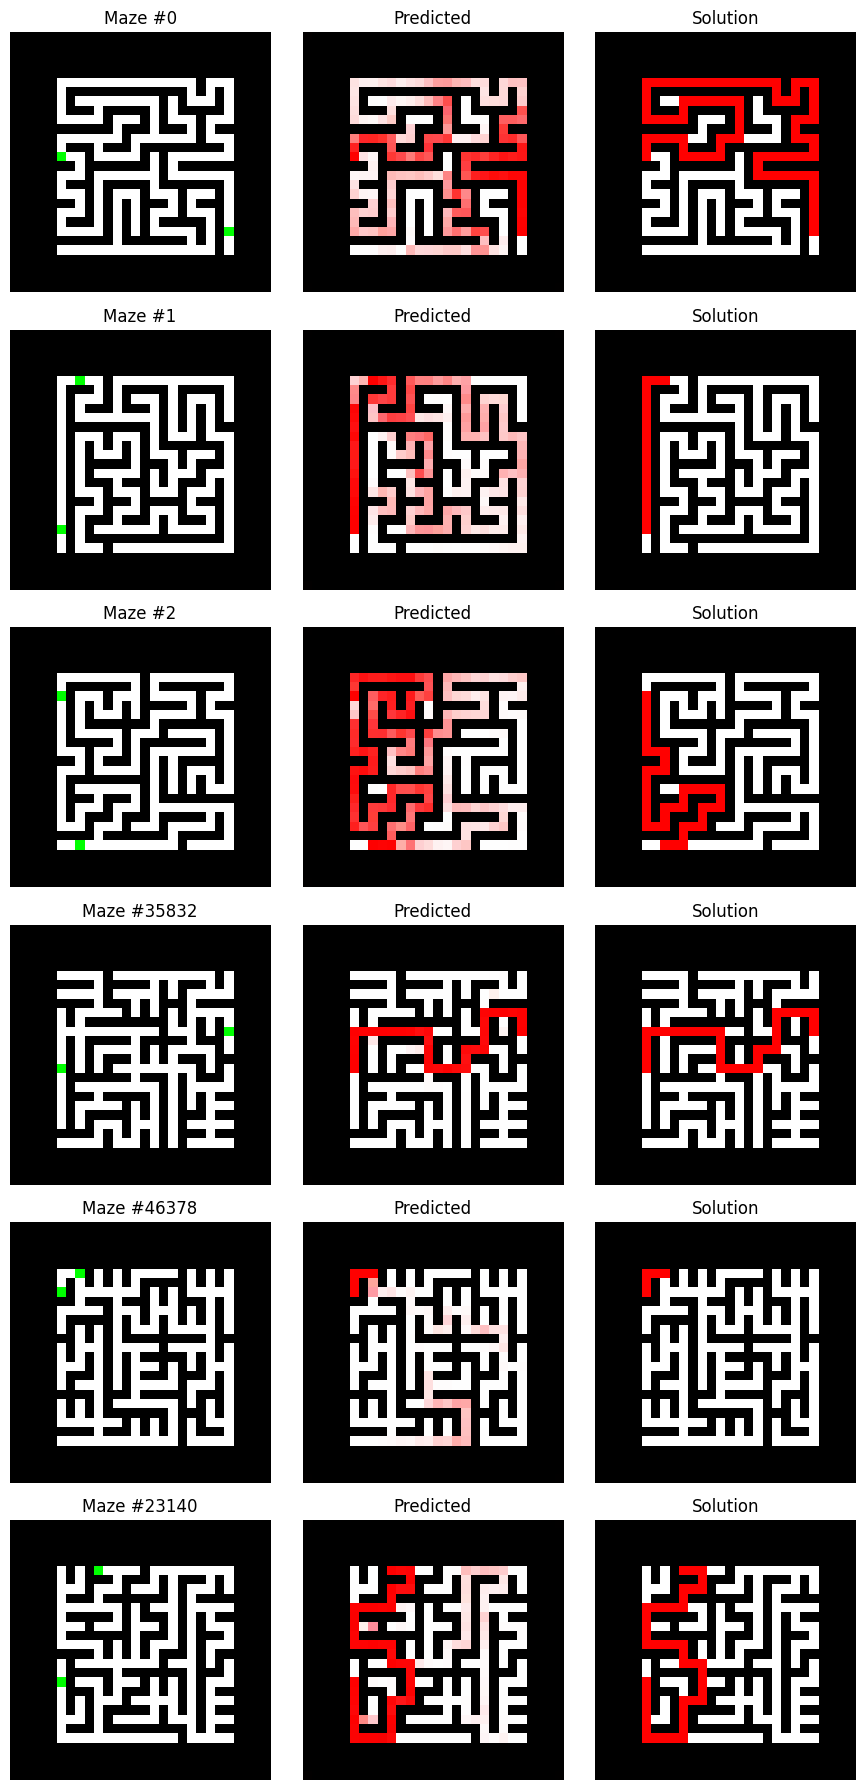

Epoch 8 | D Loss: 540.6045 | G Loss: 3.8693


[Train] Epoch 9/40: 100%|██████████| 782/782 [01:57<00:00,  6.66it/s]


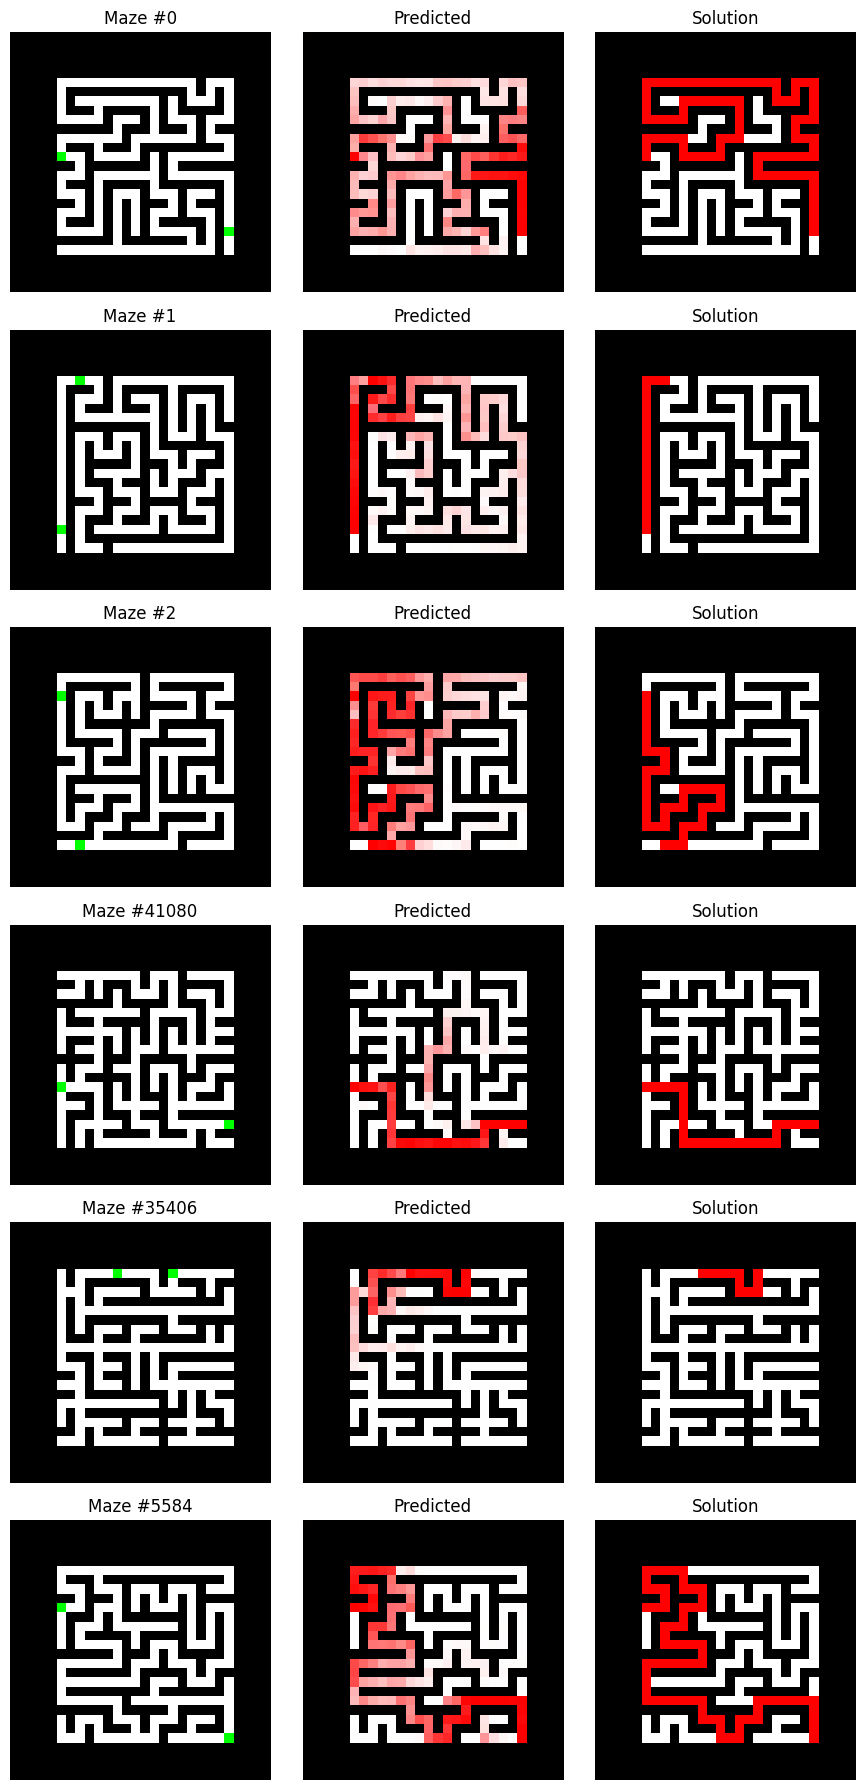

Epoch 9 | D Loss: 540.7594 | G Loss: 4.0884


[Train] Epoch 10/40: 100%|██████████| 782/782 [01:48<00:00,  7.19it/s]


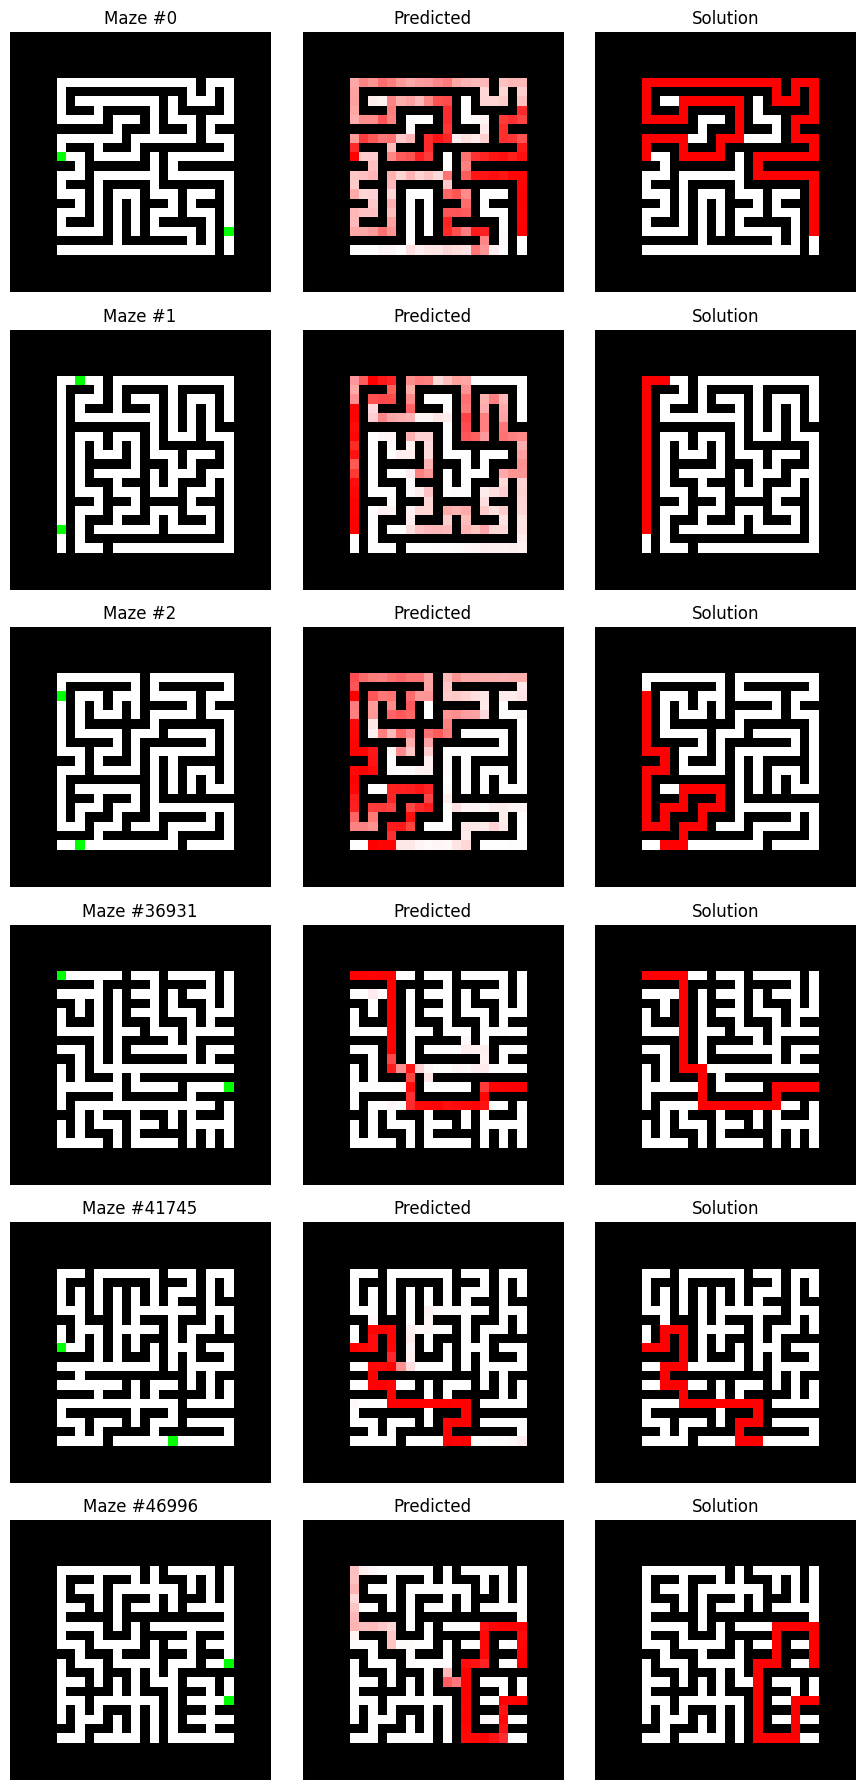

Epoch 10 | D Loss: 540.8851 | G Loss: 2.6177


[Train] Epoch 11/40: 100%|██████████| 782/782 [01:50<00:00,  7.10it/s]


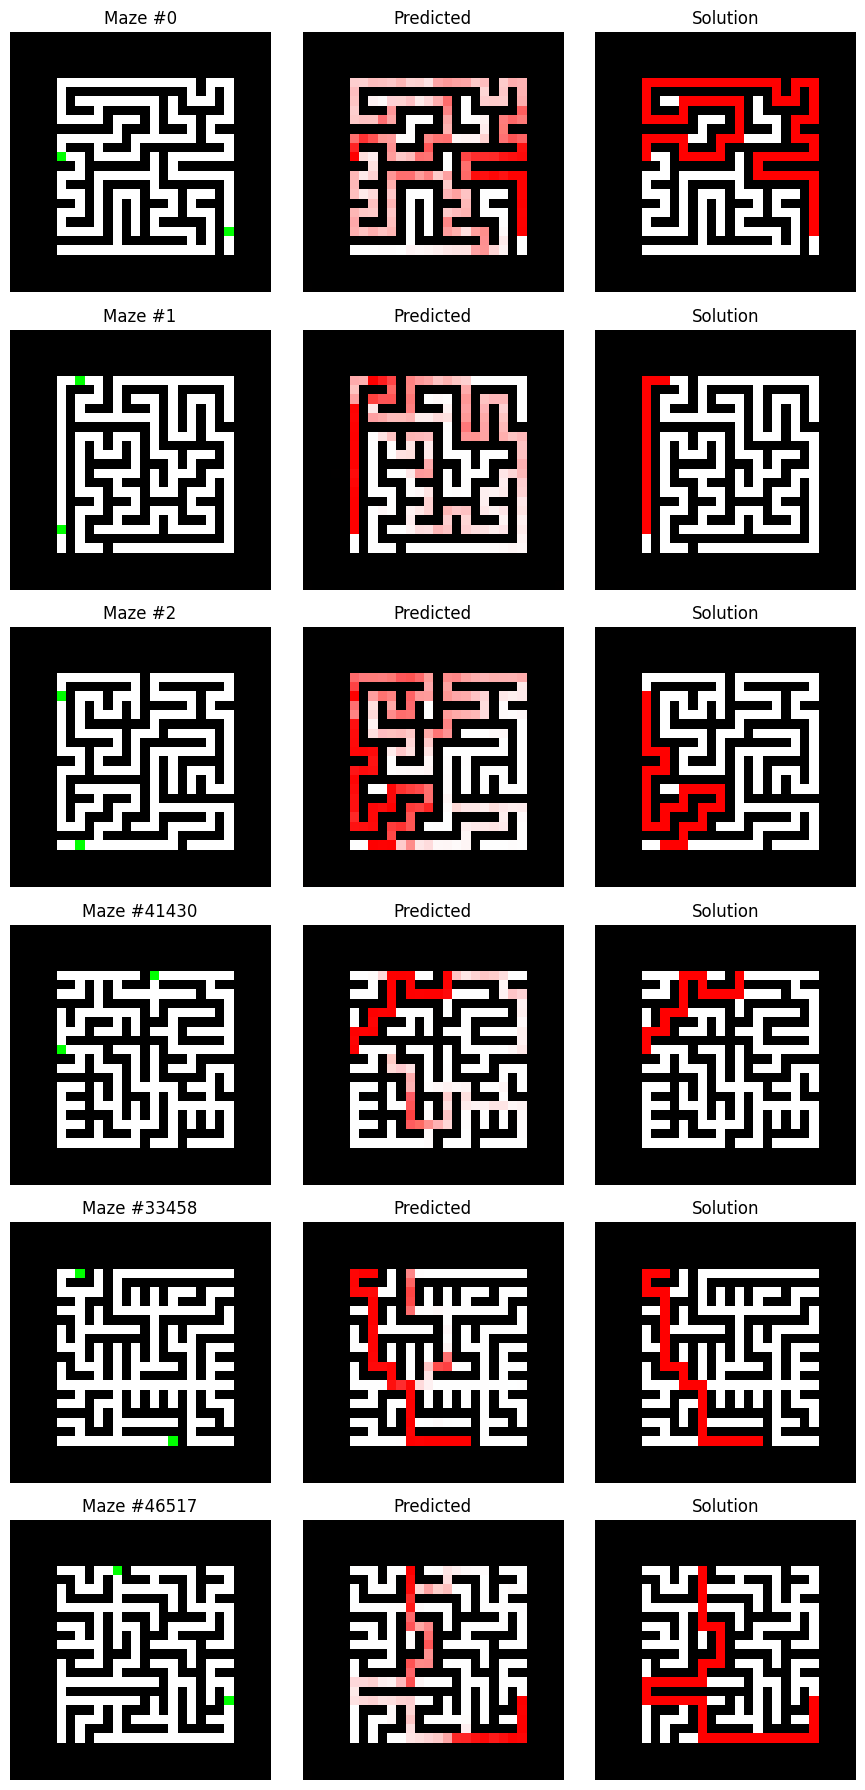

Epoch 11 | D Loss: 540.9776 | G Loss: 3.5321


[Train] Epoch 12/40: 100%|██████████| 782/782 [01:50<00:00,  7.08it/s]


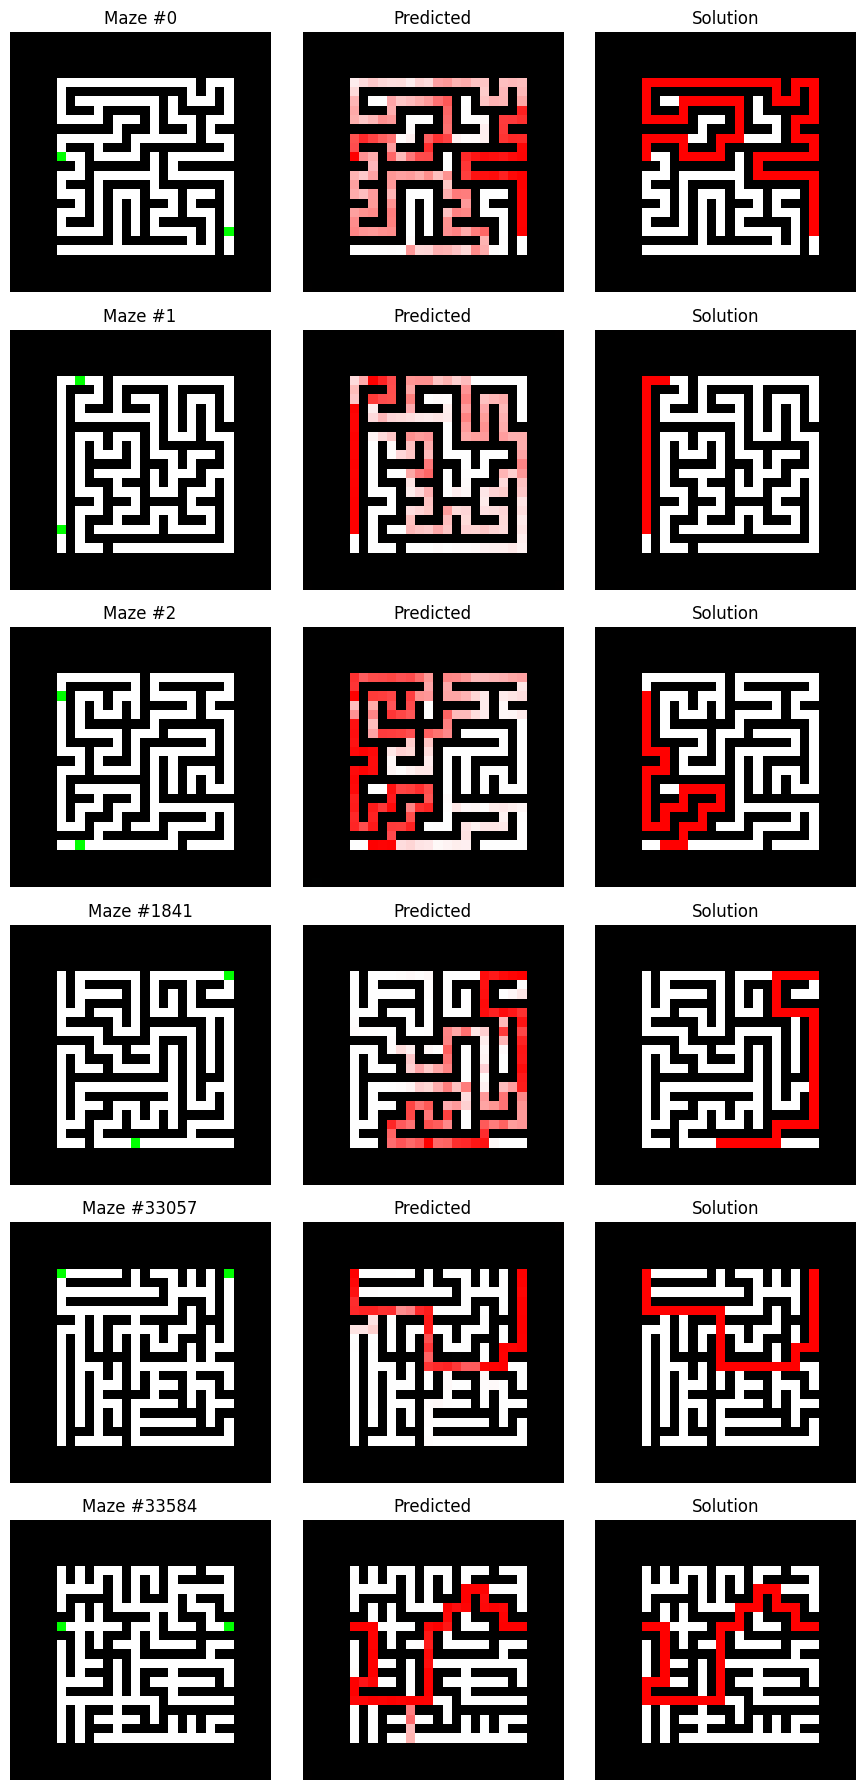

Epoch 12 | D Loss: 541.0442 | G Loss: 3.9863


[Train] Epoch 13/40: 100%|██████████| 782/782 [01:44<00:00,  7.52it/s]


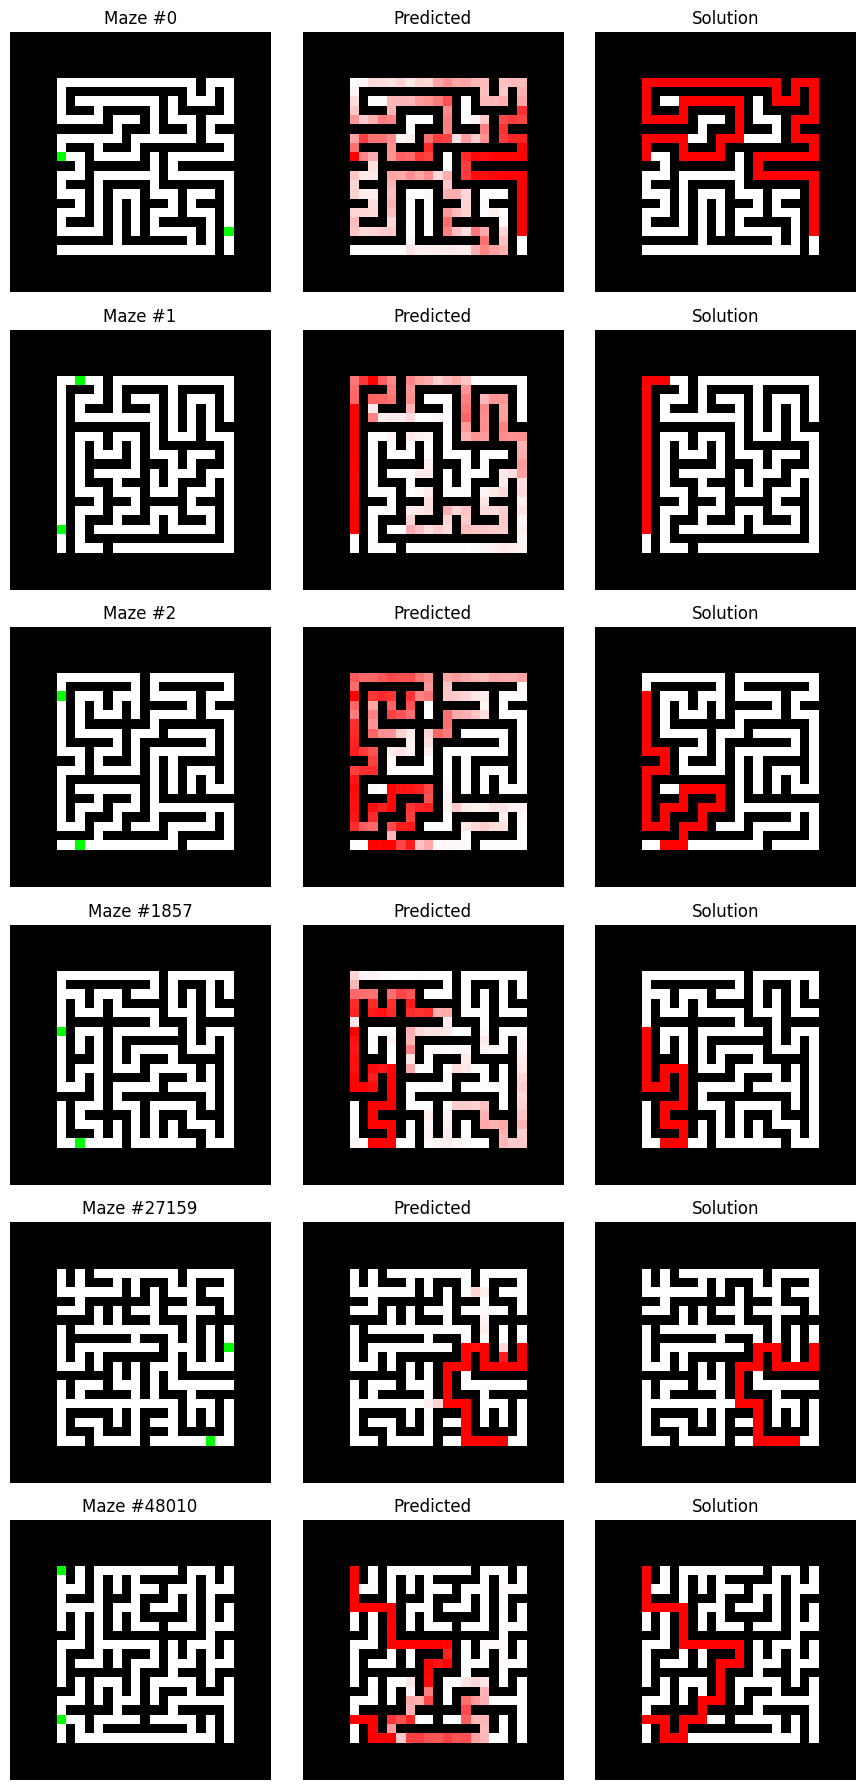

Epoch 13 | D Loss: 541.1157 | G Loss: 2.3280


[Train] Epoch 14/40: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s]


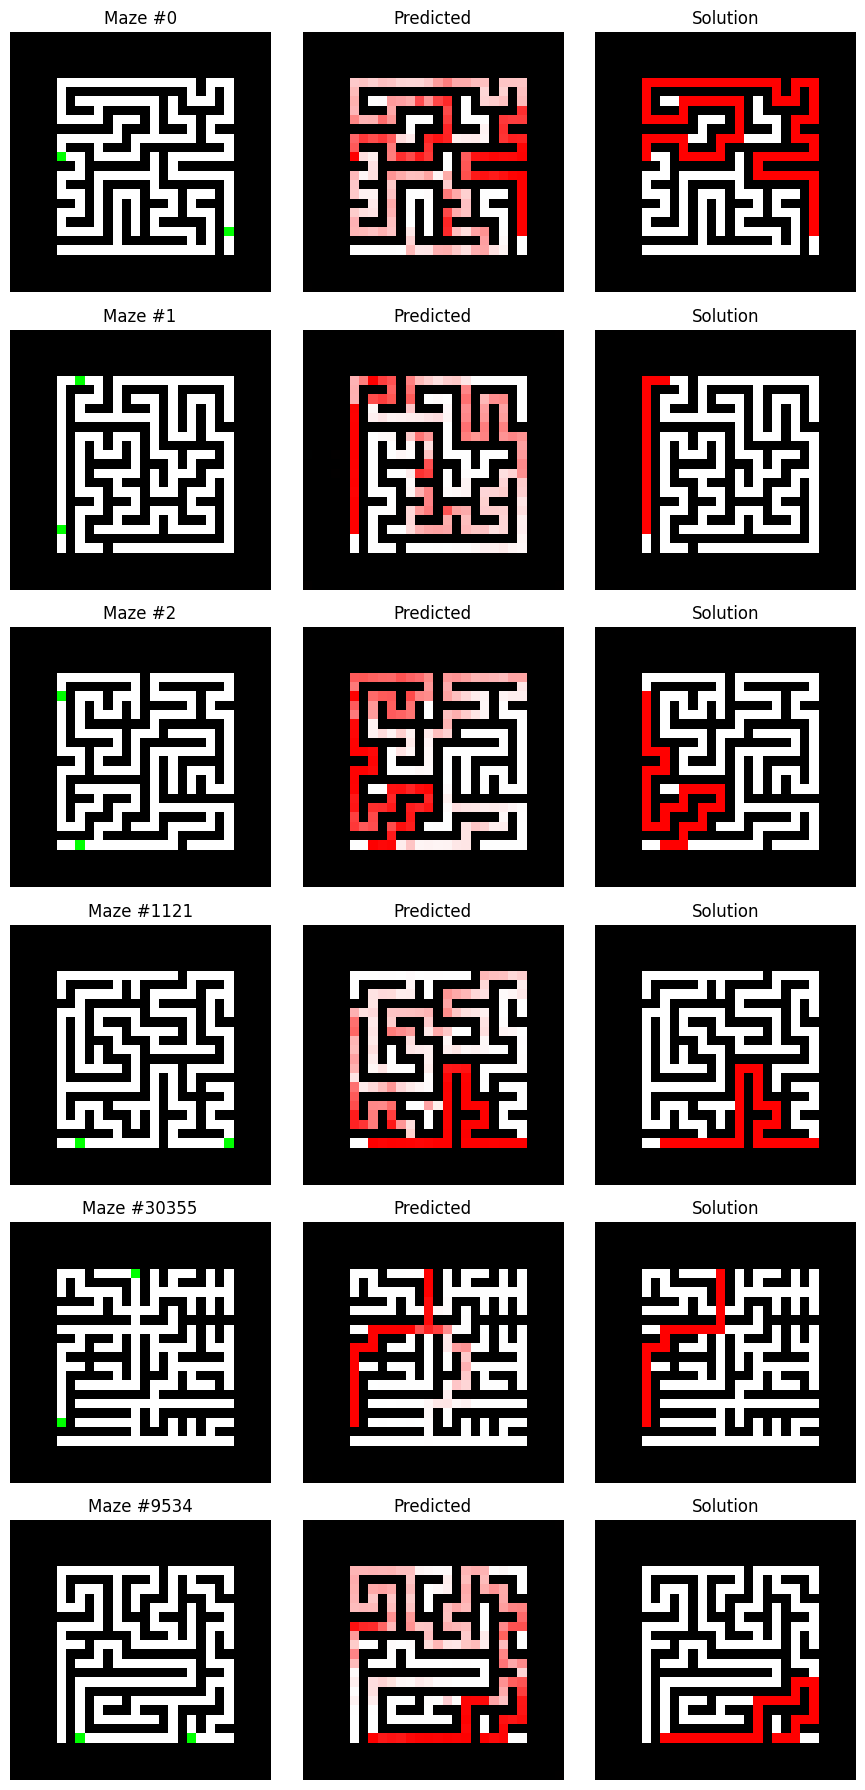

Epoch 14 | D Loss: 541.1618 | G Loss: 2.2267


[Train] Epoch 15/40: 100%|██████████| 782/782 [01:45<00:00,  7.39it/s]


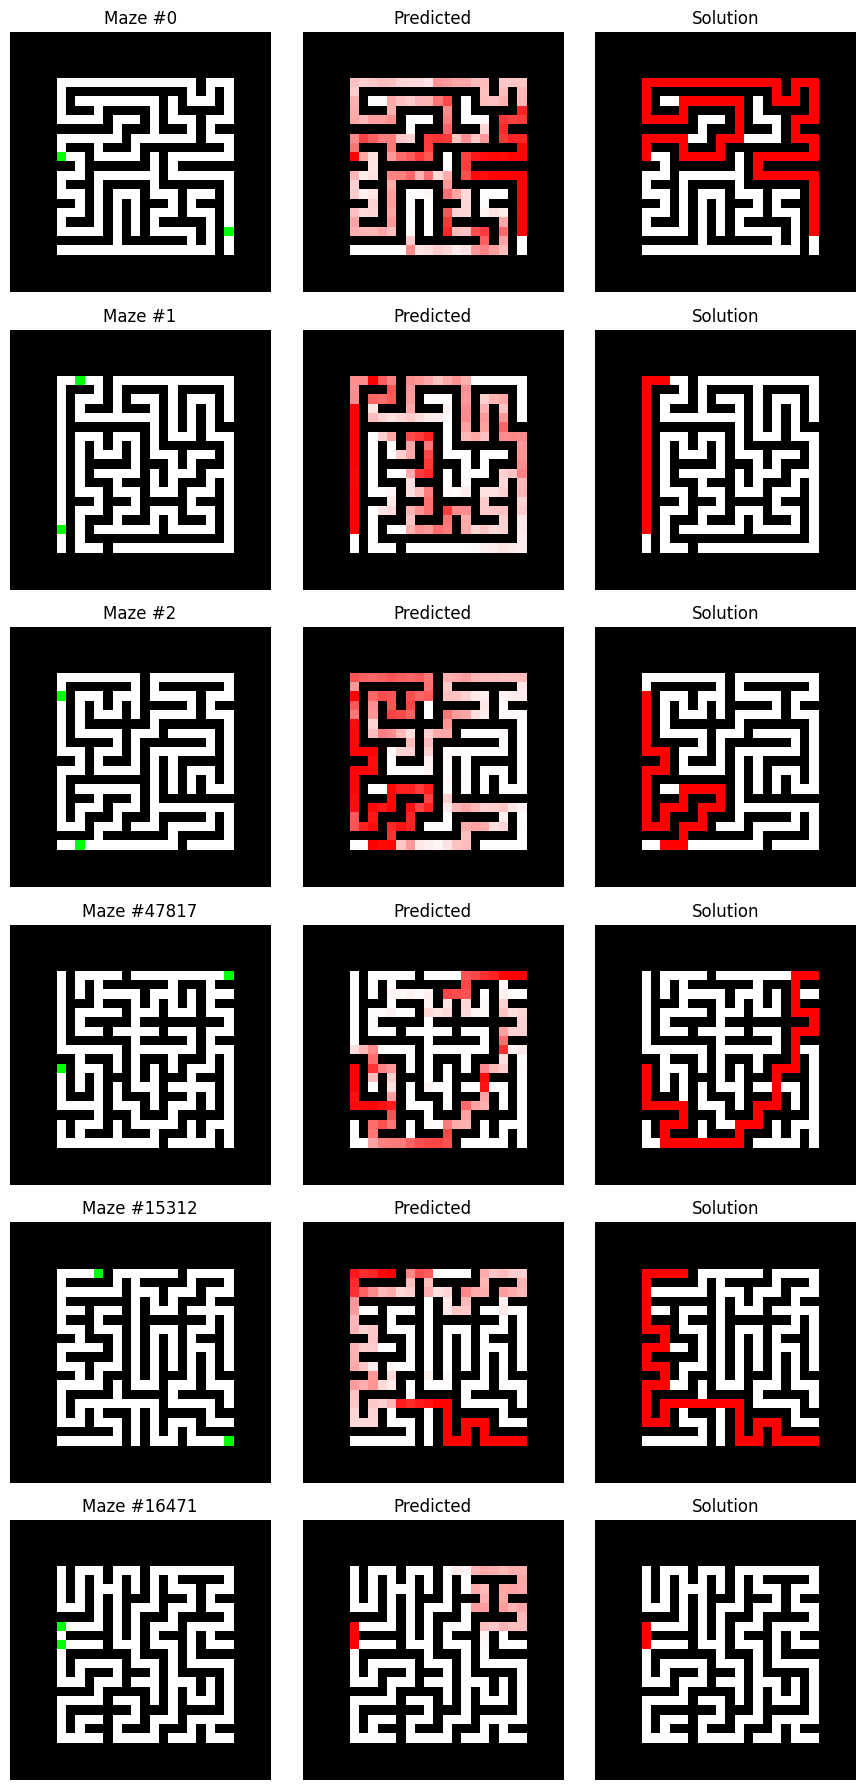

Epoch 15 | D Loss: 541.1995 | G Loss: 3.8068


[Train] Epoch 16/40: 100%|██████████| 782/782 [01:52<00:00,  6.93it/s]


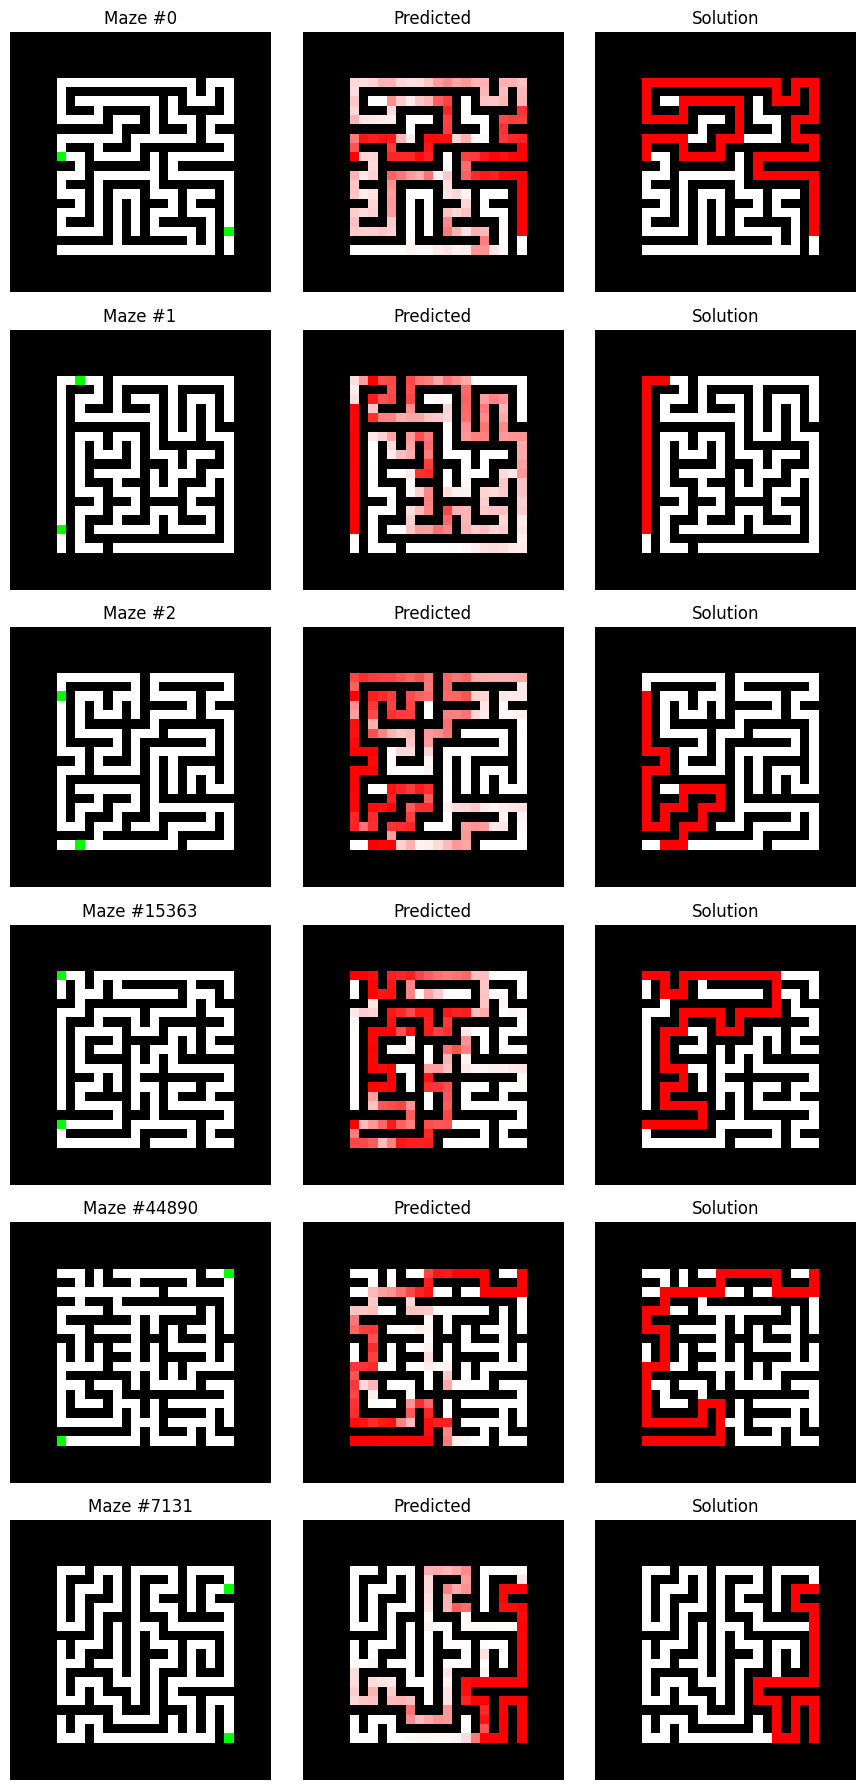

Epoch 16 | D Loss: 541.2359 | G Loss: 2.8265


[Train] Epoch 17/40: 100%|██████████| 782/782 [01:47<00:00,  7.30it/s]


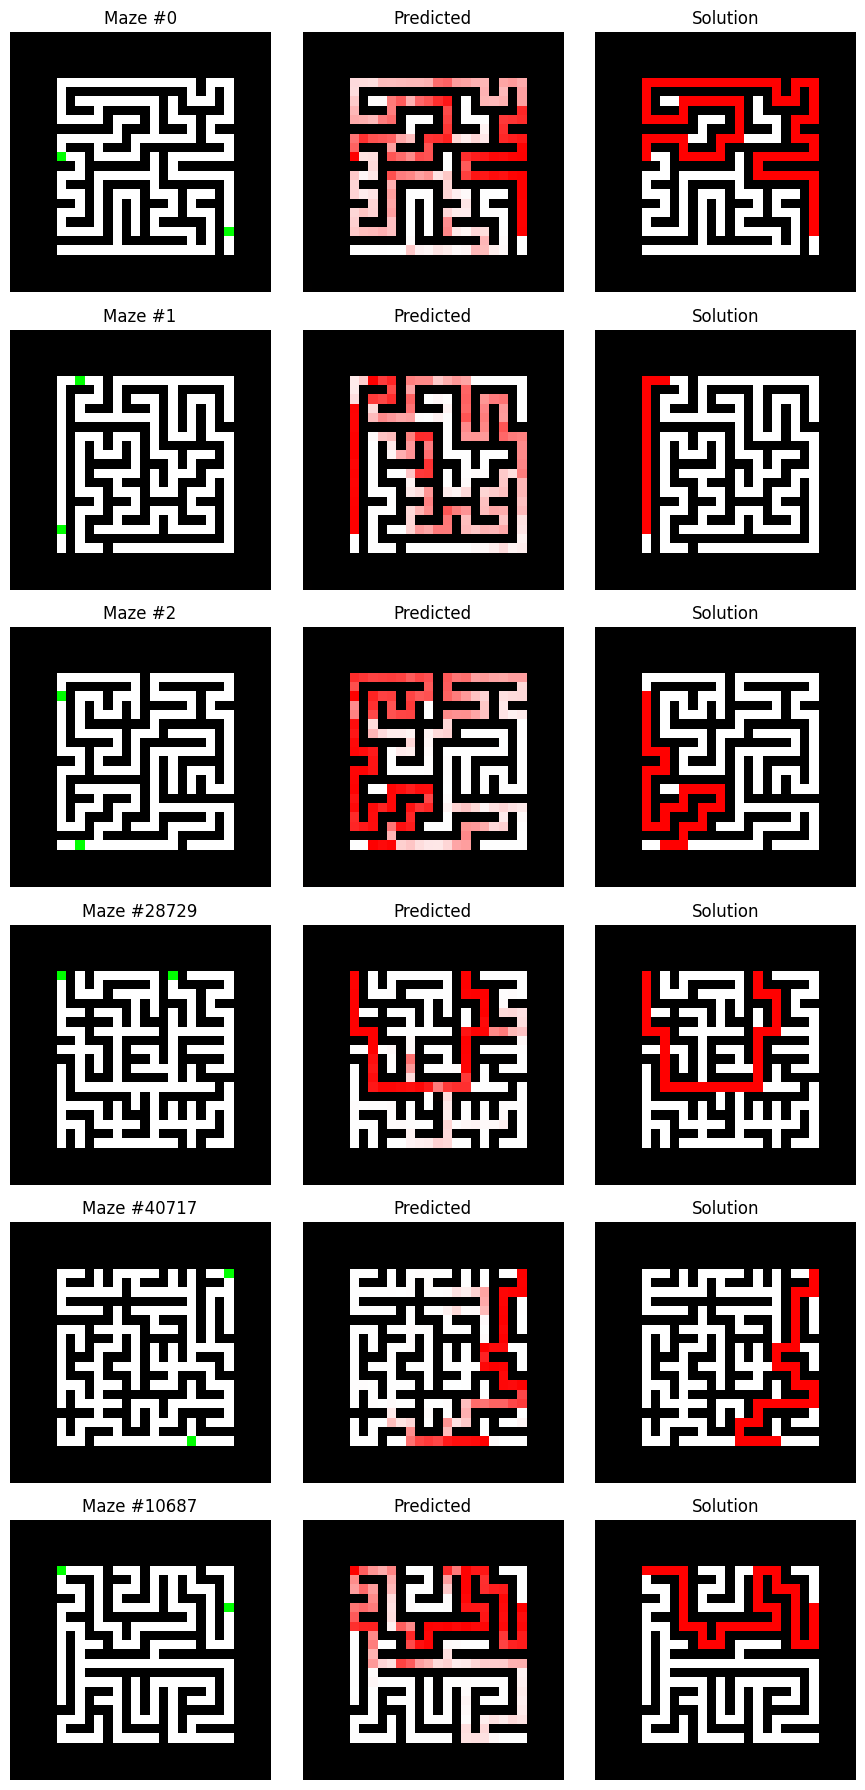

Epoch 17 | D Loss: 541.2658 | G Loss: 3.2012


[Train] Epoch 18/40: 100%|██████████| 782/782 [01:44<00:00,  7.52it/s]


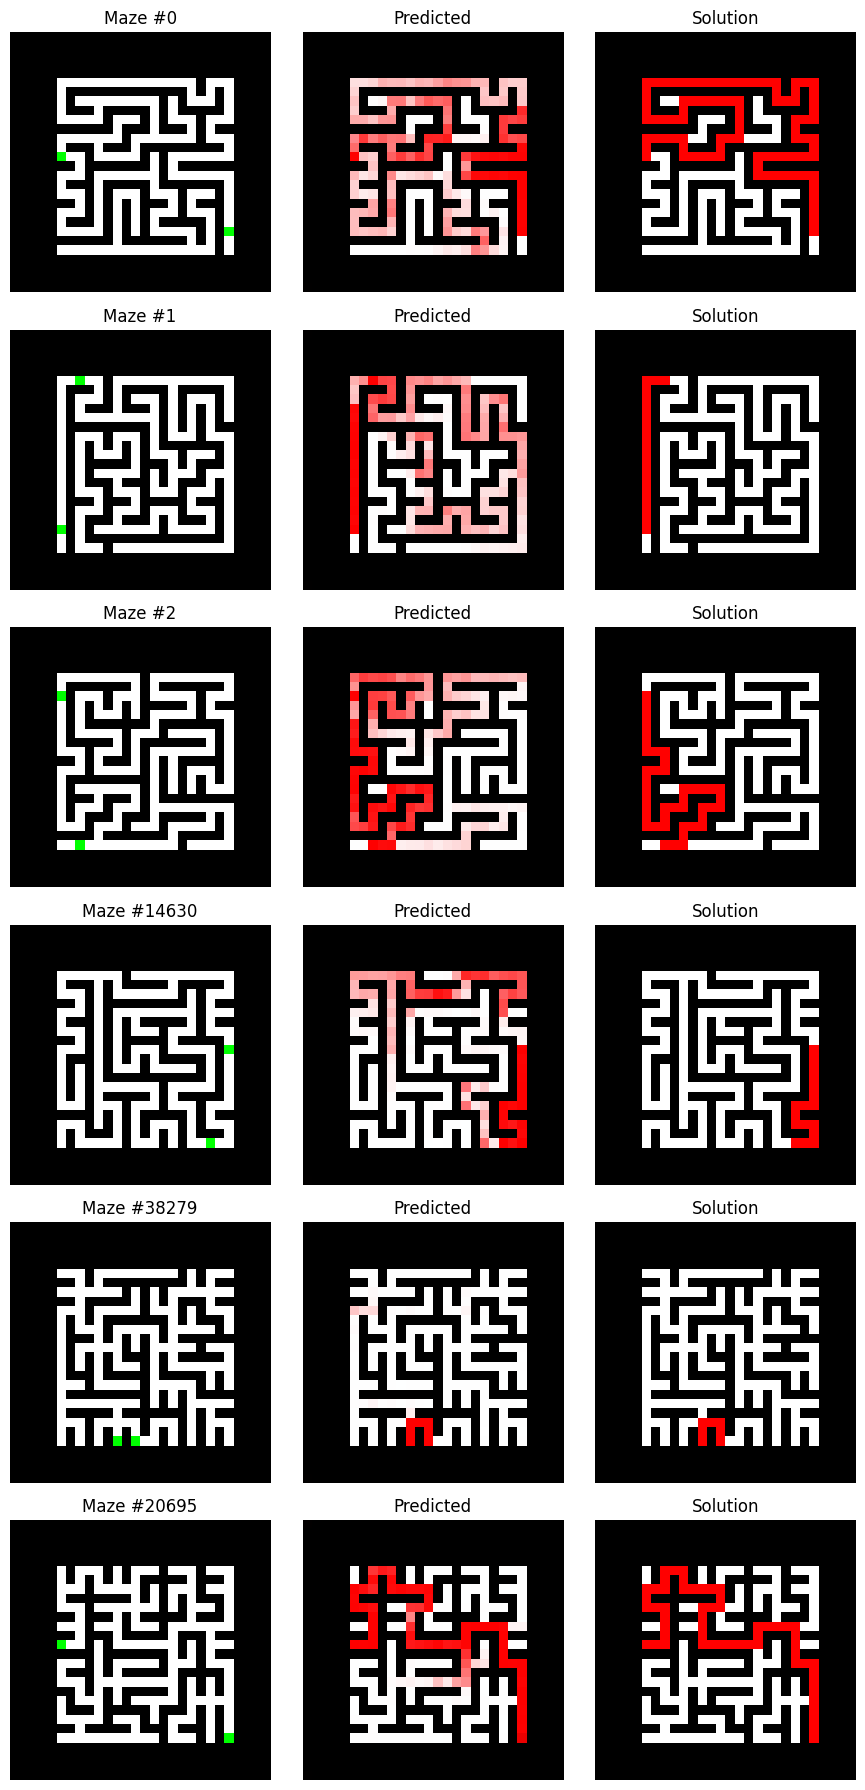

Epoch 18 | D Loss: 541.2939 | G Loss: 3.5452


[Train] Epoch 19/40: 100%|██████████| 782/782 [01:43<00:00,  7.55it/s]


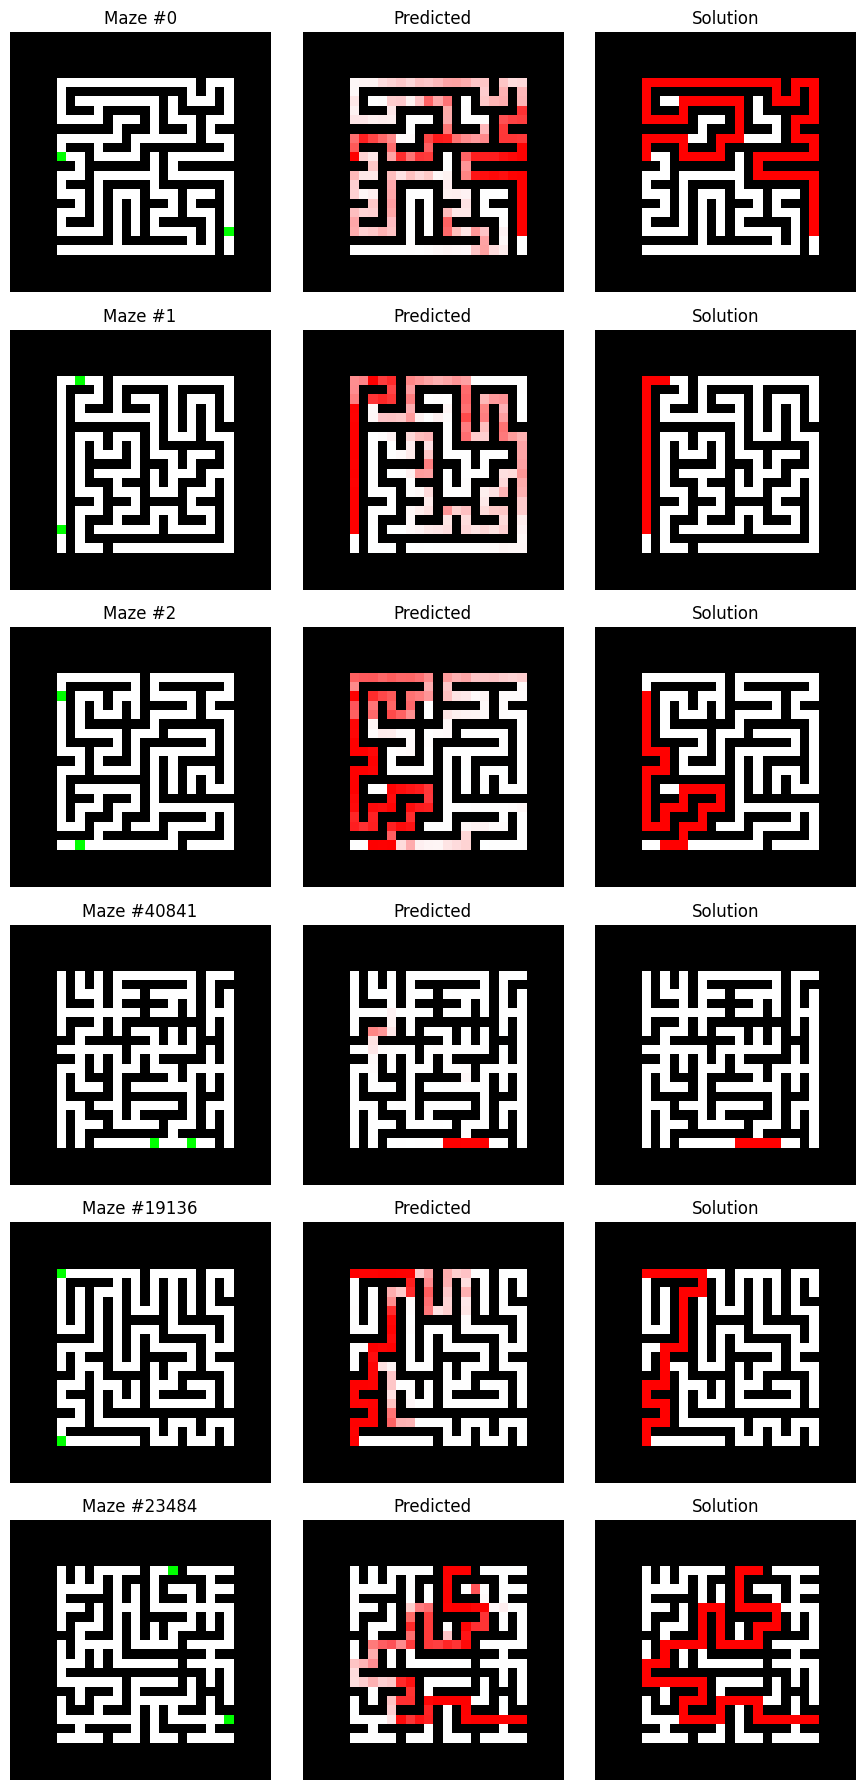

Epoch 19 | D Loss: 541.3158 | G Loss: 2.6515


[Train] Epoch 20/40: 100%|██████████| 782/782 [01:43<00:00,  7.56it/s]


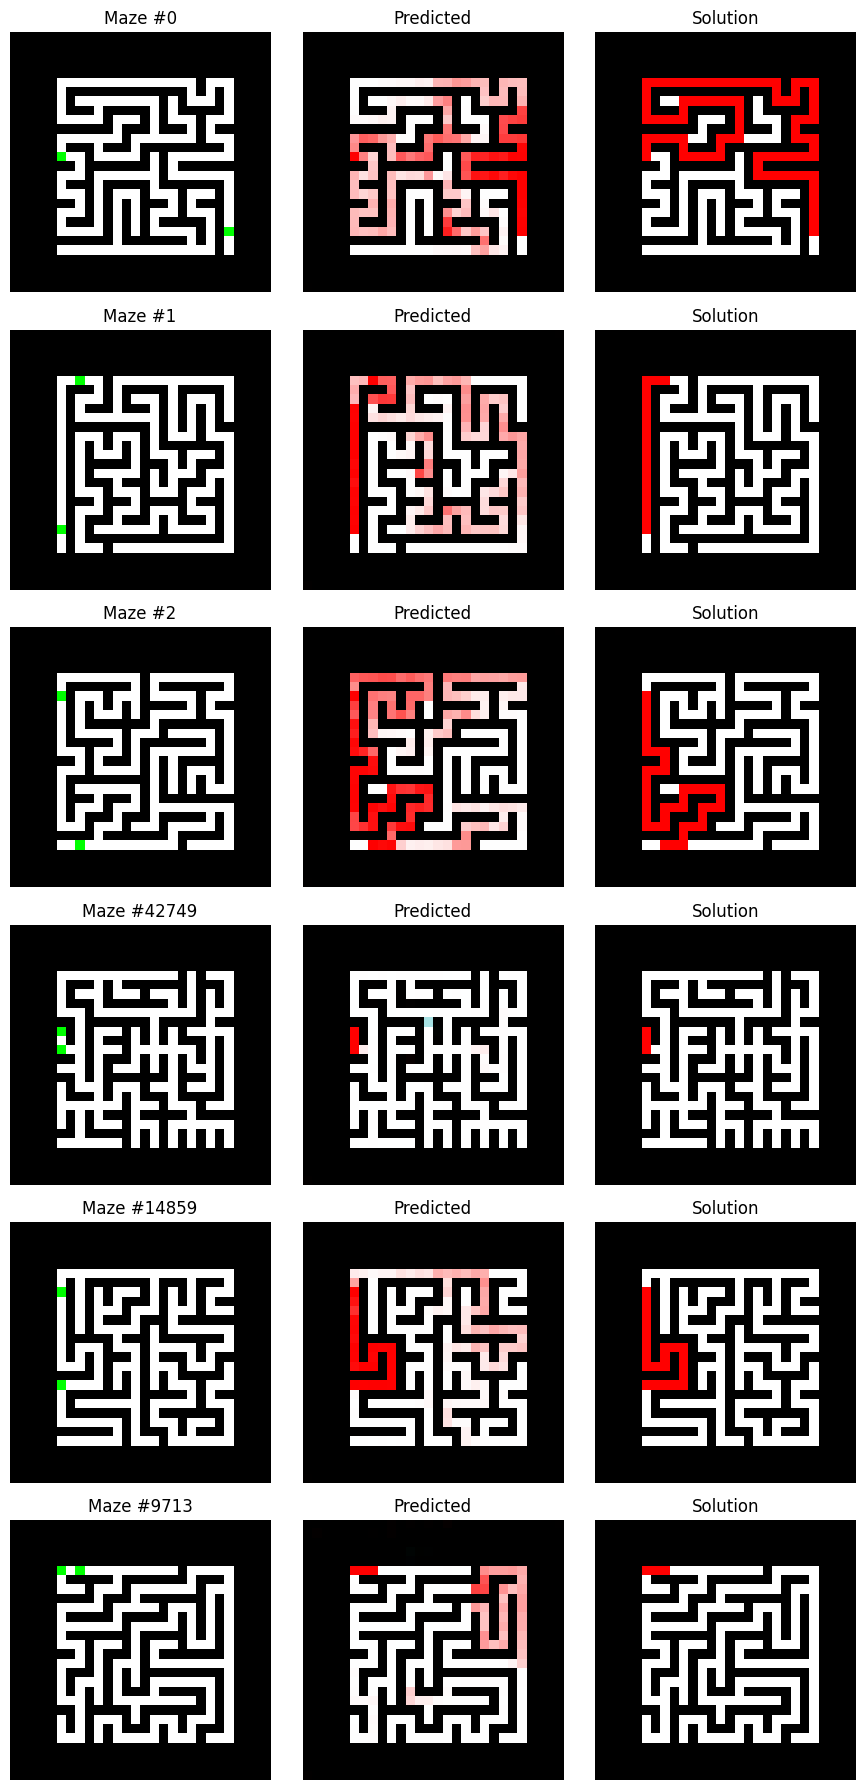

Epoch 20 | D Loss: 541.3417 | G Loss: 1.8820


[Train] Epoch 21/40: 100%|██████████| 782/782 [01:44<00:00,  7.50it/s]


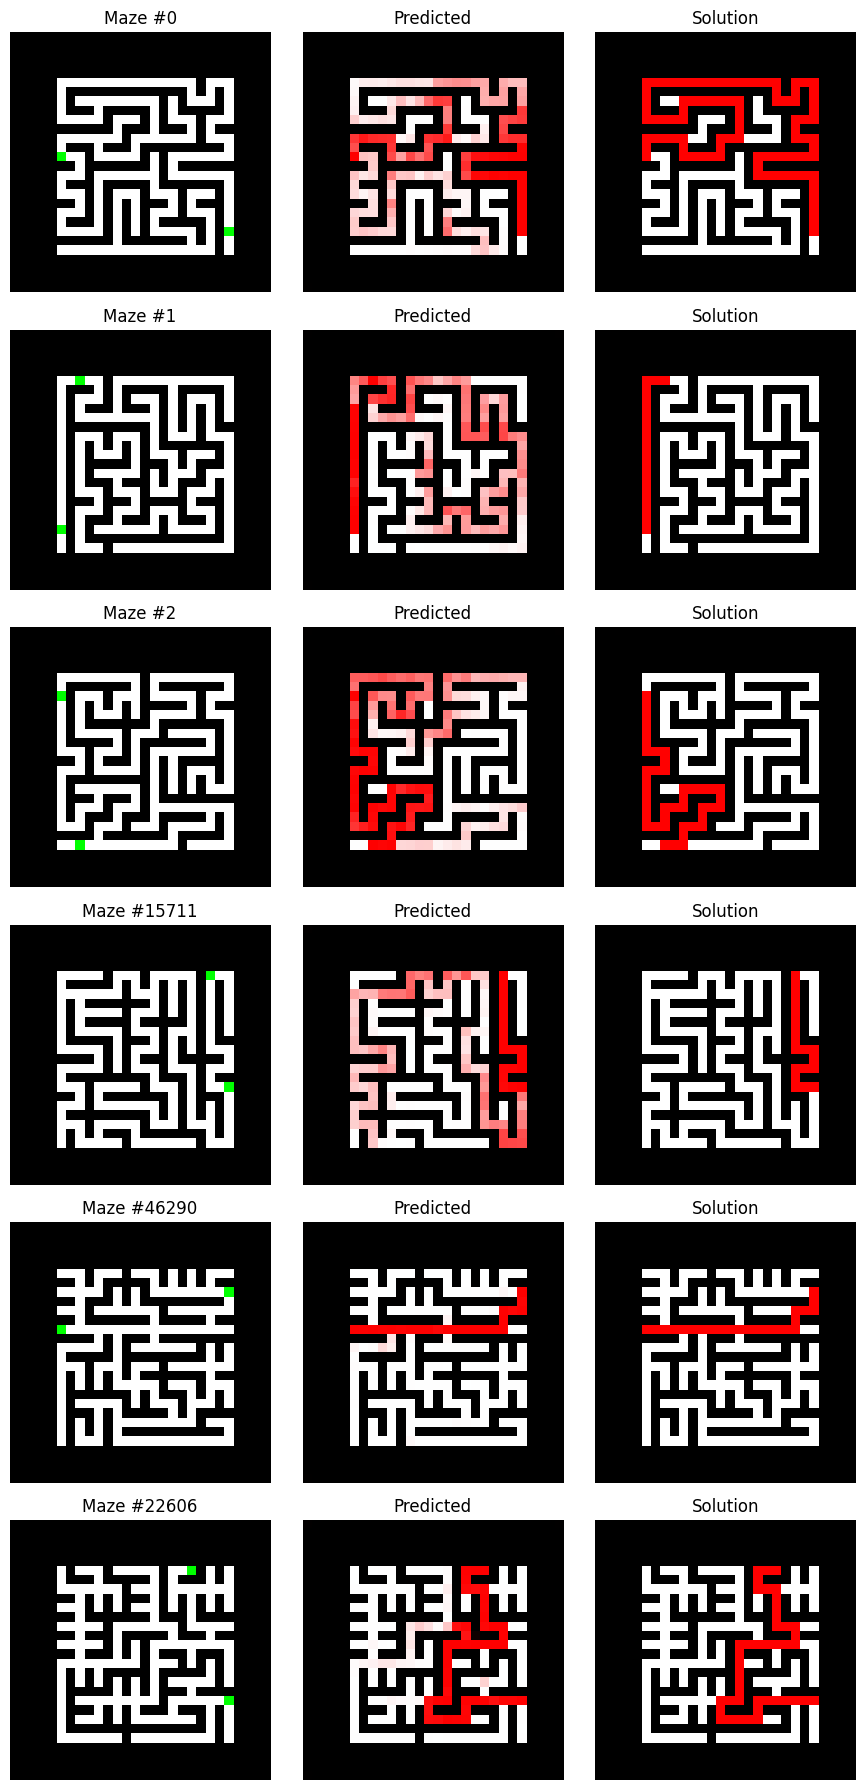

Epoch 21 | D Loss: 541.3692 | G Loss: 3.4978


[Train] Epoch 22/40: 100%|██████████| 782/782 [01:44<00:00,  7.50it/s]


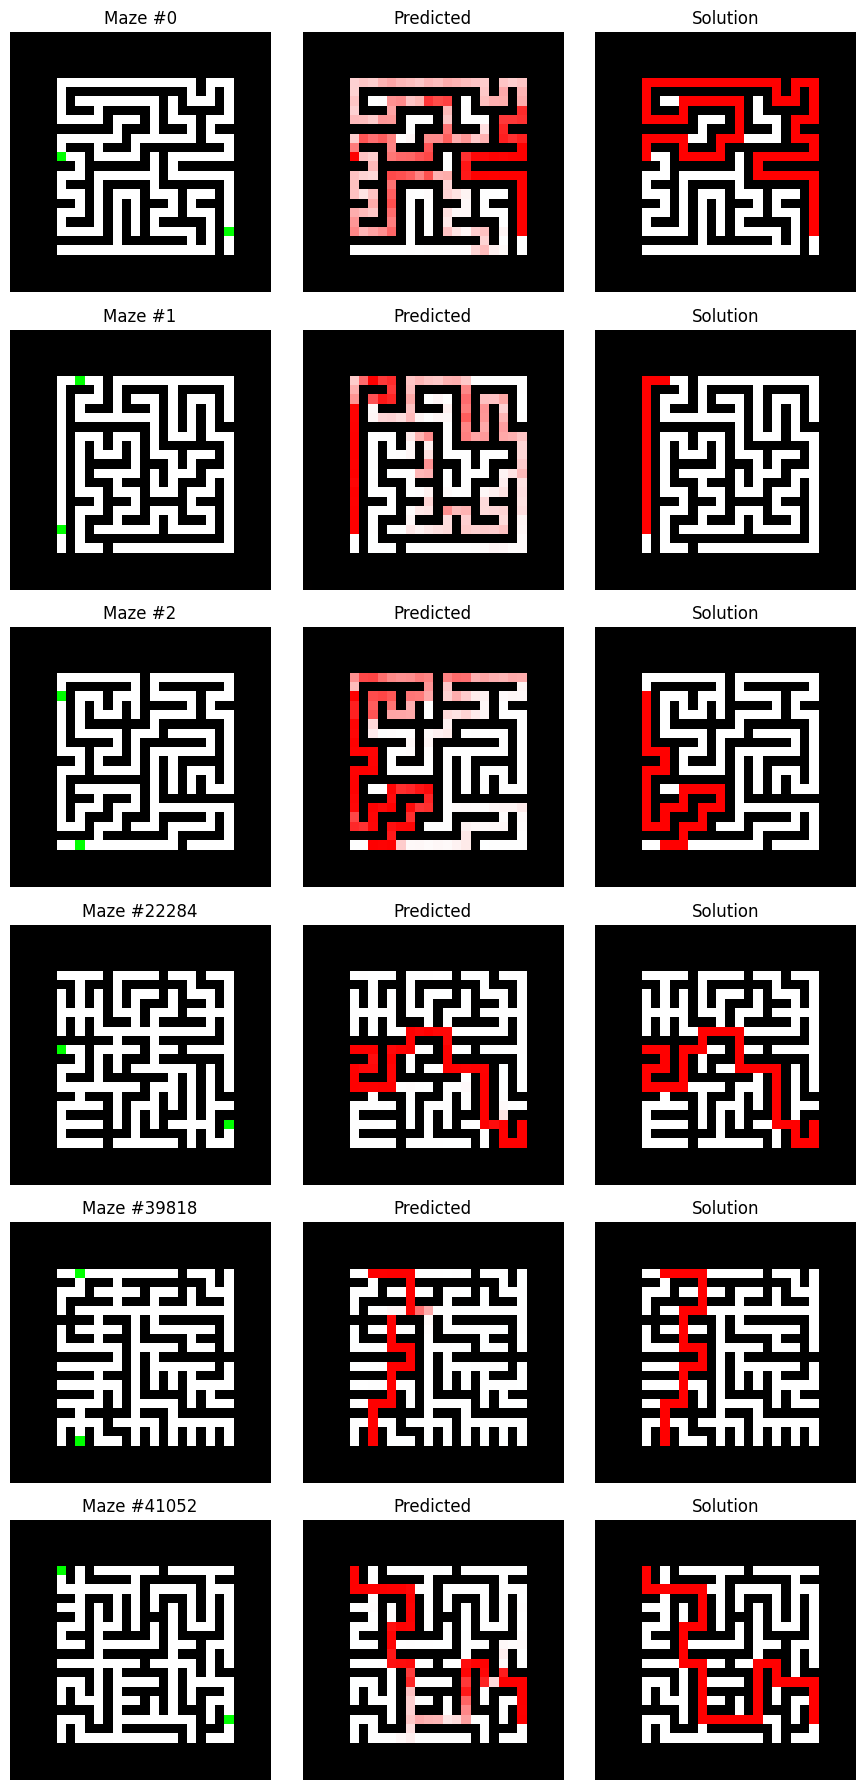

Epoch 22 | D Loss: 541.3766 | G Loss: 1.9630


[Train] Epoch 23/40: 100%|██████████| 782/782 [01:41<00:00,  7.73it/s]


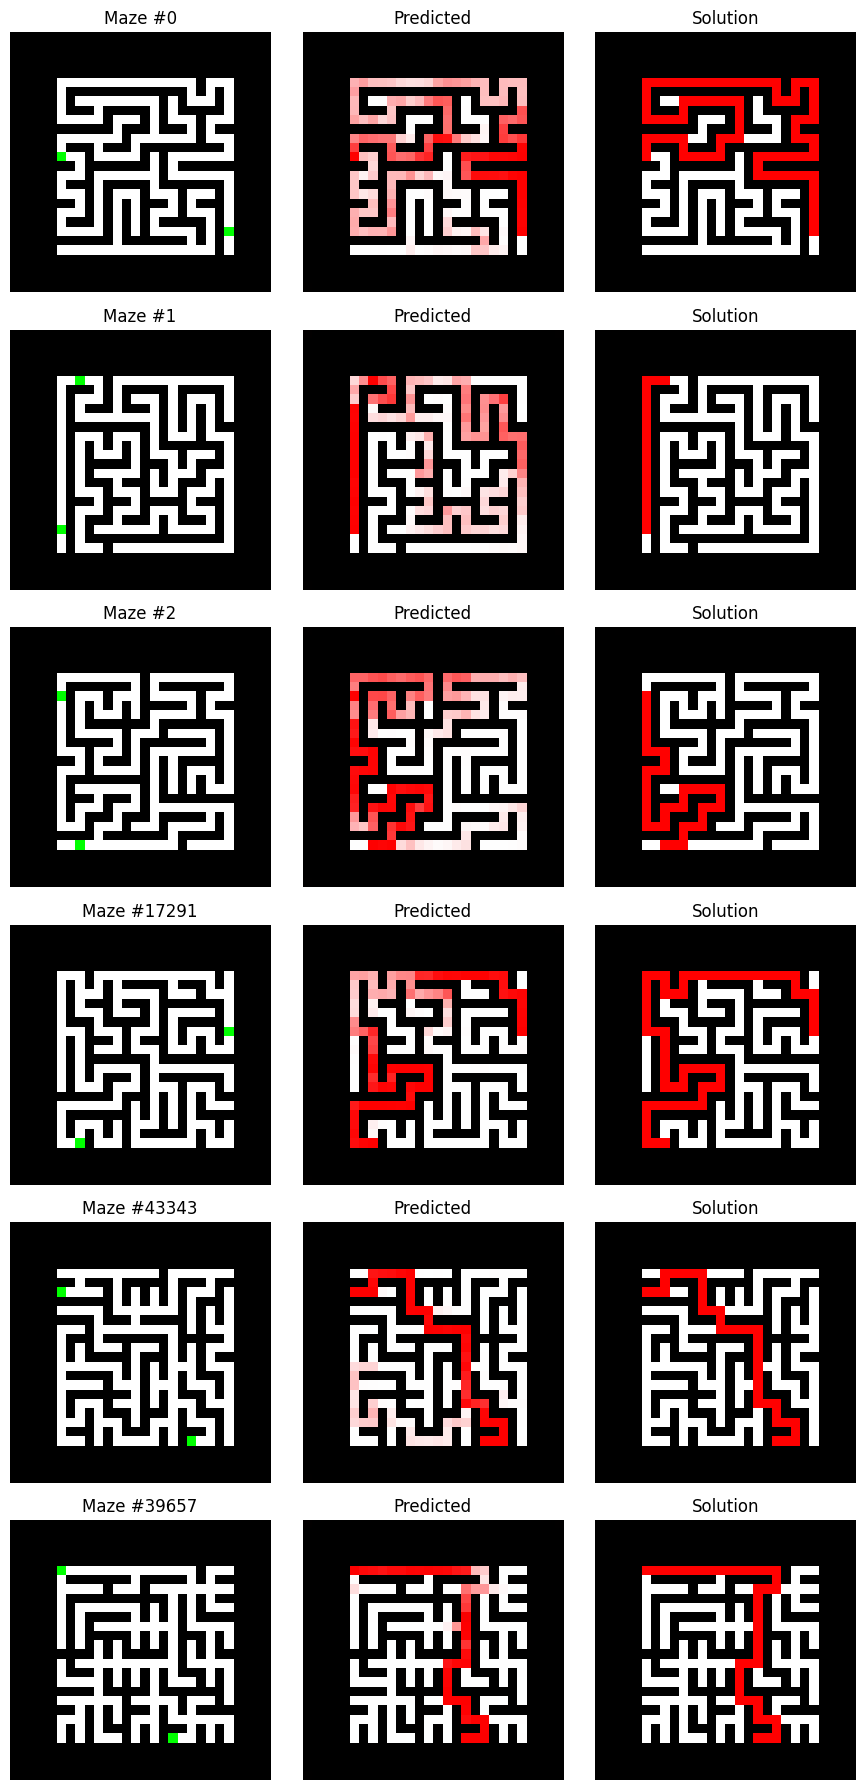

Epoch 23 | D Loss: 541.4005 | G Loss: 2.2057


[Train] Epoch 24/40: 100%|██████████| 782/782 [01:40<00:00,  7.82it/s]


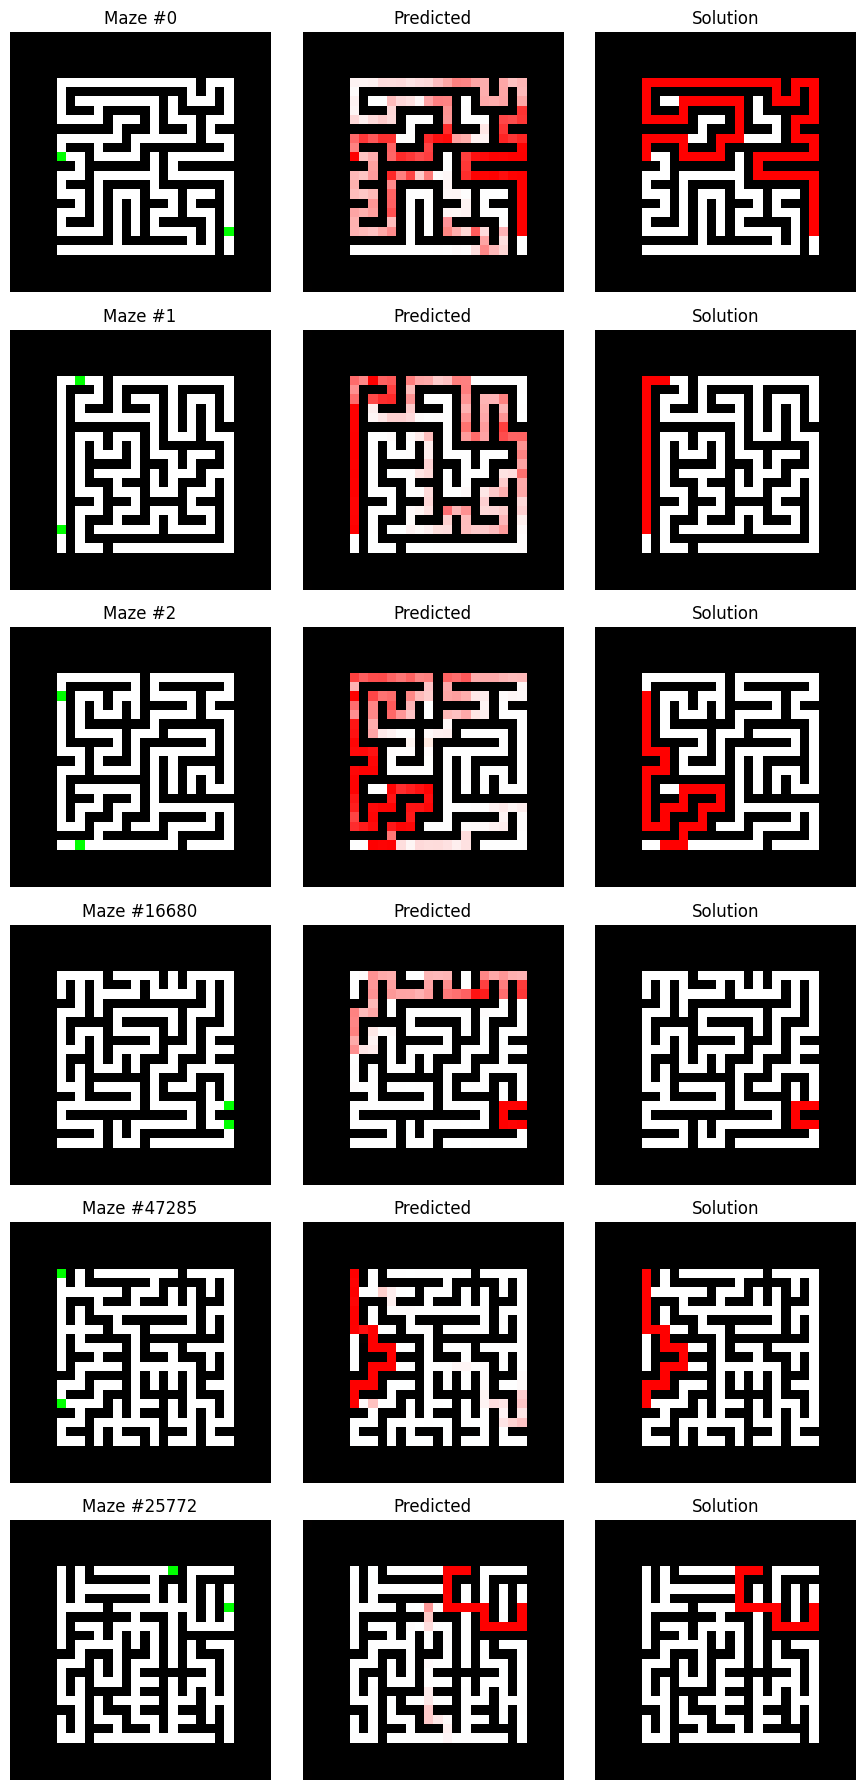

Epoch 24 | D Loss: 541.4124 | G Loss: 4.3597


[Train] Epoch 25/40: 100%|██████████| 782/782 [01:39<00:00,  7.82it/s]


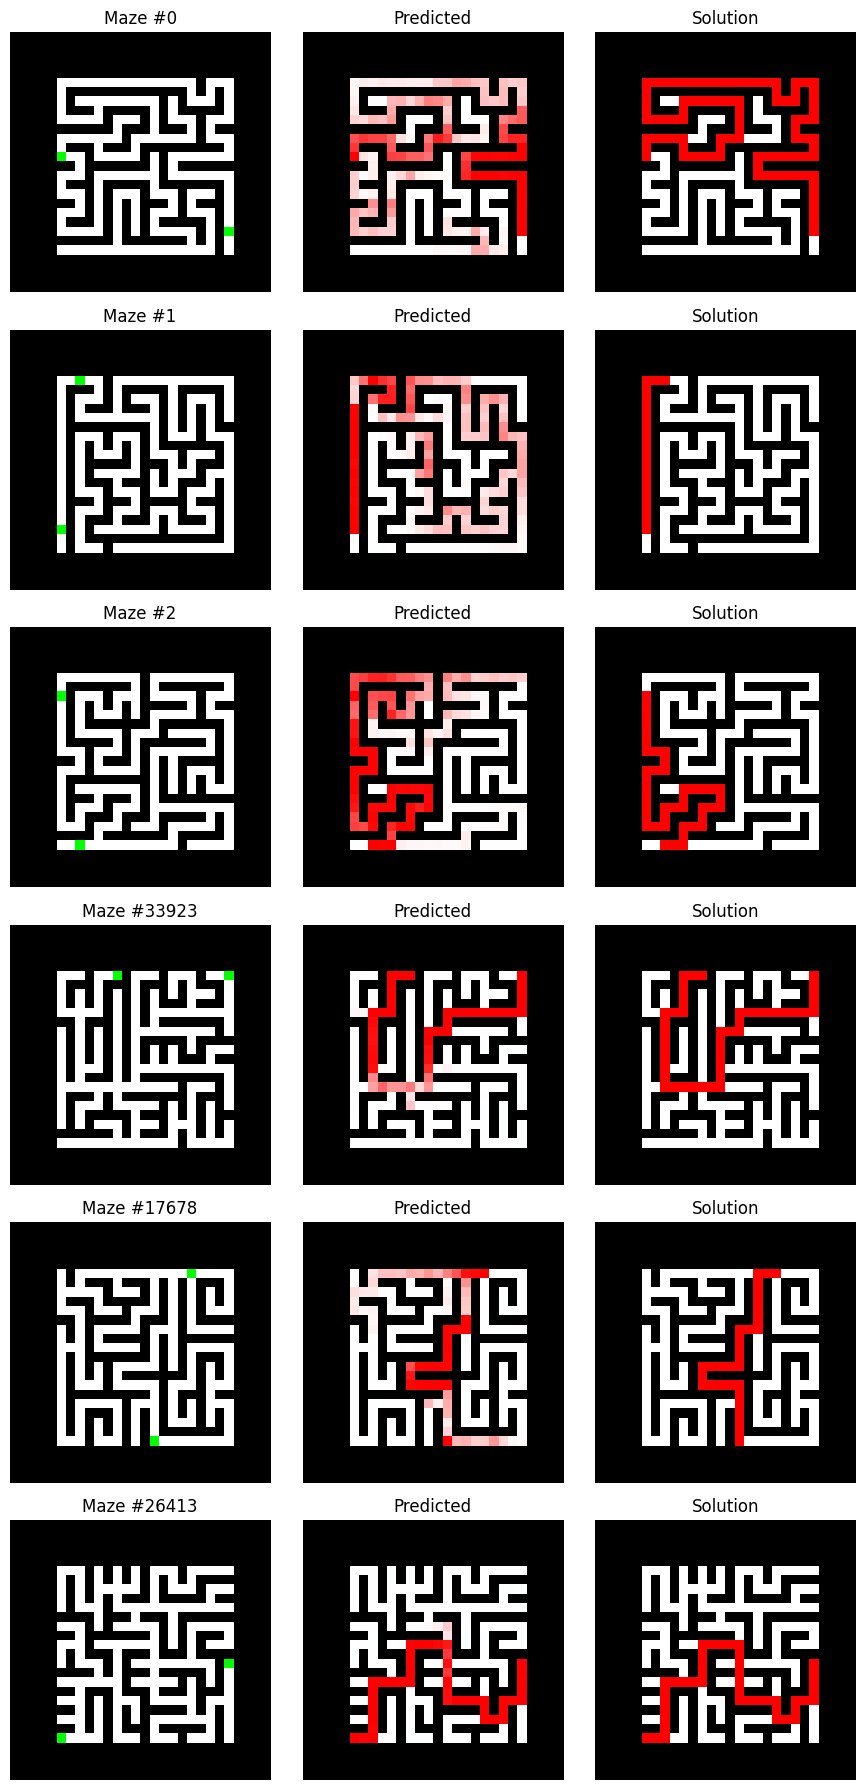

Epoch 25 | D Loss: 541.4229 | G Loss: 2.4385


[Train] Epoch 26/40: 100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


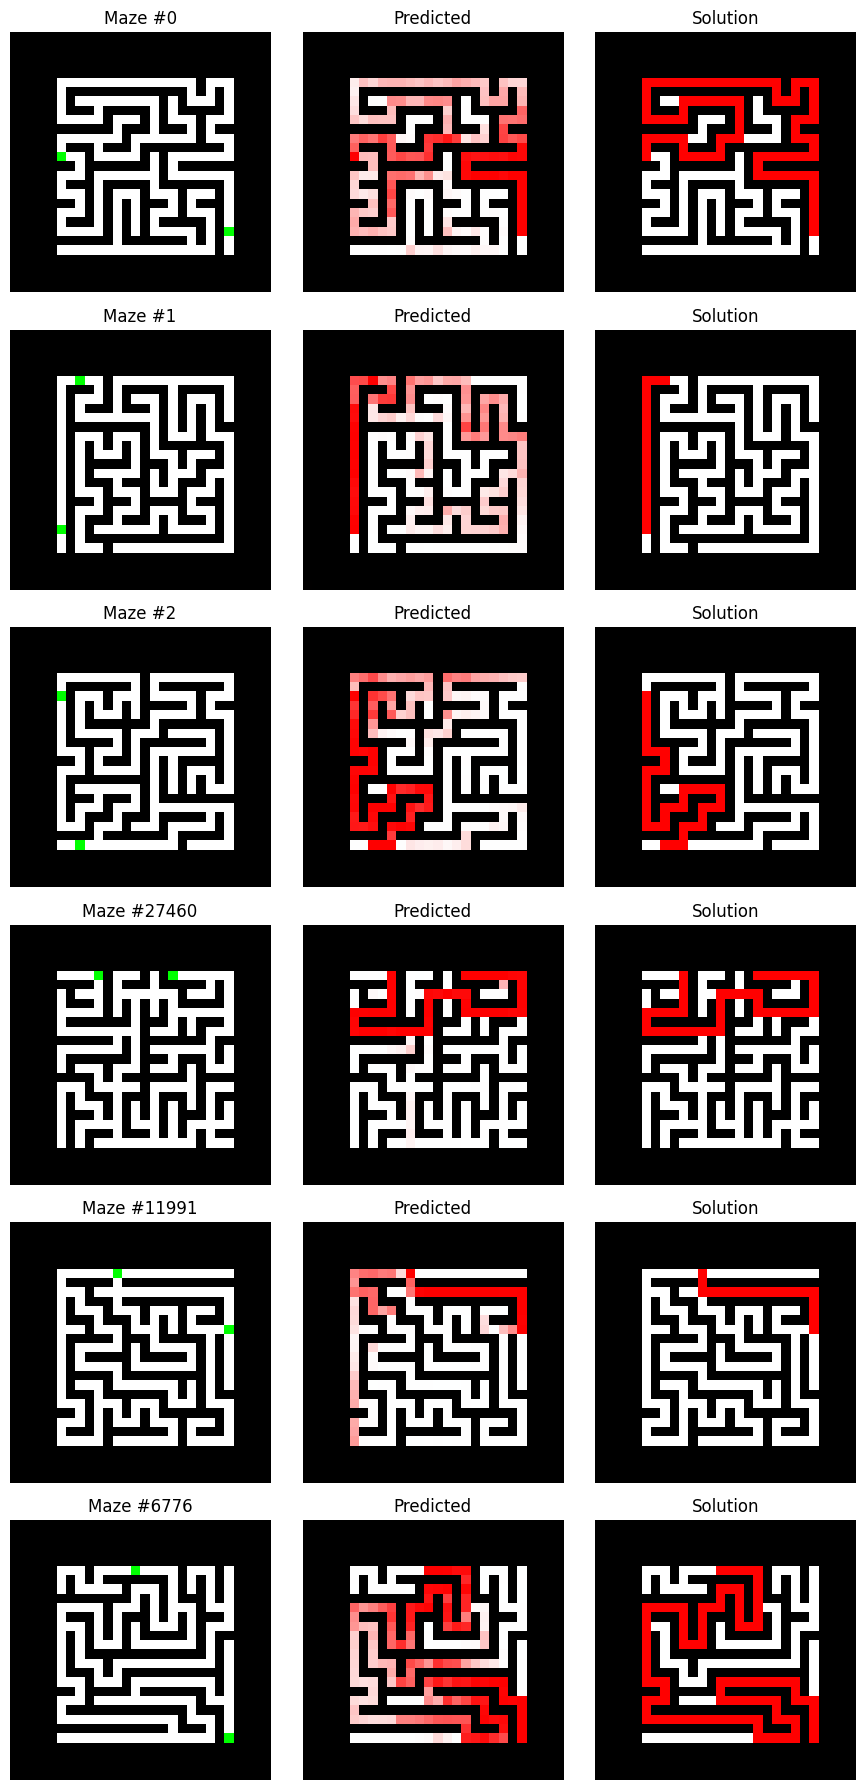

Epoch 26 | D Loss: 541.4442 | G Loss: 3.0138


[Train] Epoch 27/40: 100%|██████████| 782/782 [01:38<00:00,  7.92it/s]


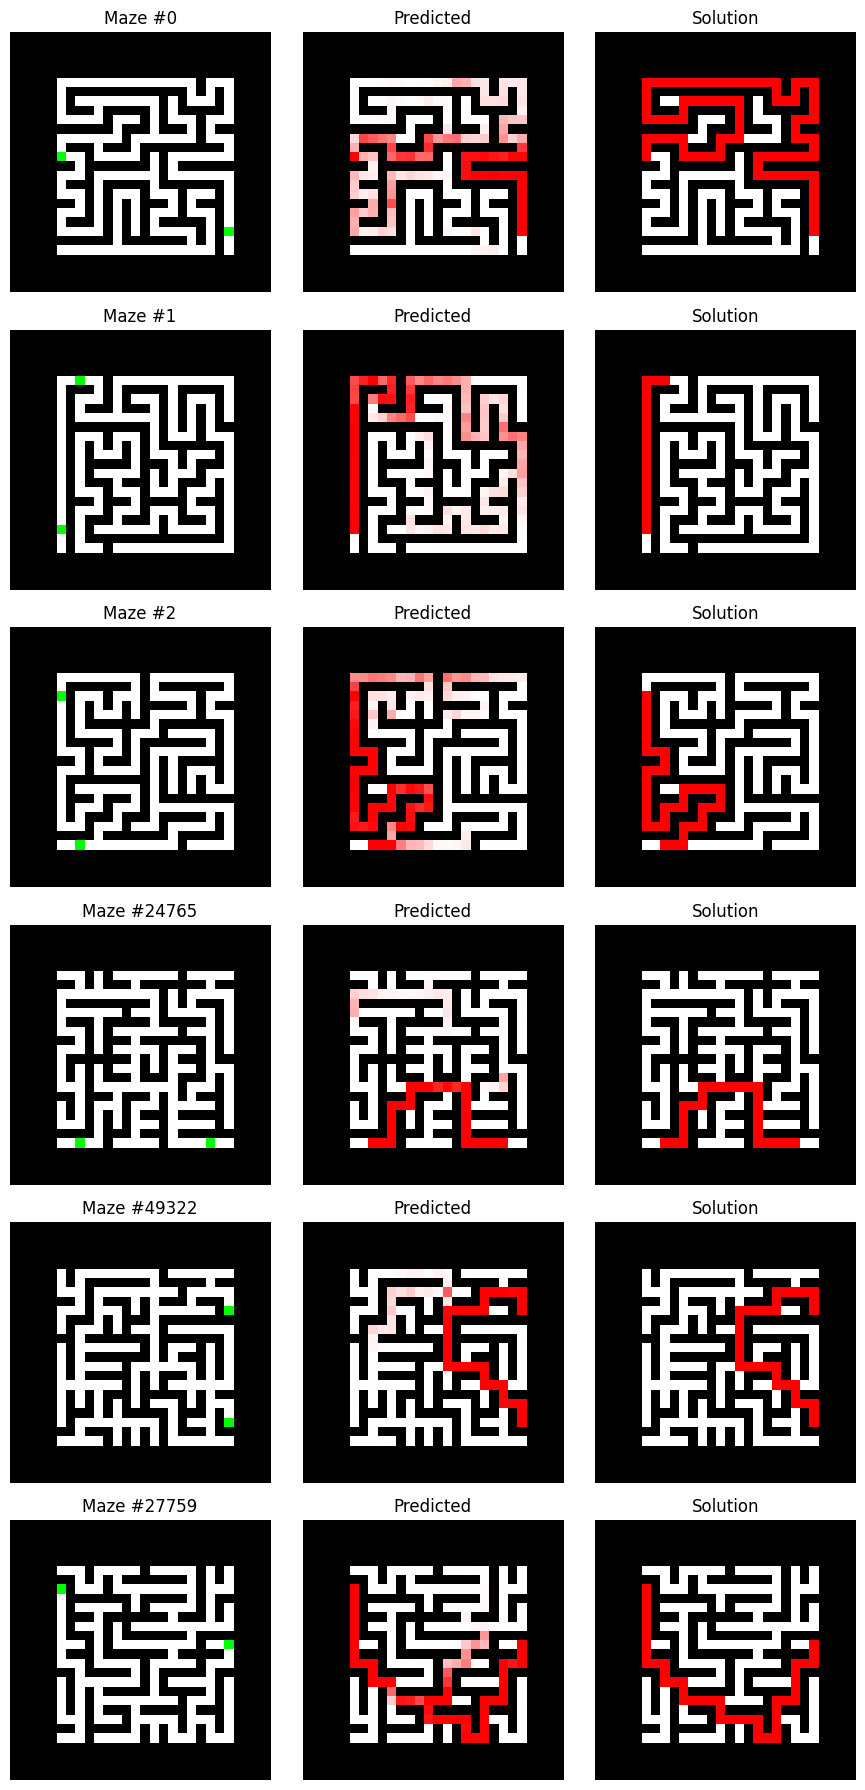

Epoch 27 | D Loss: 541.4513 | G Loss: 2.4419


[Train] Epoch 28/40: 100%|██████████| 782/782 [01:40<00:00,  7.76it/s]


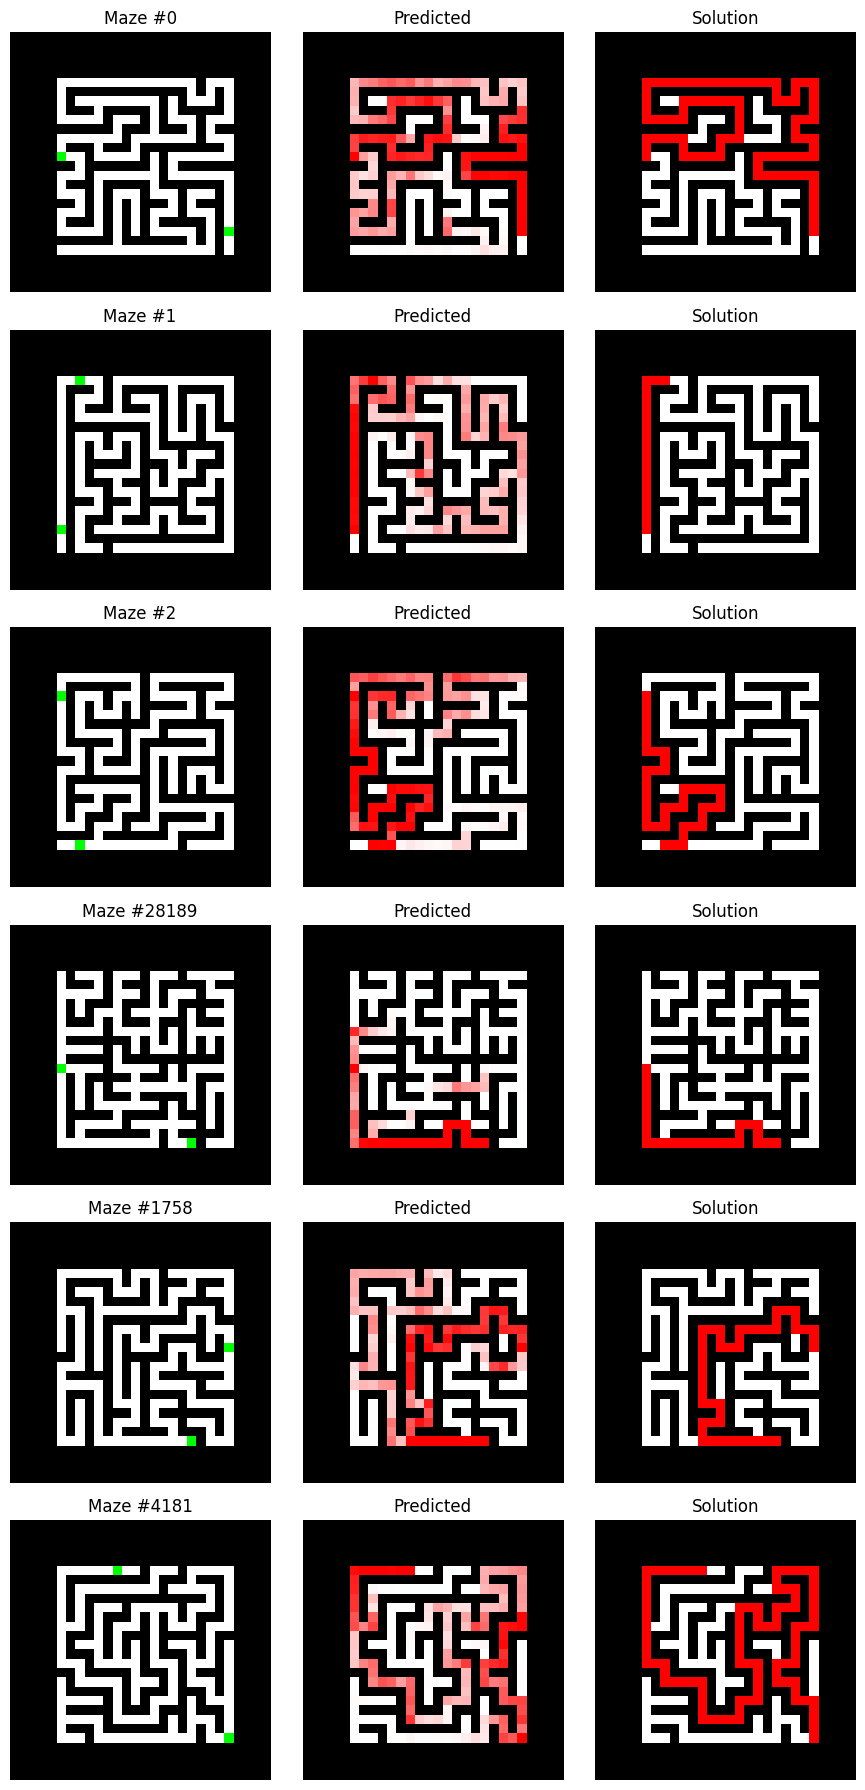

Epoch 28 | D Loss: 541.4657 | G Loss: 2.8550


[Train] Epoch 29/40: 100%|██████████| 782/782 [01:45<00:00,  7.42it/s]


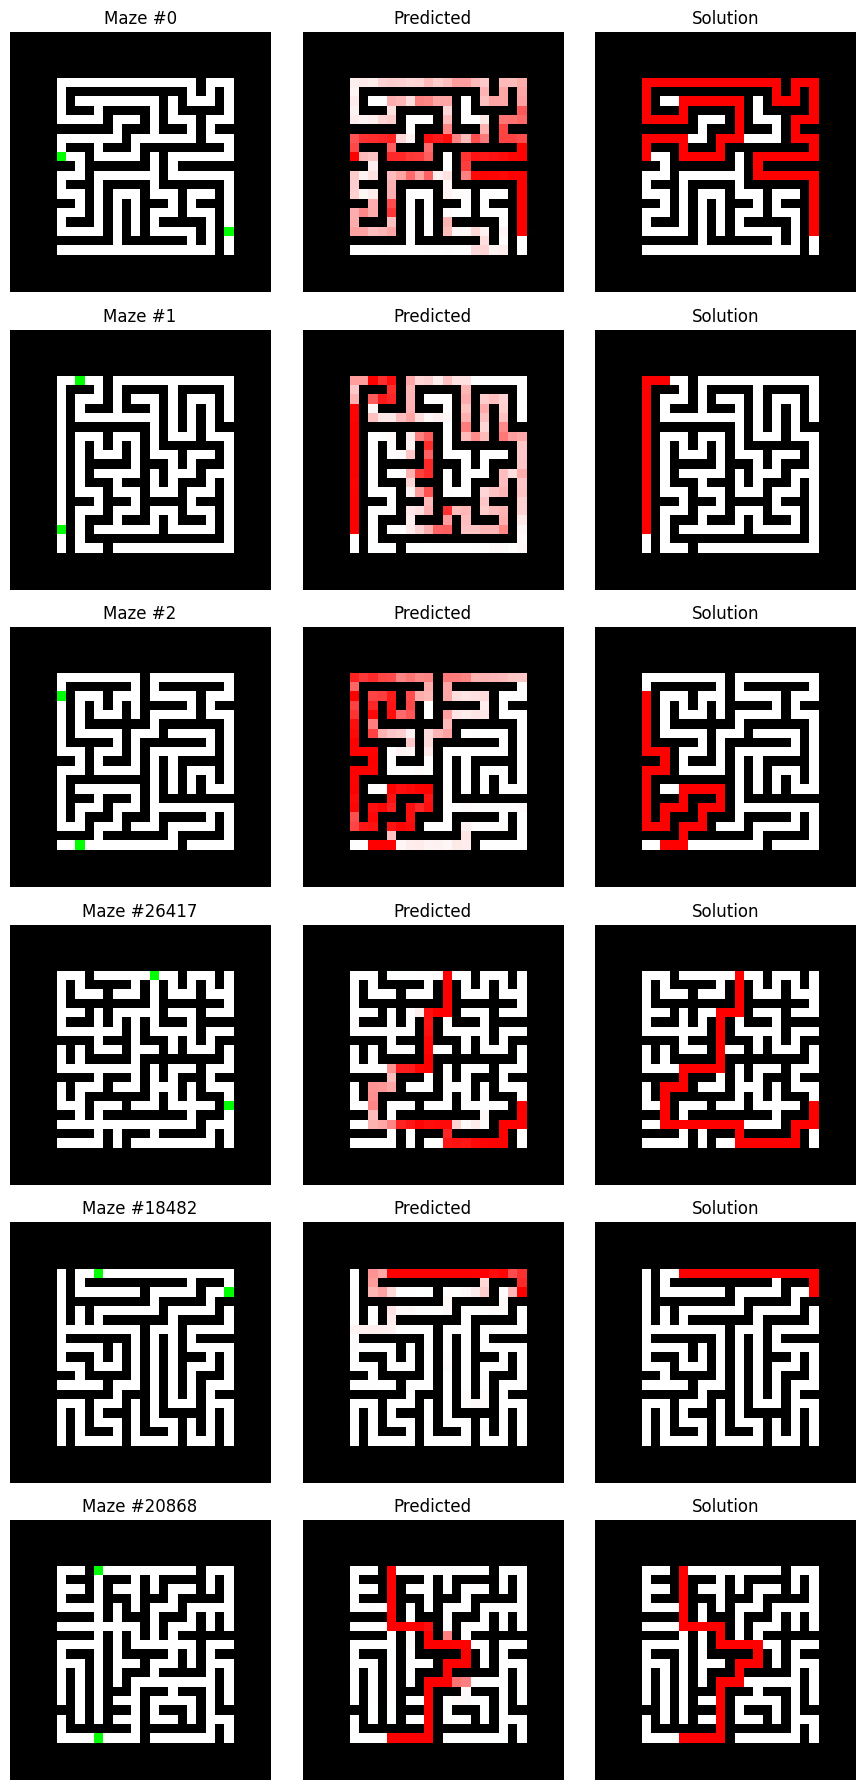

Epoch 29 | D Loss: 541.4770 | G Loss: 2.5595


[Train] Epoch 30/40: 100%|██████████| 782/782 [01:45<00:00,  7.40it/s]


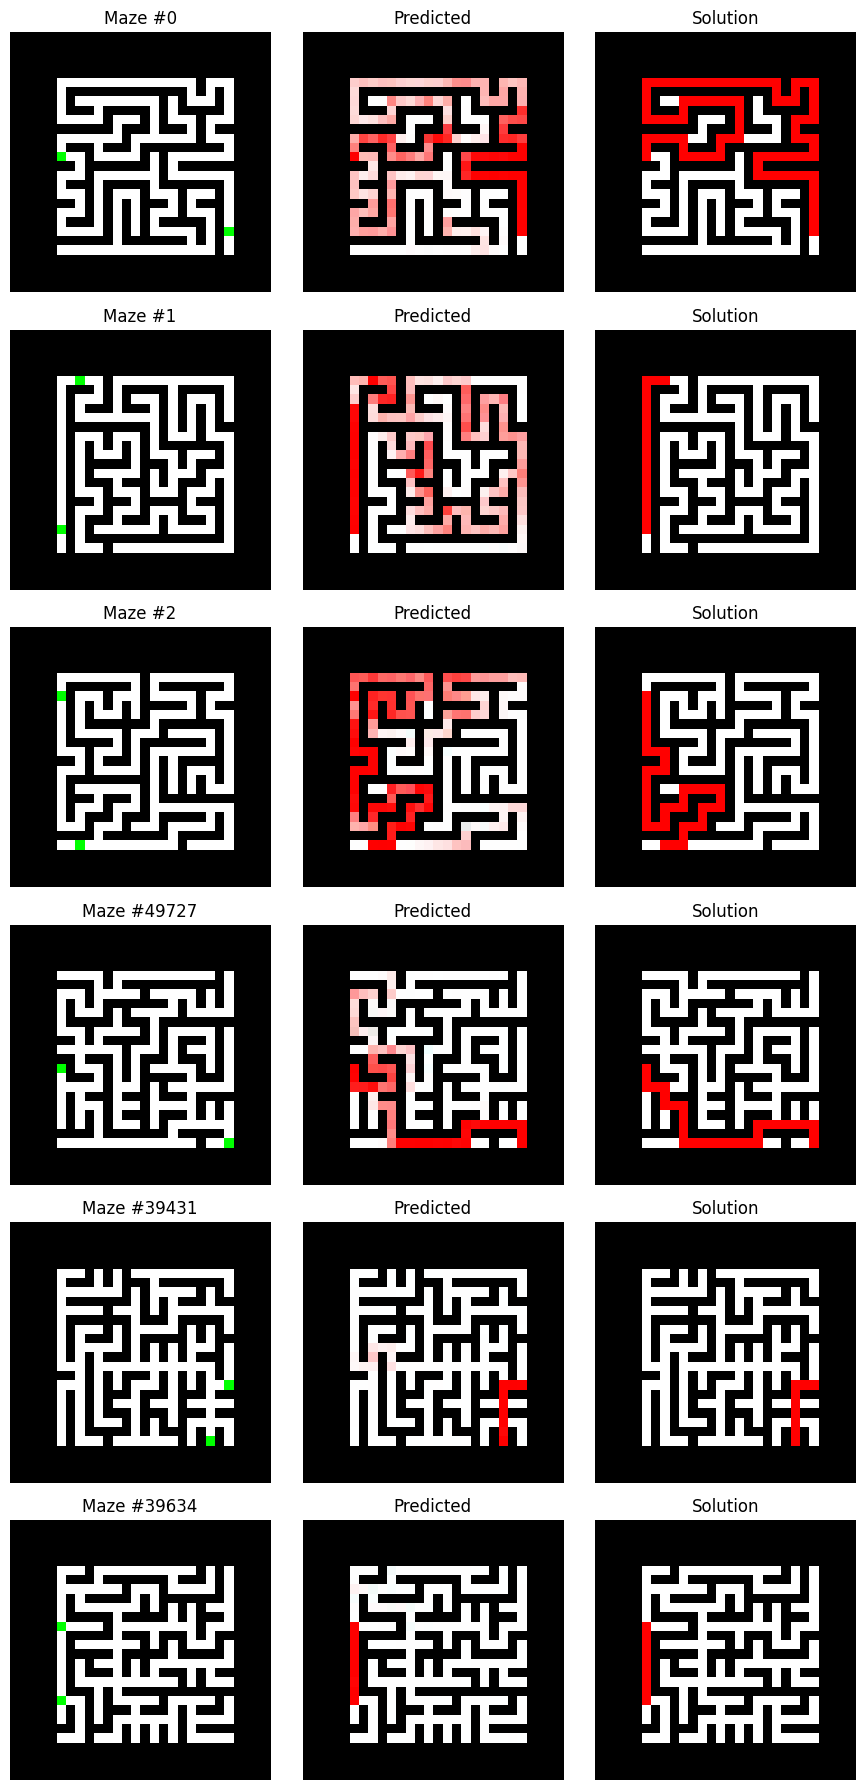

Epoch 30 | D Loss: 541.4890 | G Loss: 2.5671


[Train] Epoch 31/40: 100%|██████████| 782/782 [01:41<00:00,  7.70it/s]


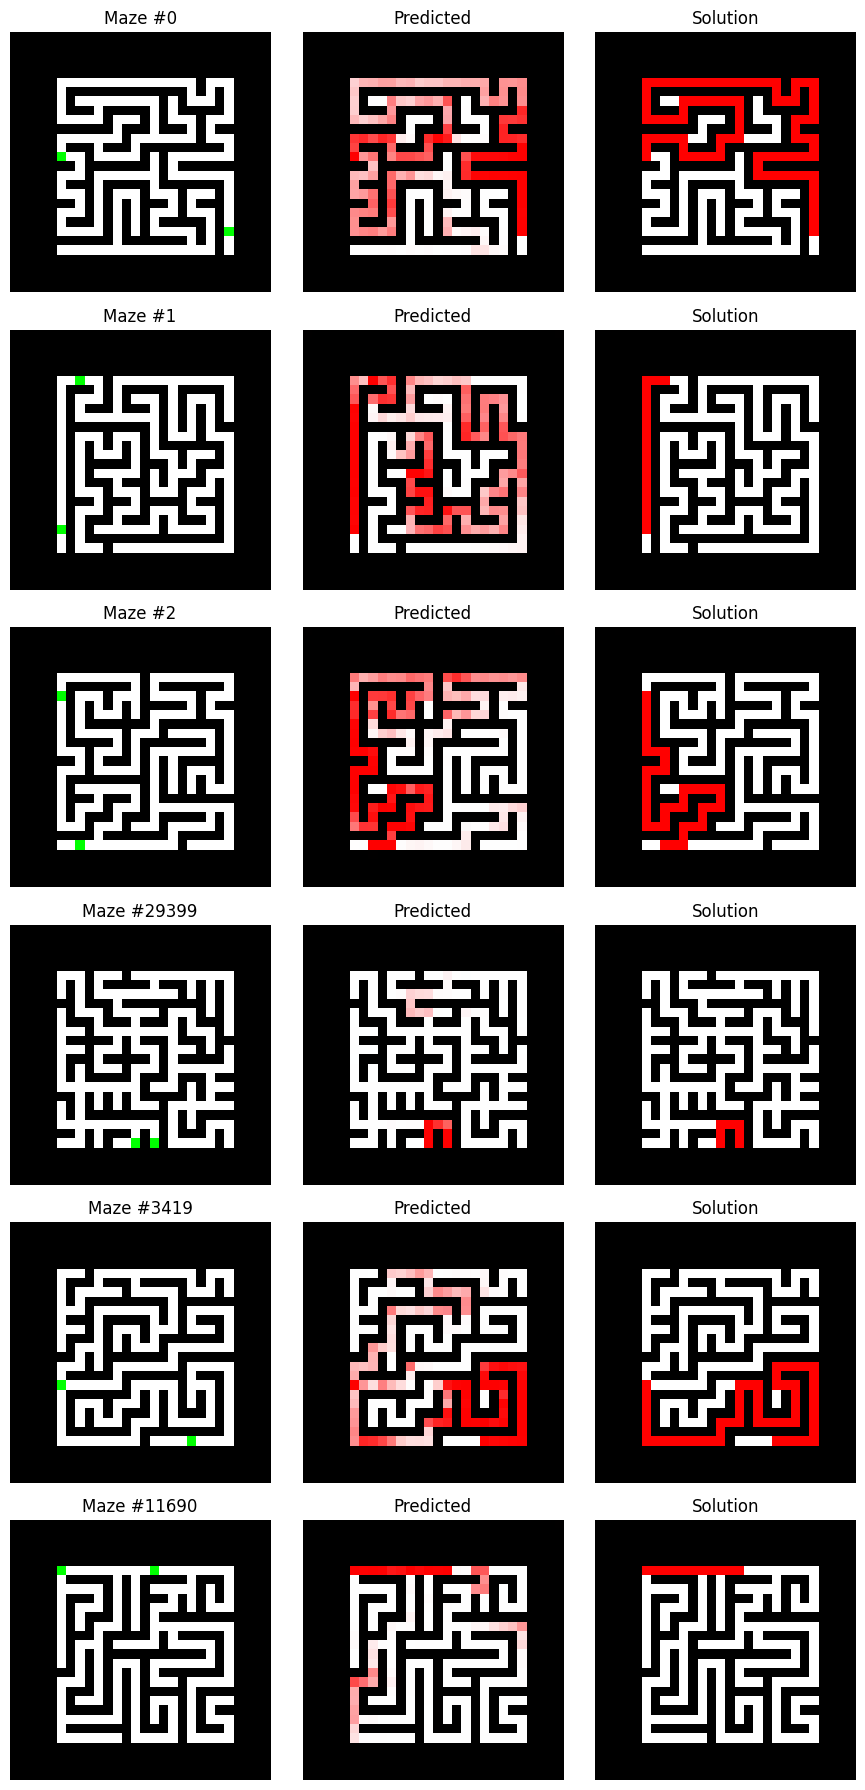

Epoch 31 | D Loss: 541.5025 | G Loss: 2.5509


[Train] Epoch 32/40: 100%|██████████| 782/782 [01:45<00:00,  7.38it/s]


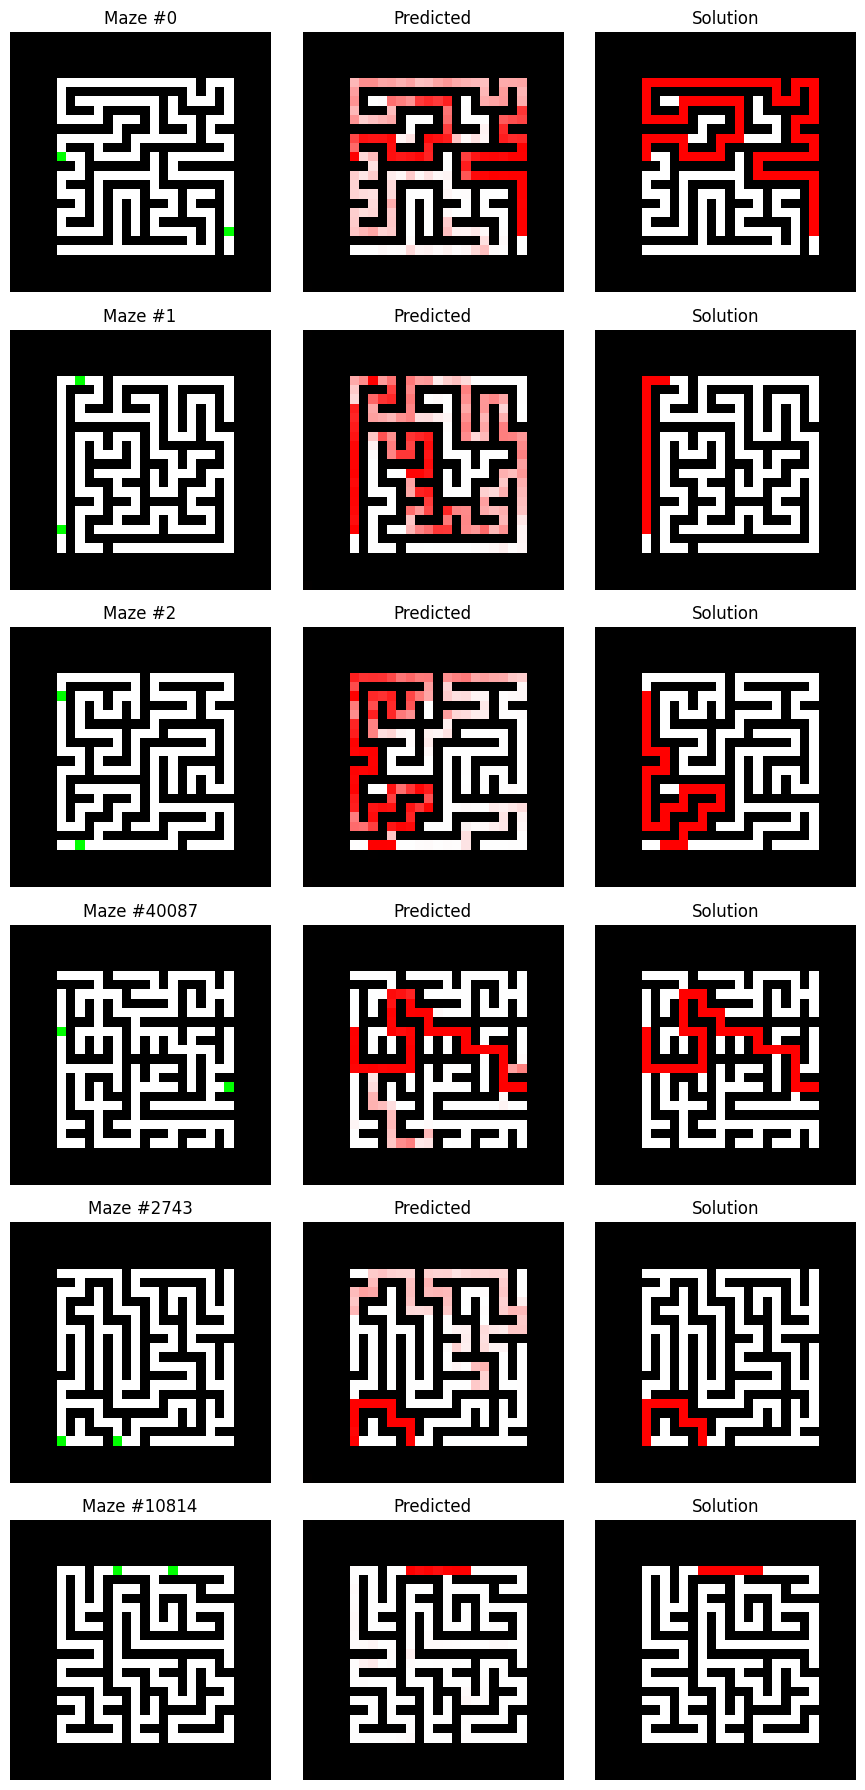

Epoch 32 | D Loss: 541.5099 | G Loss: 2.9263


[Train] Epoch 33/40: 100%|██████████| 782/782 [01:44<00:00,  7.51it/s]


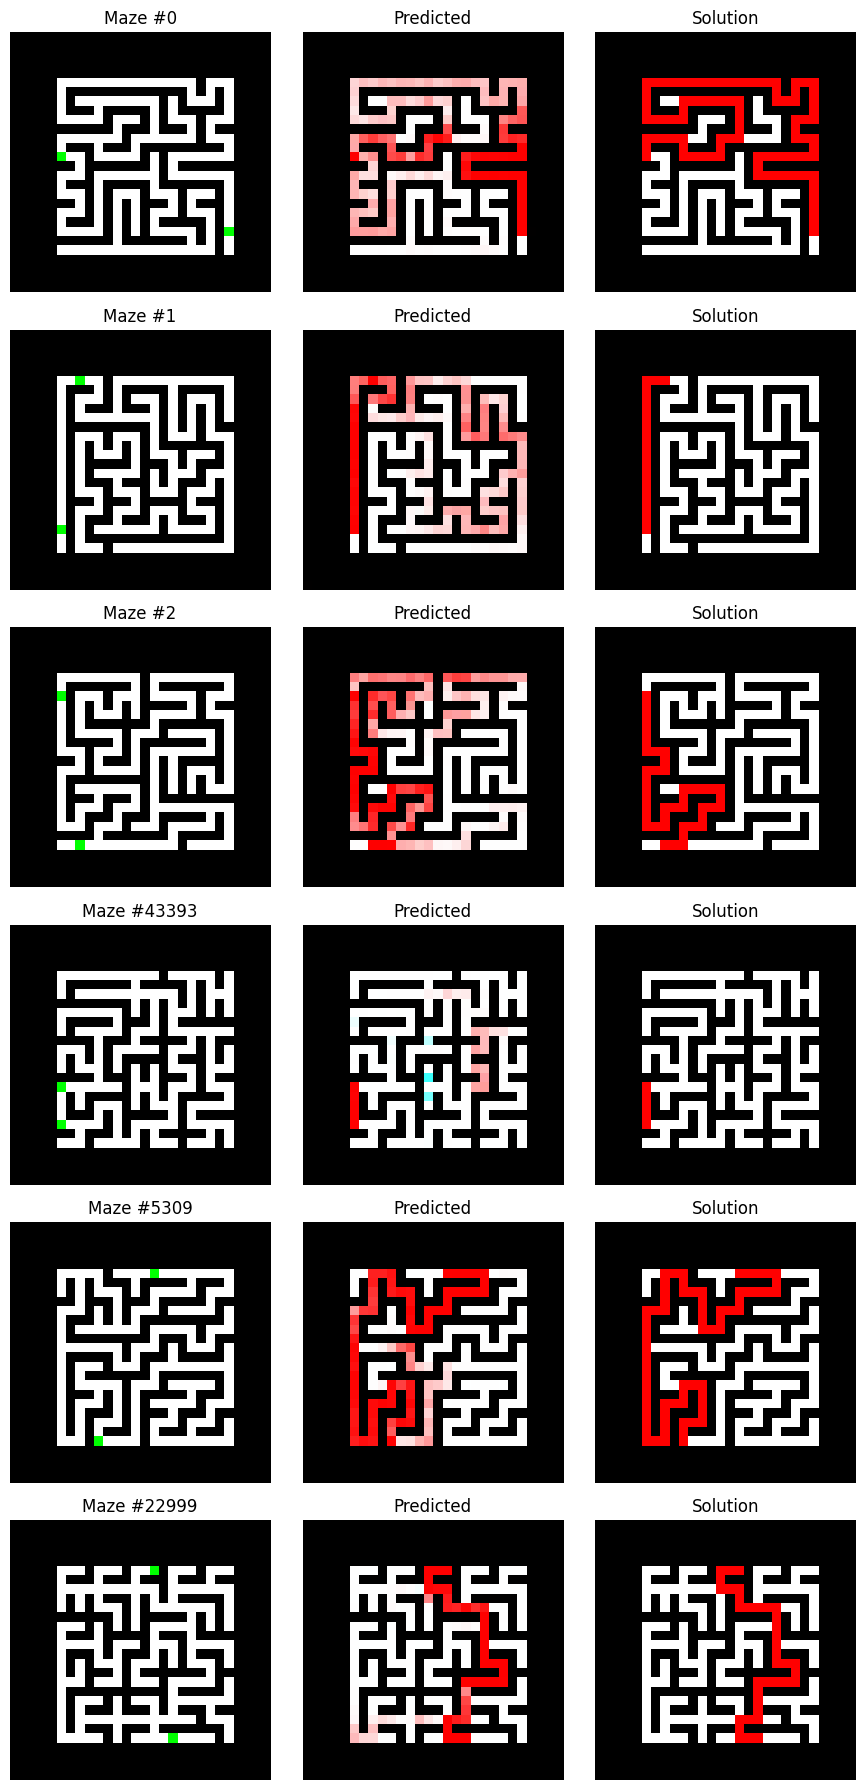

Epoch 33 | D Loss: 541.5175 | G Loss: 1.7535


[Train] Epoch 34/40: 100%|██████████| 782/782 [01:45<00:00,  7.44it/s]


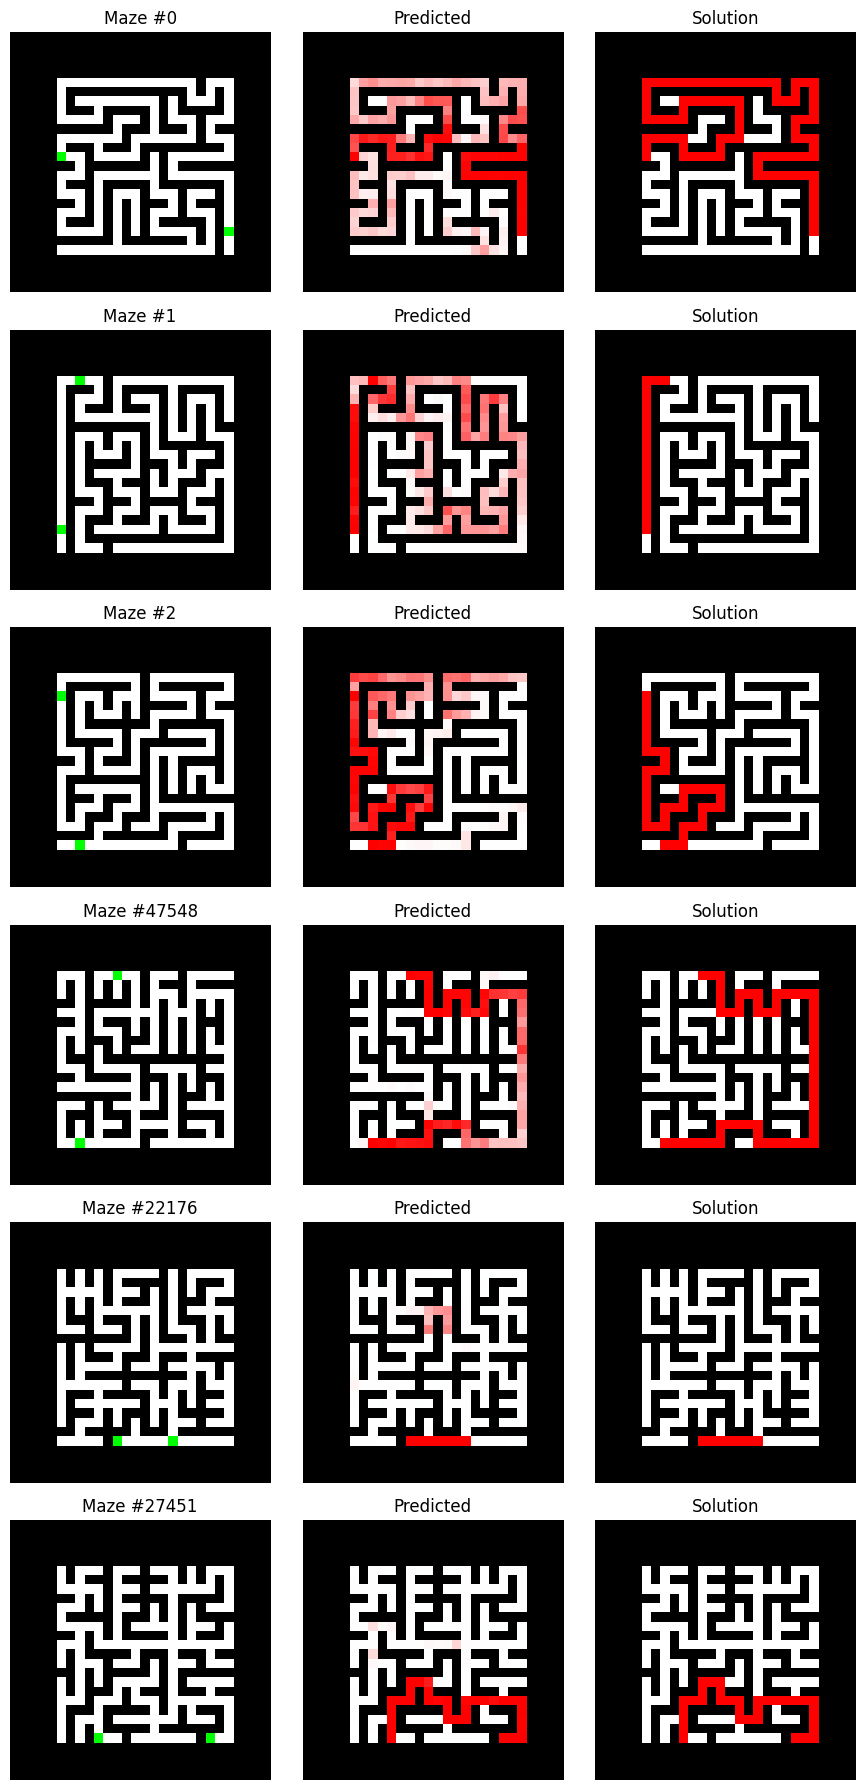

Epoch 34 | D Loss: 541.5317 | G Loss: 2.2590


[Train] Epoch 35/40: 100%|██████████| 782/782 [01:41<00:00,  7.69it/s]


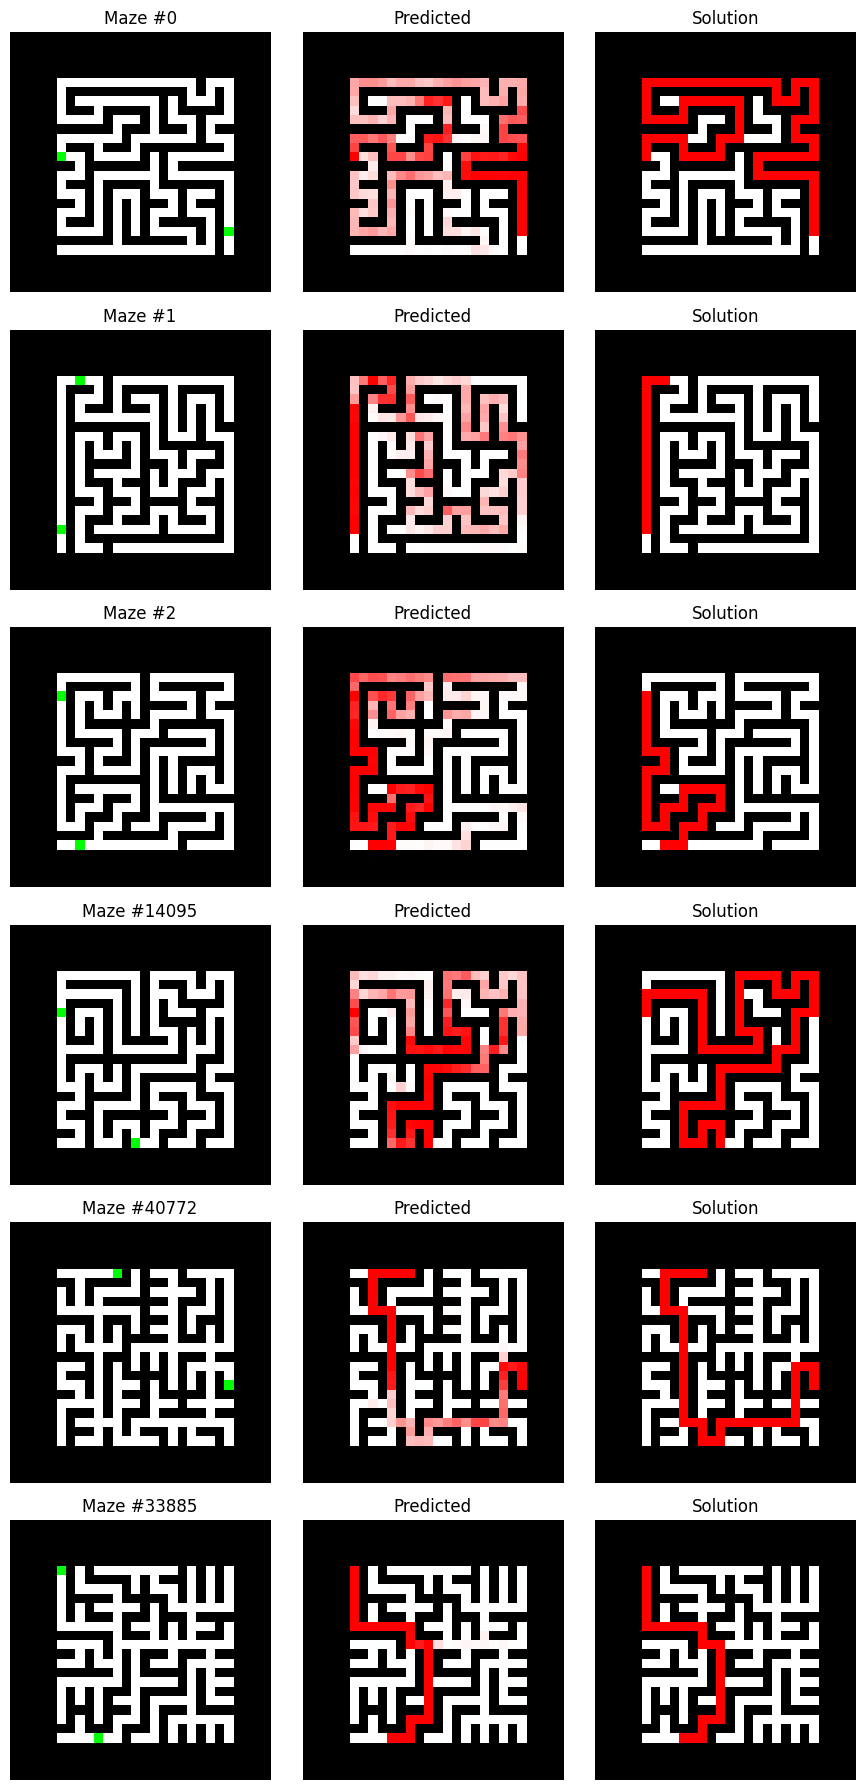

Epoch 35 | D Loss: 541.5370 | G Loss: 2.4629


[Train] Epoch 36/40: 100%|██████████| 782/782 [01:39<00:00,  7.82it/s]


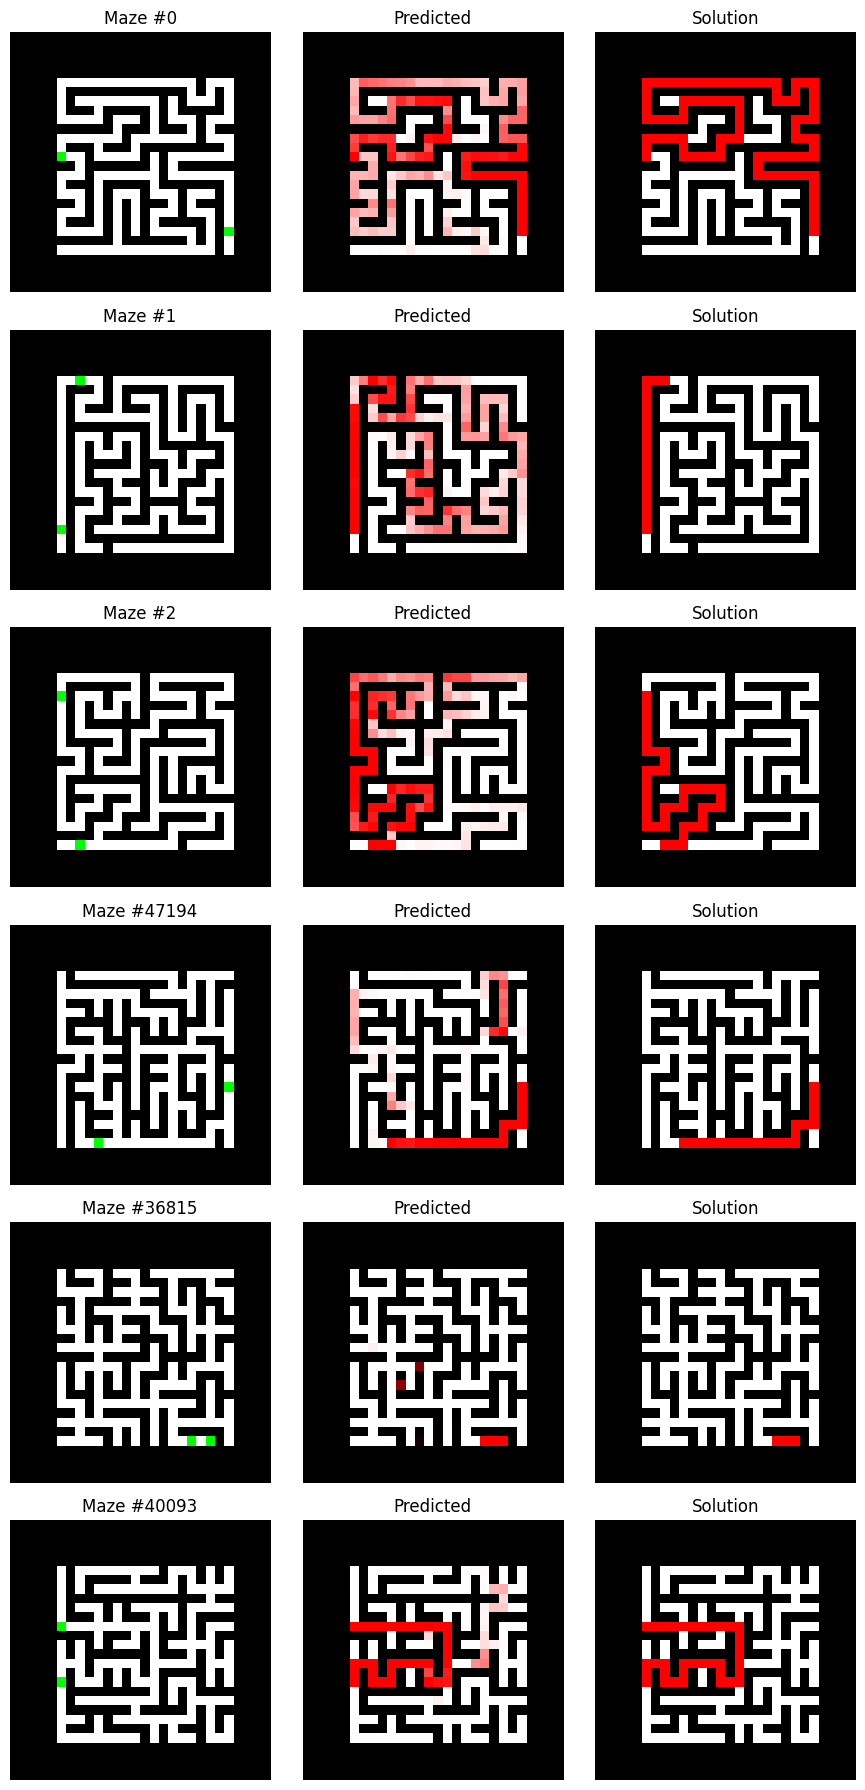

Epoch 36 | D Loss: 541.5460 | G Loss: 2.6021


[Train] Epoch 37/40: 100%|██████████| 782/782 [01:40<00:00,  7.81it/s]


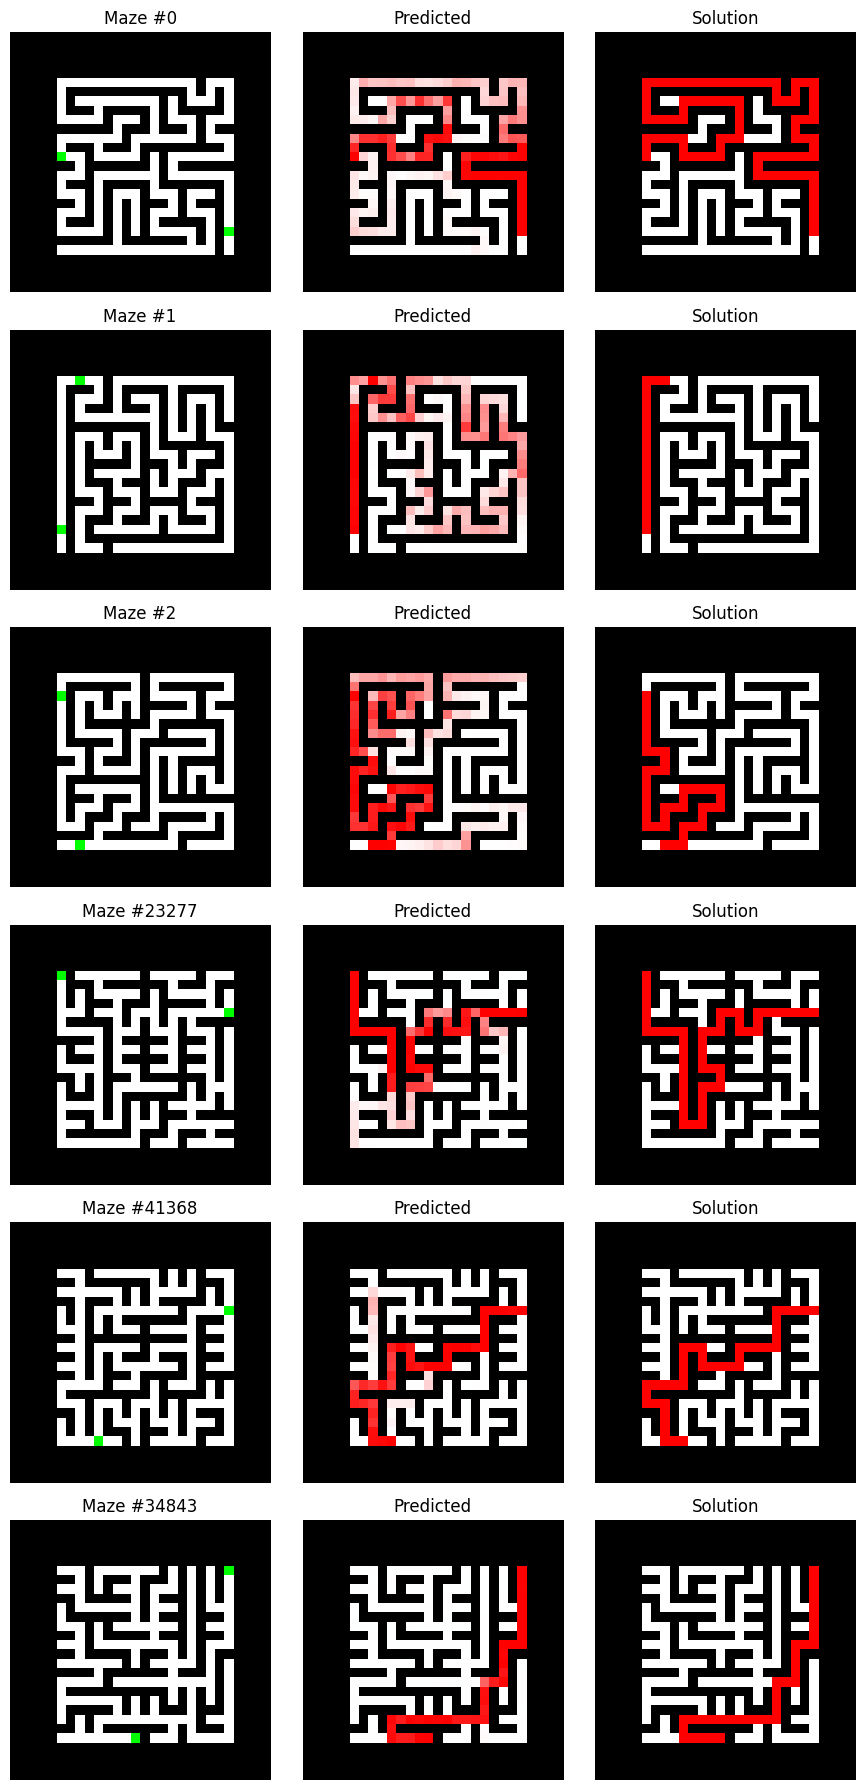

Epoch 37 | D Loss: 541.5558 | G Loss: 1.8277


[Train] Epoch 38/40: 100%|██████████| 782/782 [01:49<00:00,  7.12it/s]


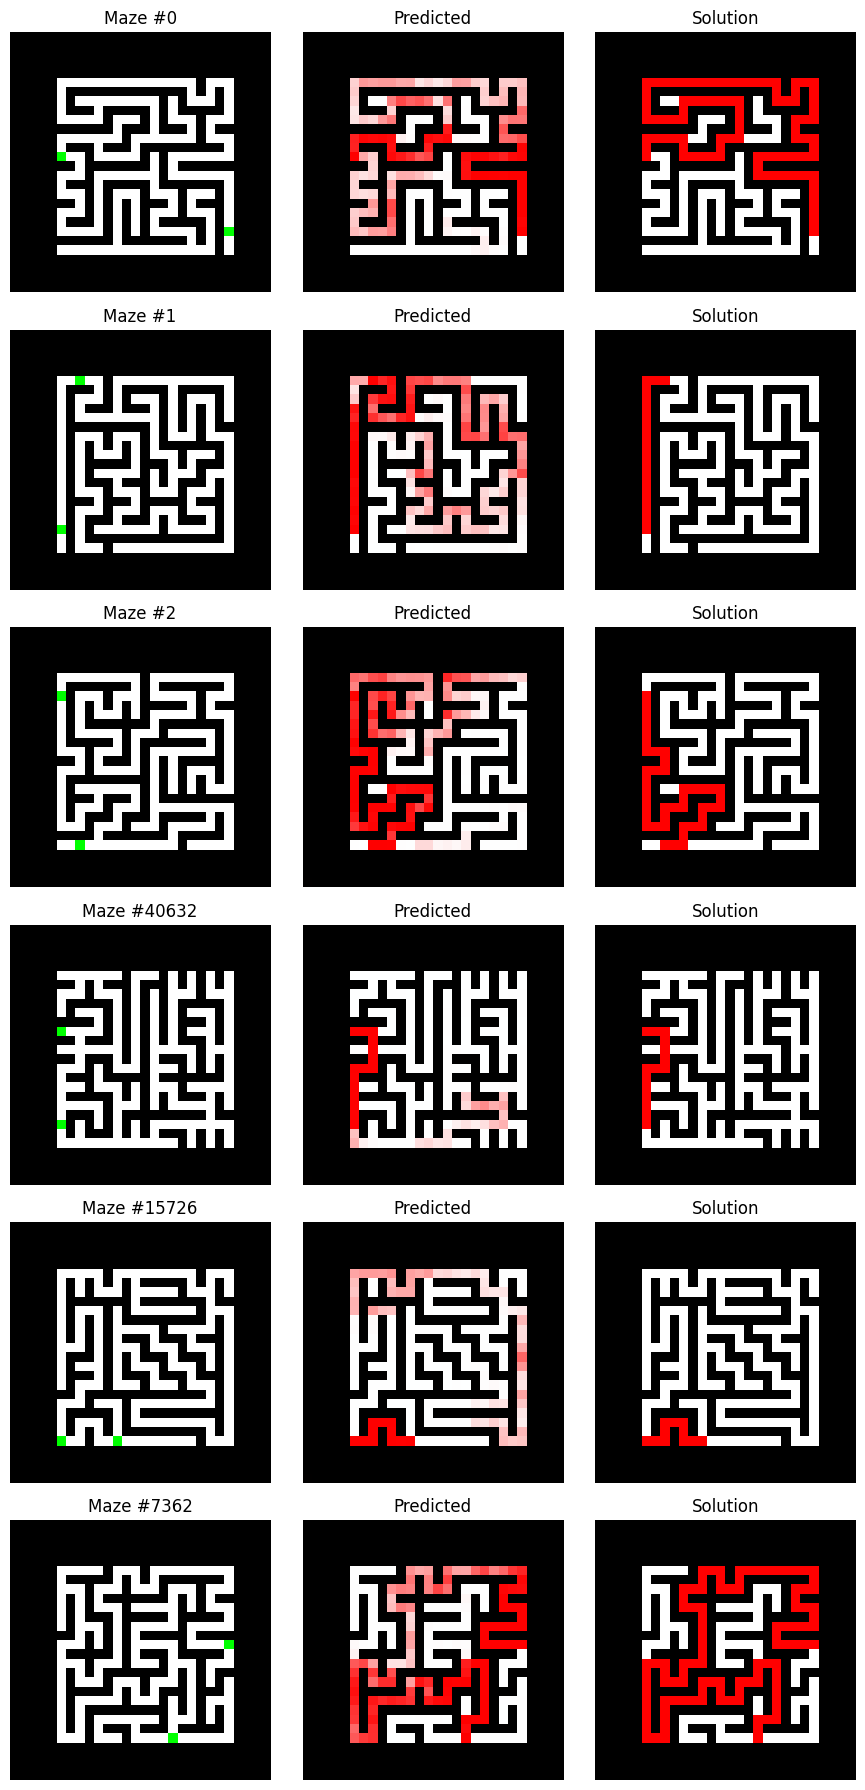

Epoch 38 | D Loss: 541.5593 | G Loss: 1.9626


[Train] Epoch 39/40: 100%|██████████| 782/782 [01:45<00:00,  7.42it/s]


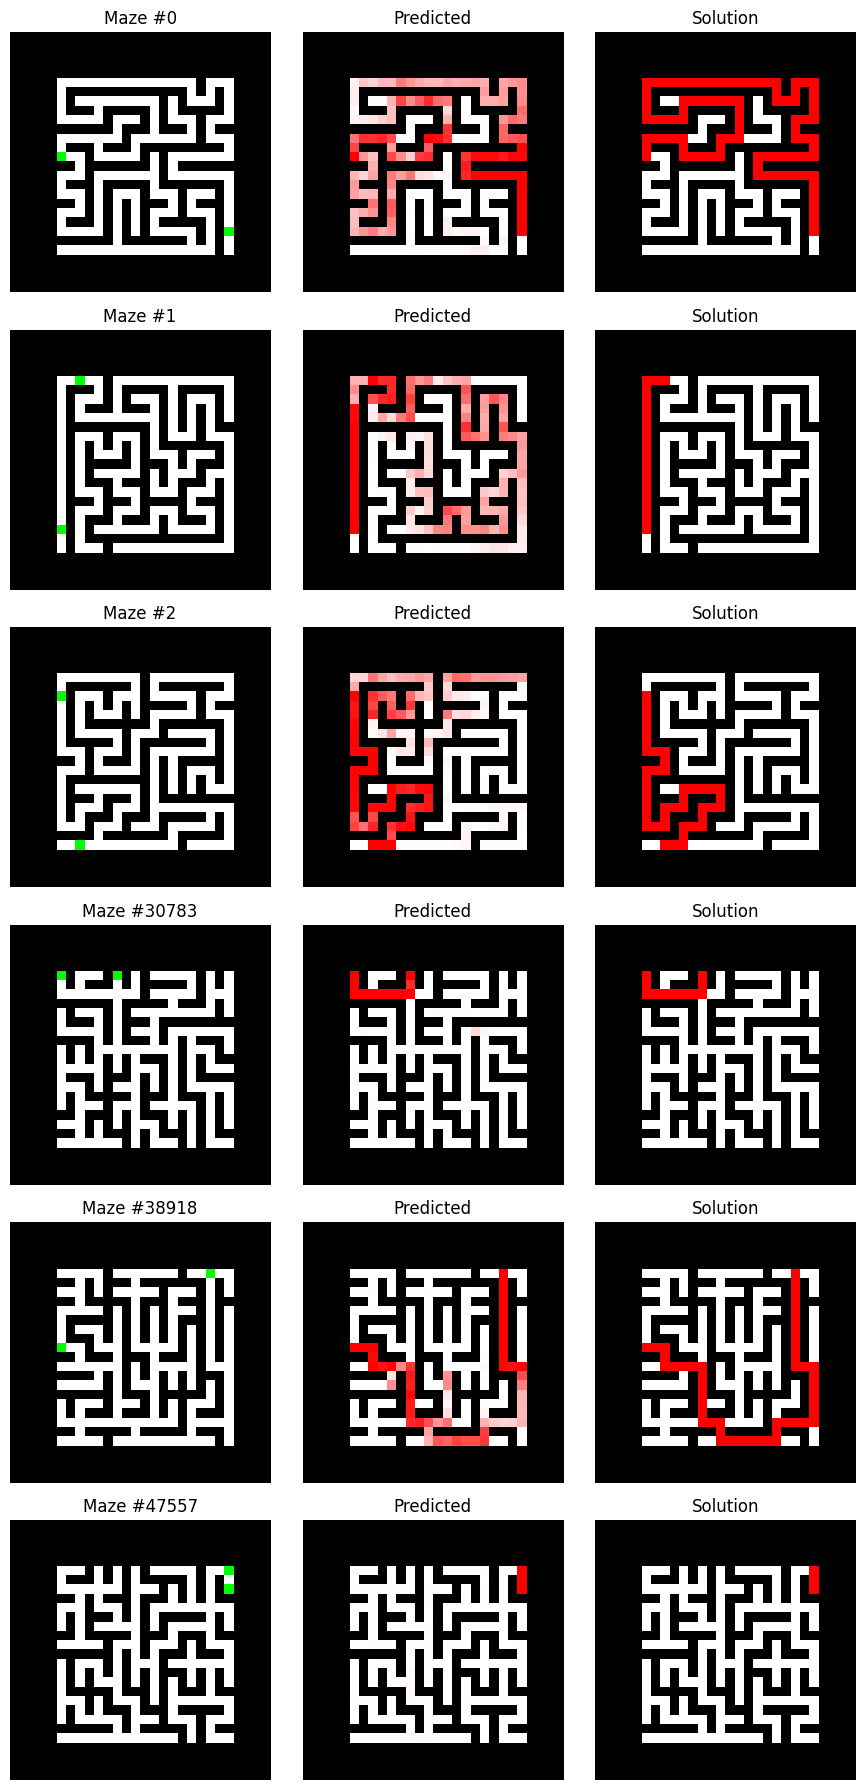

Epoch 39 | D Loss: 541.5737 | G Loss: 2.8520


[Train] Epoch 40/40: 100%|██████████| 782/782 [01:39<00:00,  7.83it/s]


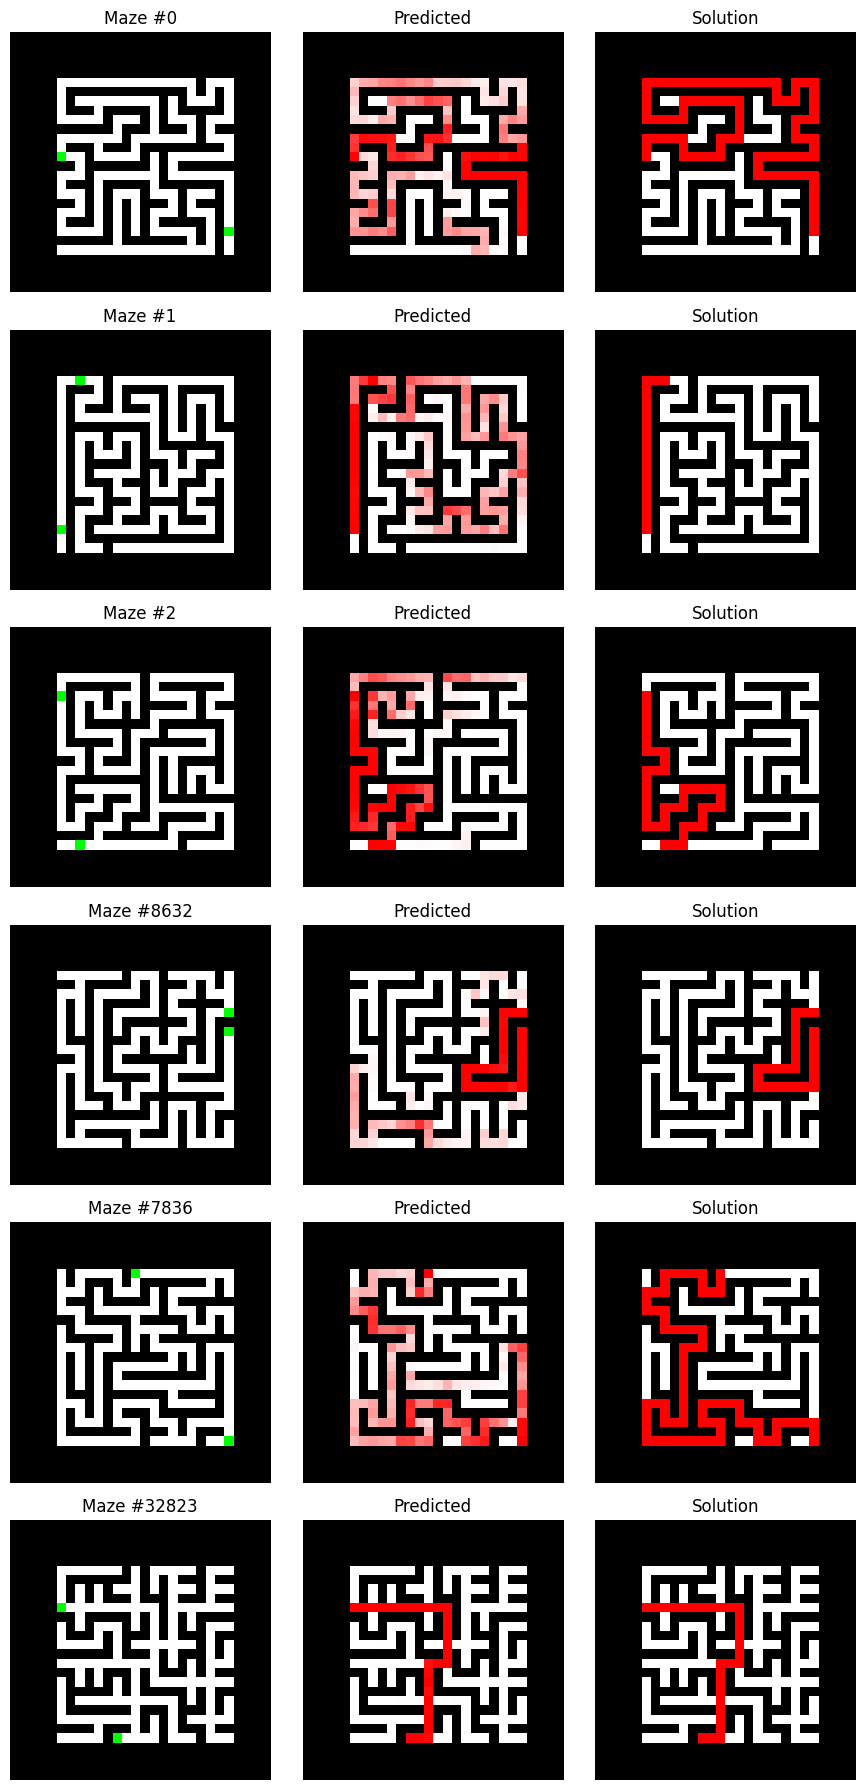

Epoch 40 | D Loss: 541.5752 | G Loss: 2.4515


In [28]:
EPOCHS = 40
device = 'cuda' if torch.cuda.is_available() else 'cpu'

g = Generator().to(device)  # Output is RGB image (3 channels)
d = PatchGan().to(device)

g_loss_fn = nn.MSELoss()
d_loss_fn = nn.BCEWithLogitsLoss()

g_opt = torch.optim.Adam(g.parameters(), lr=0.001, weight_decay=1e-4)
d_opt = torch.optim.Adam(d.parameters(), lr = 0.001, weight_decay = 1e-4)

for epoch in range(EPOCHS):
    g.train()
    d.train()
    
    per_epoch_g_loss = 0.0
    per_epoch_d_loss = 0.0

    for X, y in tqdm(loader, desc=f"[Train] Epoch {epoch+1}/{EPOCHS}"):
        X = X.to(device).float()  # (B, 3, 28, 28) # Images
        y = y.to(device).float()  # (B, 3, 28, 28) # Labels

        # Train discriminator
        y_fake = g(X).detach() # This is essentially like we are running inference and we don't wanna track gradient so detach simple methode to remove that tensor from computation gph

        real_input = torch.cat([X,y],dim = 1) # Channel dimension is indexed 1
        fake_input = torch.cat([X,y_fake],dim = 1) 
        # print(real_input.shape)
        # break

        real_output = d(real_input)
        fake_output = d(fake_input)
        
        true_labels = torch.ones_like(real_output) # Dynamically adjusts to the number of patches
        fake_labels = torch.zeros_like(fake_output)

        real_loss = d_loss_fn(real_output,true_labels)
        fake_loss = d_loss_fn(fake_output,fake_labels)

        d_loss = (real_loss + fake_loss) * 0.5
        per_epoch_d_loss += d_loss.item()

        d_opt.zero_grad() # Removes any gradients calulacted during generator training
        d_loss.backward()
        d_opt.step()
        
        # Generator Training
        fake_generated_images = g(X)
        mazes_p_gen_sol = torch.cat([X,fake_generated_images],dim = 1)
        d_output = d(mazes_p_gen_sol)
        adv_loss = d_loss_fn(d_output,true_labels)
        l1_loss = g_loss_fn(fake_generated_images,y)
        
        # print(adv_loss.item())
        # print(l1_loss.item())

        g_loss = 100*l1_loss + adv_loss
        # print(g_loss.item())

        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()

    g.eval()
    viz_training(g,loader)
    print(f"Epoch {epoch+1} | D Loss: {per_epoch_d_loss:.4f} | G Loss: {g_loss.item():.4f}")

    